Author: Andres Felipe Alba Hernandez
Applied AI Engineer <br>
March 2020 <br>
email: v-analba@microsoft.com <br>
https://www.linkedin.com/in/ahandresf/

# Evaluate prediction using the trained model

Remember that any model used here should have been already trained. This models can be created as objects of the class ModelPredictor.

In [1]:
#Importing the class for the different data-driven models
#Note: You should train the model before using them here. 
from predictor import ModelPredictor

Using TensorFlow backend.


## Importing libraries

In [2]:
#importing parameters used during training
from conf_params_datadriven import STATE_SPACE_DIM, ACTION_SPACE_DIM, MARKOVIAN_ORDER, POLYNOMIAL_DEGREE, DROPOUT_RATE

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.dpi'] = 300

## Functions

### Data Related

In [67]:
'''
This function split the data returning, actions, state as input and state shifted by certain 
time step as output, it also take the difference between output-input states and set that as state_diff.
The shift may be useful for highly correlated data in convination with the state_diff
'''
def split_data(data_df, output_shift=1):
    full_state_trace = np.array(data_df[state_names])
    full_action_trace = np.array(data_df[action_names])
    actions_input=np.array(data_df[action_names].iloc[0:len(data_df)-output_shift,:]) #skip last row
    states_input=np.array(data_df[state_names].iloc[0:len(data_df)-output_shift,:]) #skip last row
    states_output=np.array(data_df[state_names].iloc[output_shift::,:]) #skip fist row
    states_diff = states_output-states_input
    diff_out=pd.DataFrame(data=states_diff,columns=state_names)
    print("Actions input shape:",actions_input.shape)
    print("State input shape:",states_input.shape)
    print("State output shape:",states_output.shape)
    print("State difference shape:",states_diff.shape)
    print("Diff_out Data Frame shape:",diff_out.shape)
    print("full_action_trace",full_action_trace.shape)
    print("full_state_trace:",full_state_trace.shape)
    return actions_input, states_input,states_output,state_diff, diff_out,full_action_trace,full_state_trace

### Accuracy Functions

In [4]:
def get_stats(accuracy, show_stats=True):
    maximum = accuracy.max()
    minimum = accuracy.min()
    mean = accuracy.mean()
    std = accuracy.std()
    if show_stats:
        print("/nGeneral Stadistics\n")
        print(('max accuracy:%s\nmin accuracy:%s\naverage accuracy:%s\nstandard desviation:%s\n')%(maximum,minimum,mean,std))
    return (maximum,minimum,mean,std)

In [5]:
def plot_accuracy_bars(features_names,accuracy,store_plot=False):
    minimum=accuracy.min()
    plt.xlabel('Accuracy')
    plt.ylabel('Features')
    plt.xlim(minimum-0.1, 1)
    plt.tick_params(labelsize=6)
    plt.barh(features_names,accuracy)
    plt.show()

In [6]:
def show_accuracy(accuracy_filename):
    res=np.load(accuracy_filename)
    maximum,minimum,mean,std = get_stats(res)
    plot_accuracy_bars(features_names=state_names,accuracy=res)

### Plot Traces

In [85]:
def plot_results(estimate_trace,real_trace,title="Non title provided"):
    plt.plot(estimate_trace,label='Predictive trace')
    plt.plot(real_trace,label='Real trace',linewidth=0.3)
    #plt.plot(real_trace,'*',label='Real trace')
    plt.title(title)
    plt.legend()
    plt.show()

In [86]:
def plot_several_traces(estimate_trace,real_trace):
    for column in range(30):
        state=state_names[column]
        plot_title=('Estimation vs Real for state: %s'%state)
        plot_results(estimate_trace=diff_state_estimation[:,column],real_trace=diff_out[:,column],title=plot_title)

In [121]:
def plot_all_traces(predictor_trace, real_trace, title):
    for column in range(30):
        subtitle=title+' column:'+str(column)
        plot_results(estimate_trace=predictor_trace[:,column],real_trace=real_trace[:,column],title=subtitle)

### Loading states and action names

This are numpy arrays (more like list) that contain the names of each possible action and state, this will be use to iterate over columns in a dataframe that contain all the data

In [8]:
#Asuming the states_names and action names where store in env_data directory
state_names = np.load('./env_data/state_names.npy', allow_pickle=True)
action_names = np.load('./env_data/action_names.npy', allow_pickle=True)

# Loading data 

The historical data can be store in csv file, for this we use the data_parser notebook, located at: https://github.com/ahandresf/pttgc/blob/master/data_parser.ipynb We load the csv file into a pandas dataframe.

If you want to use a different dataset you just need to change the data_dir variable below

In [9]:
#loading Data in a Data Frame

#data_dir=r'C:\Users\aalbaher\pttgc\data_1584556874.csv'
data_dir=r'C:\Users\aalbaher\pttgc\data_1585254368.csv'

data_df=pd.read_csv(data_dir)

In [10]:
print(data_df.shape)

(494625, 41)


In [23]:
# Show first some rows as a sample
data_df.iloc[0:2,:]

Unnamed: 0           time     timestamp  14FICA508.MEAS  14FICA508.SPT  \
0           0  1/1/2019 0:00  1.546322e+09     1998.030518    2000.000366   
1           1  1/1/2019 0:01  1.546322e+09     2001.770142    2000.000977   

   14TRC515.MEAS  14TRC515.SPT  14FRCA513.MEAS  14FRCA513.SPT  14FRCA511.MEAS  \
0     160.325028    160.417206     2063.264160    2066.077881        9.007957   
1     160.357956    160.417252     2061.503906    2068.052734        9.011292   

   ...  14FRC514.MEAS  14FRC501.MEAS  14QI508.PNT  14TY513.RO01  \
0  ...    2034.267700    4134.604004   108.248032     75.670616   
1  ...    2038.415283    4132.783691   108.240974     75.830544   

   14FIC503.MEAS  14TI502.PNT  16Q001.PNT  14QRA502.PNT  14Y559.RO01  \
0    6135.165039   147.503754    0.265072     82.733894     3.412334   
1    6137.497070   147.380493    0.269266     82.731491     3.407272   

   14LRCA503.MEAS  
0       39.110107  
1       39.271370  

[2 rows x 41 columns]

# Creating subset actions, states, and others

Input action vector contain actions from $a_{0}, a_{1}, ...a_{n-1}$

Input state vector contain actions from $s_{0}, s_{1}, ...s_{n-1}$

Output state vector contain actions from $s_{1}, s_{2}, ...s_{n}$

Output state difference, this dataset contain the change between  $s_{n+N}$ and $s_{n}$. In other words the change due to the action. $N$ correspond to the number of time steps between the input state and the output state, we may call $N$ as the shift.

## Split Data Set

In [68]:
actions_input, states_input,states_output,states_diff, diff_out,full_action_trace,full_state_trace = split_data(data_df=data_df)

Actions input shape: (494624, 8)
State input shape: (494624, 30)
State output shape: (494624, 30)
State difference shape: (494624, 30)
Diff_out Data Frame shape: (494624, 30)
full_action_trace (494625, 8)
full_state_trace: (494625, 30)


**Get a single and action state just for testing**

In [19]:
s=np.array(data_df[state_names].iloc[0,:])
a=np.array(data_df[action_names].iloc[0,:])
print(len(s))
print(len(a))

30
8


In [21]:
if np.array_equal(action_input[0,:],a):
    print("correct actions")
if np.array_equal(state_input[0,:],s):
    print("correct states")

correct actions
correct states


# Trace using predictor

Other way to evaluate the accuracy of the model is to generate a trace following the actions store from the original data. Continue using the actions from the historical data (follow the same action trace) to create a trace of states<br> 

- For a model predictor $P(s,a)$ <br>
- If the dataset is created with a shift $M$ then we will have an scenario where $s_{n+1}$ is $M$ time step ahead from $s_{n}$ where $M$ is the shift selected while calling the definition ```data_split()```.
- Some strategies to create the traces are proposed below. 

### Create a trace predicting single steps

In this case we predict the output using real data as input. So we use $s_{n},a_{n}$ to estimate the future state $\hat{s}_{n+1}$ OR the estimate difference between states $\hat{d}_{n}=({s}_{n+1}-{s}_{n})$<br> 

- Remember on the selected predictor you estimate the next estate or the difference between states.
- Generate a trace using $\hat{s}_{n+1} = P({s}_{n},a_{n})$ or you use $\hat{d}_{n} = P({s}_{n},a_{n})$. In both cases using the actions $a_{0}, ...,a_{T-1}$ from the historical data that contain $T$ samples<br>
- Then compare the difference between the states in the data and the ones generated by the datadriven model trace. 

**Note:**
- If the dataset is created with a shift $M$ then we will have an scenario where $s_{n+1}$ is $M$ time step ahead from $s_{n}$ where $M$ is the shift selected while calling the definition ```data_split()```.

In [113]:
def get_predict_step_trace(predictor,states_input,actions_trace):
    #predictor=nn_predictor
    input_s = state_input[0,:]
    diff_state_estimation=[]
    for observation in range(0,len(actions_trace)):
        input_s = state_input[observation,:] #get input from dataset
        diff_state = predictor.predict(input_s,actions_trace[observation,:]) #estimate diff or state
        diff_state_estimation.append(diff_state) #add result to the trace
    diff_state_estimation=np.array(diff_state_estimation) #convert list into numpy array
    print('diff_state_estimation shape: %s',diff_state_estimation.shape)
    return(diff_state_estimation)

## Trace predicting next state

Other way to evaluate the accuracy of the model is to generate a trace following the actions store from the original data, start in an initial state $s_{0}$, and feed the model predictor with the output of this state. Continue using the actions from the historical data (follow the same action trace) to create a trace of states<br> 

- With $\hat{s}$ as the estimation of s
- Estimate of $s_{1}$ as $\hat{s}_{1}=P({s}_{0},a_{0})$
- Generate a trace using $\hat{s}_{n+1}=P(\hat{s}_{n},a_{n})$ using the actions $a_{0}, ...,a_{T-1}$ from the historical data that contain $T$ samples<br>
- Then compare the difference between the states in the data and the ones generated by the datadriven model trace. 

**Note:**
- If the dataset is created with a shift $M$ then we will have an scenario where $s_{n+1}$ is $M$ time step ahead from $s_{n}$ where $M$ is the shift selected while calling the definition ```data_split()```.

In [30]:
'''
This function generate the trace using:
predictor: object used for predict next staet
initial_state: the starting point in the state space.
action_trace: a set of actions from historical data, this is like the policy.
'''
def get_datadriven_trace(predictor,initial_state,actions_trace):
    input_state = initial_state
    state_estimation=[initial_state]
    #print("Test prediction",predictor.predict(s,a))
    #print("Actions",actions_trace)
    #This is not the fastest way but let test
    for row in range(0,len(actions_trace)):
        try:
            input_state=predictor.predict(input_state,actions_trace.iloc[row,:])
            state_estimation.append(input_state)
        except:
            print("ERROR at iteration:%s\nState:\n" % (row))
            print(input_state)
            break
    state_trace=np.array(state_estimation)
    print("State Trace Shape: ", state_trace.shape)
    return(state_trace,input_state)

### Trace predicting difference

The predictor predict the difference between current and future state, the input is usually an estimation of the previous step.

Other way to evaluate the accuracy of the model is to generate a trace following the actions store from the original data, start in an initial state $s_{0}$, and feed the model predictor with the output of this state. Continue using the actions from the historical data (follow the same action trace) to create a trace of states<br> 


- With $\hat{d}$ as the estimation of $d=(s_{n+1}-s_{n})$.
- Estimate of $d_{0}=(s_{1}-s_{0})$, we should use $\hat{d}_{0}=P({s}_{0},a_{0})$
- Generate a trace using $\hat{d}_{n}=P(\hat{s}_{n},a_{n})$ using the actions $a_{0}, ...,a_{T-1}$ from the historical data that contain $T$ samples<br>
- The next state $\hat{s}_{n+1}=(\hat{s}_{n}+\hat{d}_{n})$
- Then compare the difference between the states in the data and the ones generated by the datadriven model trace. 

**Note:**
- If the dataset is created with a shift $M$ then we will have an scenario where $s_{n+1}$ is $M$ time step ahead from $s_{n}$ where $M$ is the shift selected while calling the definition ```data_split()```.

In [80]:
'''
This function generate the trace using:
predictor: object used for predict next staet
initial_state: the starting point in the state space.
action_trace: a set of actions from historical data, this is like the policy.
'''
def get_datadriven_trace_diff(predictor,initial_state,actions_trace):
    input_state = initial_state
    state_estimation=[initial_state]
    #print("Test prediction",predictor.predict(s,a))
    #print("Actions",actions_trace)
    #This is not the fastest way but let test
    for row in range(0,len(actions_trace)):
        try:
            diff_state=predictor.predict(input_state,actions_trace.iloc[row,:])
            input_state=input_state+diff_state
            state_estimation.append(input_state)
        except:
            print("ERROR at iteration:%s\nState:\n" % (row))
            print(input_state)
            break
    state_trace=np.array(state_estimation)
    print("State Trace Shape: ", state_estimation.shape)
    return(state_trace,input_state)

# Create Model Predictors

We just create the objects per each kind of predictor that we would like to use. <br>
Remember that a predictor function $P(s,a)$ is use in one of the two ways below: <br>
- $\hat{s}_{n+1}=P(s_{n},a_{n})$
- $\hat{d}_{n}=P(s_{n},a_{n})$ where $d=s_{n+1}-s_{n}$

Create each predictor object with the desire modeltype and parameters, most of the parameters can be imported from config_params_datadriven or they can be manually modify while calling the constructor.

In [110]:
'''
Create the objects for each kind of predictor
Remember that the model have to be already trained. To learn more how to train please visit:
https://github.com/BonsaiAI/datadrivenmodel
'''
#MODELS IN USE
GB=True
NN = True
POLY=False
LSTM = False

if GB:
    #Gradient Boost Predictor
    print("gradient boost")
    gb_predictor=ModelPredictor(modeltype='gb', noise_percentage=0, action_space_dim=ACTION_SPACE_DIM,
                                  state_space_dim=STATE_SPACE_DIM)
elif POLY:
    #Polynomial Predictor
    print("polynomial")
    poly_predictor=ModelPredictor(modeltype='poly', noise_percentage=0, action_space_dim=ACTION_SPACE_DIM,
                                  state_space_dim=STATE_SPACE_DIM)
elif NN:
    # Neuronal Networks
    print("neuronal networks")
    nn_predictor=ModelPredictor(modeltype='nn', noise_percentage=0, action_space_dim=ACTION_SPACE_DIM,
                              state_space_dim=STATE_SPACE_DIM)
elif LSTM:
    # Long Short Term Predictor
    print("lstm")
    lstm_predictor=ModelPredictor(modeltype='lstm', noise_percentage=0, action_space_dim=ACTION_SPACE_DIM,
                                  state_space_dim=STATE_SPACE_DIM, markovian_order=MARKOVIAN_ORDER)
else:
    print('you did NOT select any model')

#MODELS UNUSED
'''
Ignore thie message
The model below are NOT used, the untrained models can be here.
Please move the model above if you want to use them.
'''


gradient boost
gb  is used as the data driven model to train brain.
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder not in sim/, using current directory
Folder n

'\nThe model below are NOT used, the untrained models can be here.\nPlease move the model above if you want to use them.\n\n'

### Test models
**You may want to test the objects with a single (s,a) input to be sure it works.** <br>
Comment the cell for the unused or untrained models.


In [54]:
nn_predictor.predict(s,a)

array([ 7.9931801e+01, -1.5894777e+00, -2.2092333e-01,  7.9802699e-02,
        7.9676967e+00,  1.5070140e-01, -1.6653738e+00,  2.1516334e-01,
        8.7710440e-02, -1.3685169e+00, -3.7142923e-01, -4.6774191e-01,
       -2.0699051e-01, -3.6947709e-01,  3.0245168e+00,  2.9735205e+00,
       -1.0210957e+01, -1.3557553e+00,  2.3349960e+00,  8.1730974e-01,
        2.6535342e+02, -7.7786446e+01, -1.2814943e+00, -1.4052796e+00,
        9.9257221e+00, -1.6307179e+00, -3.2562066e-02,  2.5228328e-01,
       -1.1873761e-01, -2.6891906e+00], dtype=float32)

In [53]:
#gb_predictor.predict(s,a)

In [55]:
#lstm_predictor.predict(s,a)

# Get traces

In [56]:
#Inputs
initial_state=state_input[0,:] #pull the state S0 from the dataset
actions_trace=action_input #pulling the actions a0,...aT from the dataset.

In [47]:
#Output to compare with
state_trace = full_state_trace

In [75]:
diff_each_step_estimation_nn_trace=get_predict_step_trace(predictor=nn_predictor,states_input=states_input,actions_trace=actions_trace)

diff_state_estimation shape: %s [[ 7.9931801e+01 -1.5894777e+00 -2.2092333e-01 ...  2.5228328e-01
  -1.1873761e-01 -2.6891906e+00]
 [ 7.9931801e+01 -1.5894777e+00 -2.2092333e-01 ...  2.5228328e-01
  -1.1873761e-01 -2.6891906e+00]
 [ 7.9931801e+01 -1.5894777e+00 -2.2092333e-01 ...  2.5228328e-01
  -1.1873761e-01 -2.6891906e+00]
 ...
 [ 1.1683447e+01 -1.3682551e+00 -5.9278864e-02 ...  5.5943680e-01
   9.4542854e-02 -1.6600044e+00]
 [ 1.1683447e+01 -1.3682551e+00 -5.9278864e-02 ...  5.5943680e-01
   9.4542854e-02 -1.6600044e+00]
 [ 1.1683447e+01 -1.3682551e+00 -5.9278864e-02 ...  5.5943680e-01
   9.4542854e-02 -1.6600044e+00]]


In [112]:
diff_each_step_estimation_gb_trace=get_predict_step_trace(predictor=gb_predictor,states_input=states_input,actions_trace=actions_trace)

diff_state_estimation shape: %s [[ 1.66877653e+03 -2.44880851e+02  7.53584135e+00 ... -1.14977933e+00
  -4.36743477e+00 -2.68658304e+00]
 [ 1.66877653e+03 -2.44880851e+02  7.53584135e+00 ... -1.14977933e+00
  -4.36743477e+00 -2.68658304e+00]
 [ 1.66877653e+03 -2.44880851e+02  7.53584135e+00 ... -1.14977933e+00
  -4.36743477e+00 -2.68658304e+00]
 ...
 [ 1.66877653e+03 -1.75985615e+02  7.51798786e+00 ... -1.14977933e+00
  -3.51918509e+00 -2.15403143e+00]
 [ 1.66877653e+03 -1.75985615e+02  7.53584135e+00 ... -1.14977933e+00
  -3.51918509e+00 -2.15403143e+00]
 [ 1.66877653e+03 -1.75985615e+02  7.53584135e+00 ... -1.14977933e+00
  -3.51918509e+00 -2.15403143e+00]]


In [106]:
##diff_each_step_estimation_nn_trace=diff_each_step_estimation_trace #neuronal network #DELETE

In [76]:
#variable you want to check
variable_name='14QI508.PNT'

In [77]:
#variable you want to check
##print(state_names)
var_i=np.where(state_names==variable_name)[0][0]
print(var_i)

22


# NN for one step estimation

In [58]:
#the actual difference between states
print(state_diff.shape)

(494624, 30)


In [114]:
#predicted difference between states using as input the actual real state
print(diff_each_step_estimation_nn_trace.shape) 

(494624, 30)


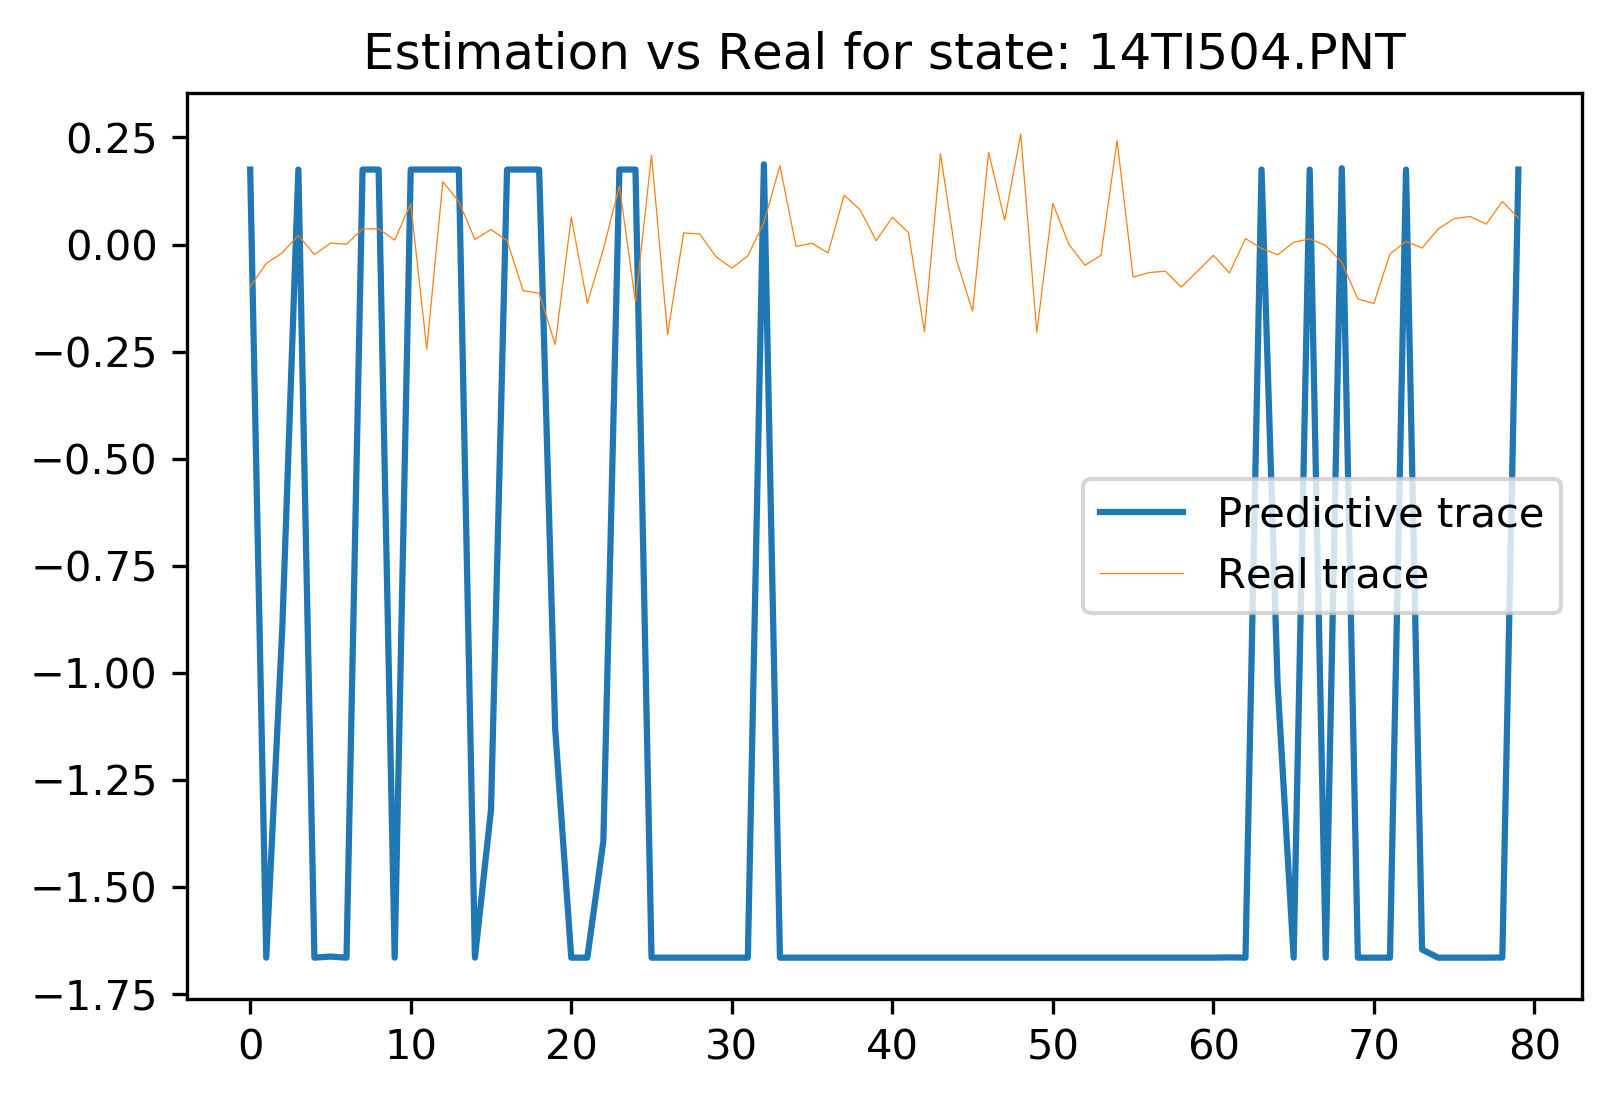

In [105]:
column=6
ini_obs=100000
num_obs=80
#num_obs=494624
state=state_names[column]
plot_title=('Estimation vs Real for state: %s'%state)
plot_results(estimate_trace=diff_each_step_estimation_nn_trace[ini_obs:ini_obs+num_obs,column],real_trace=state_diff[ini_obs:ini_obs+num_obs,column],title=plot_title)

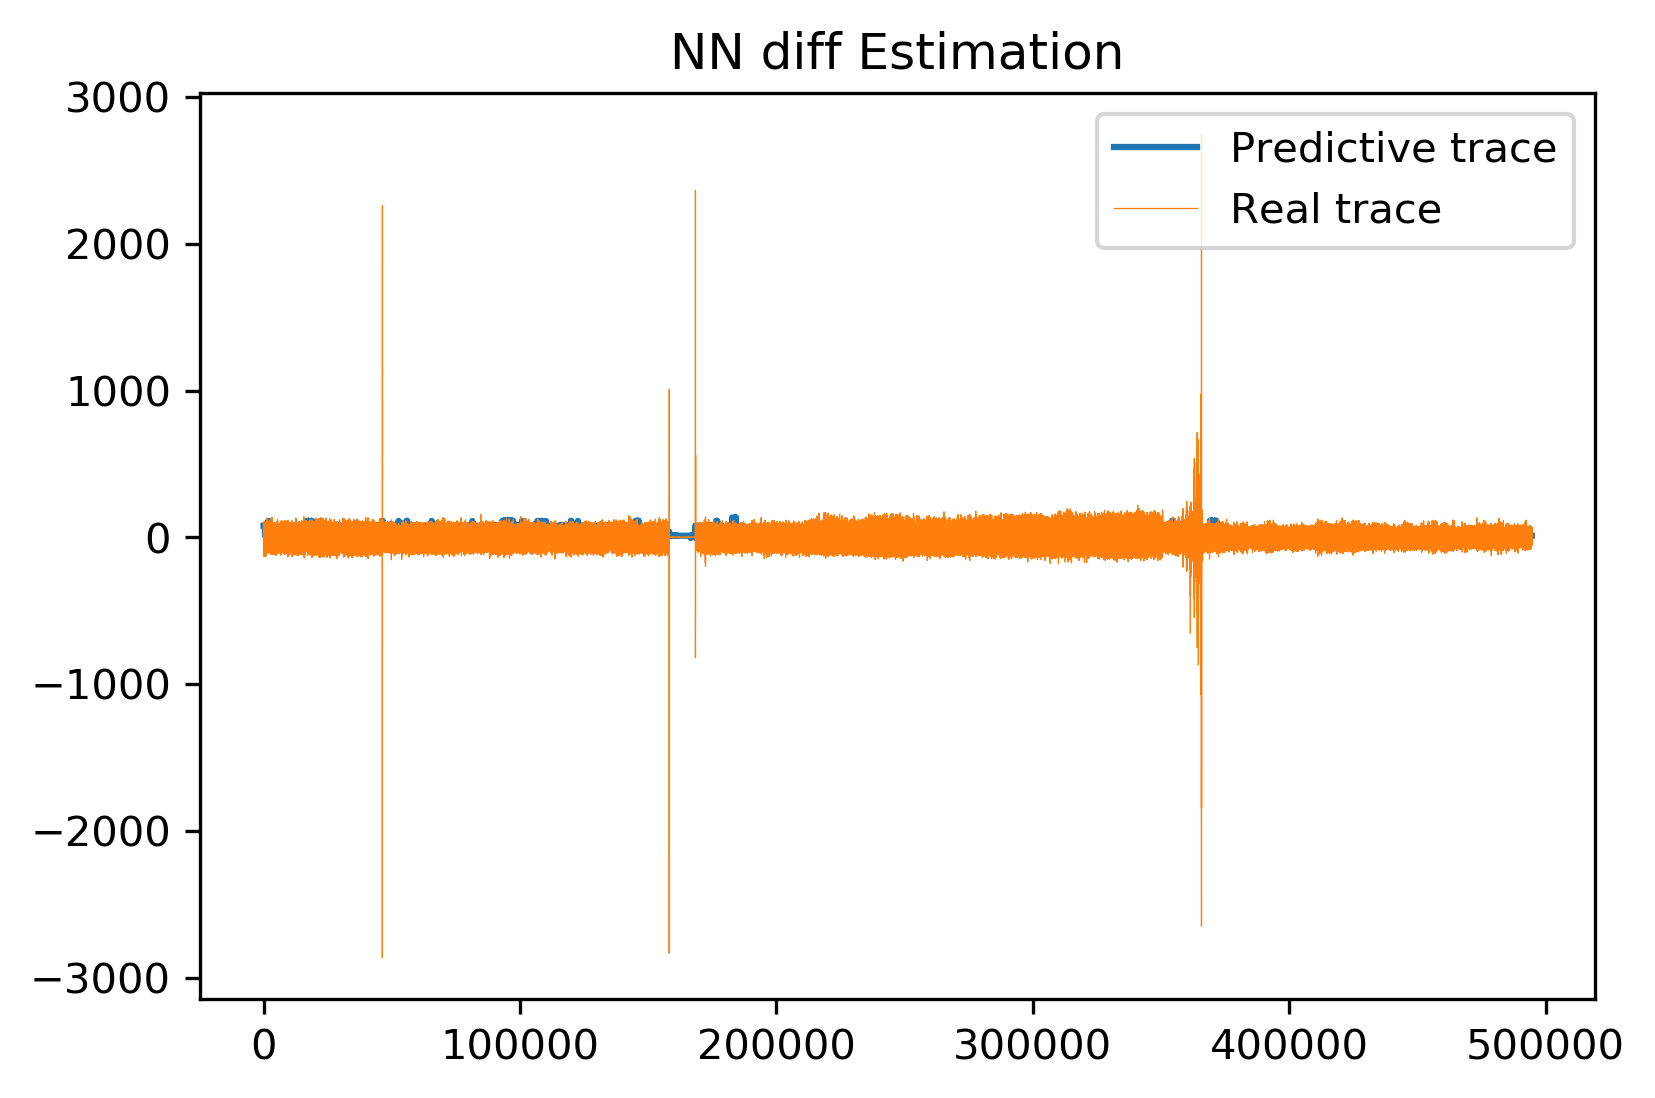

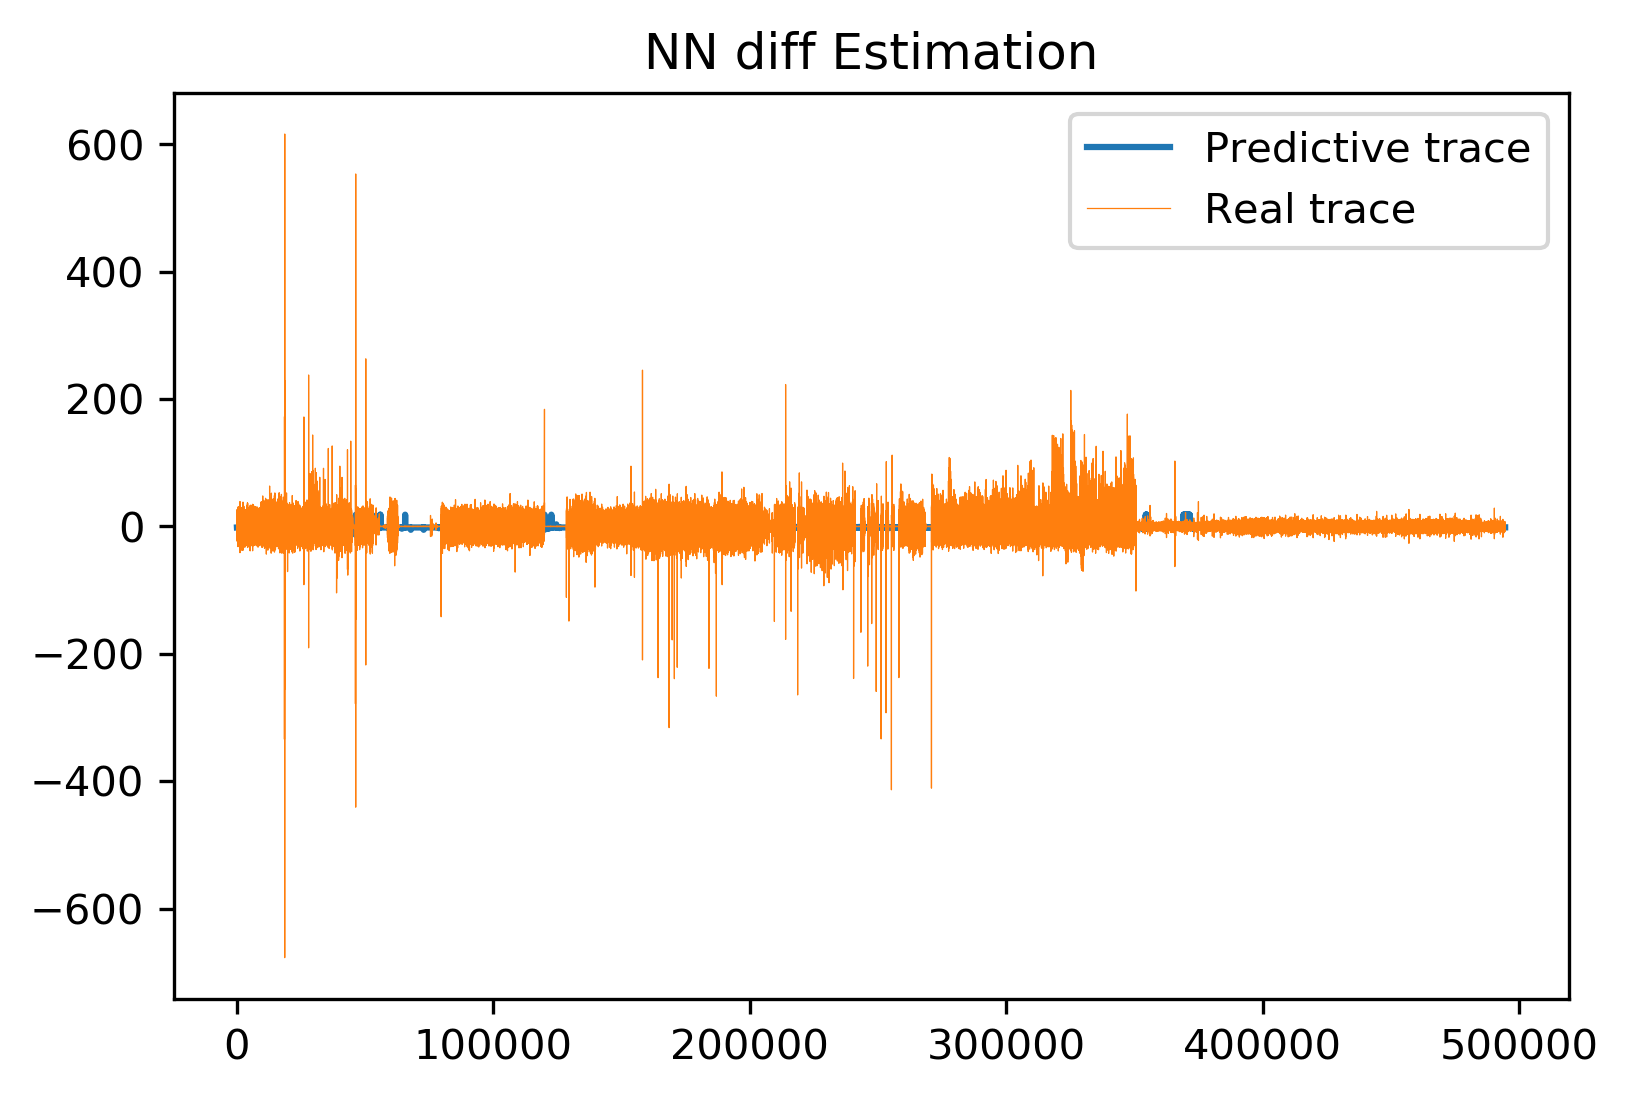

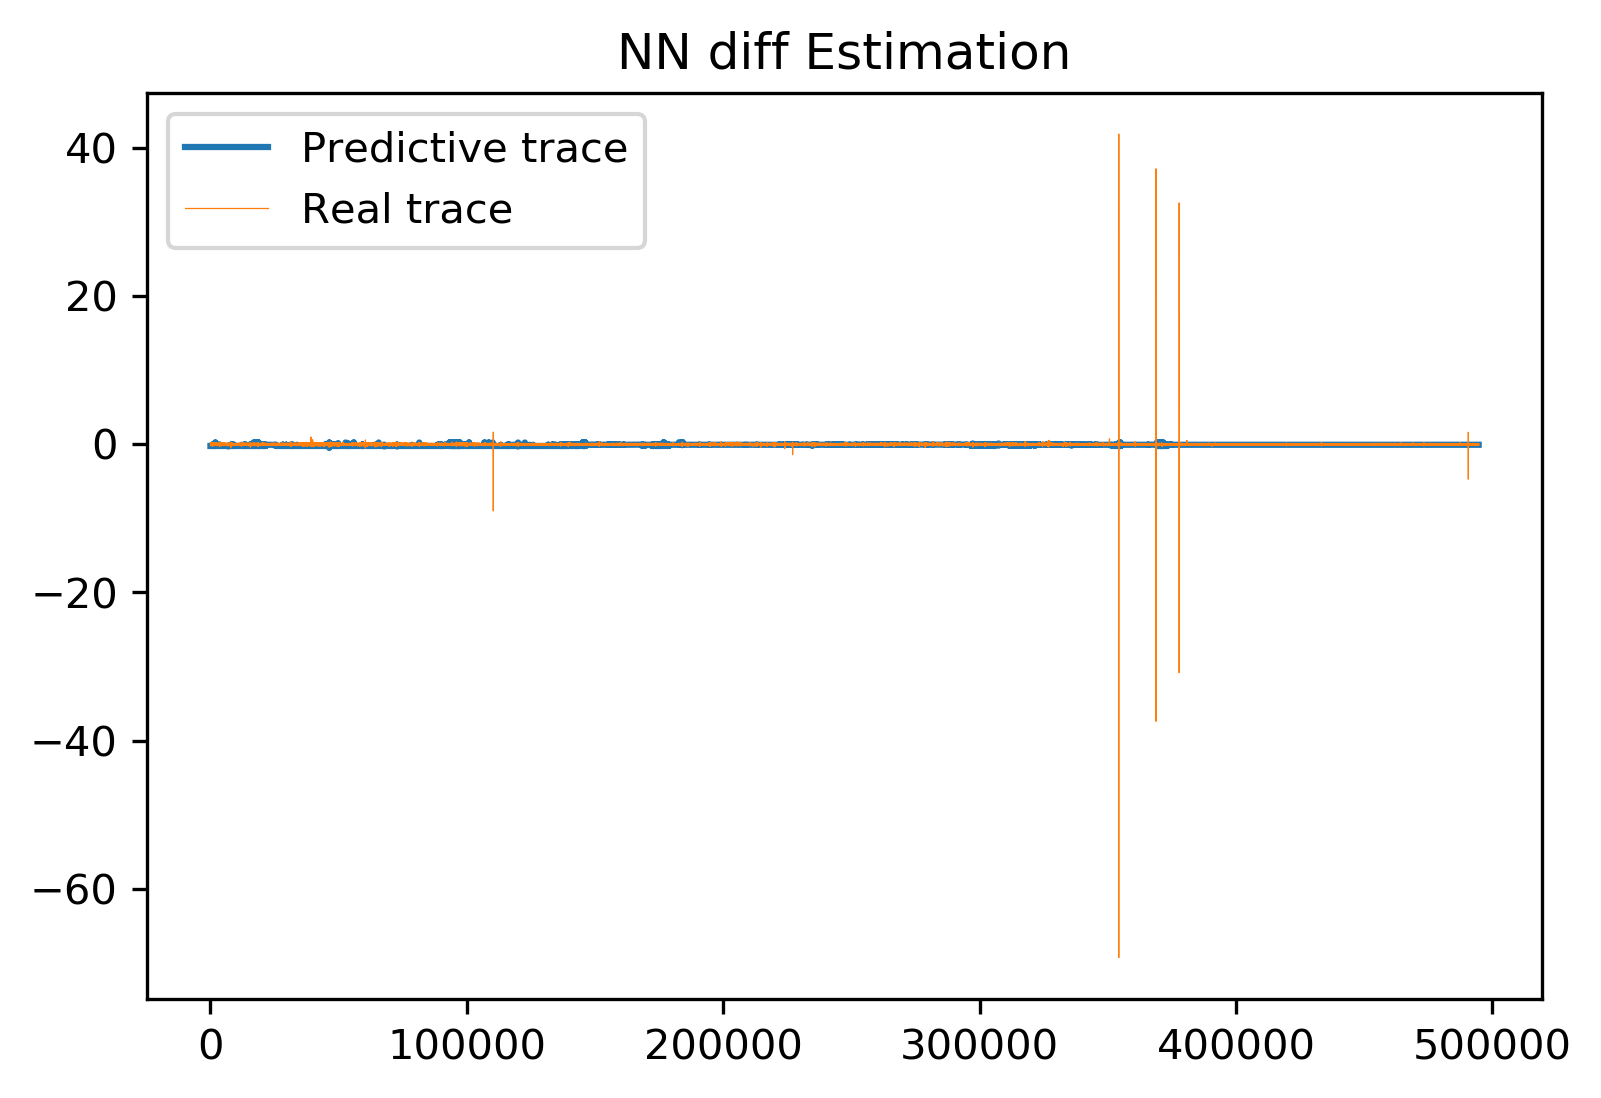

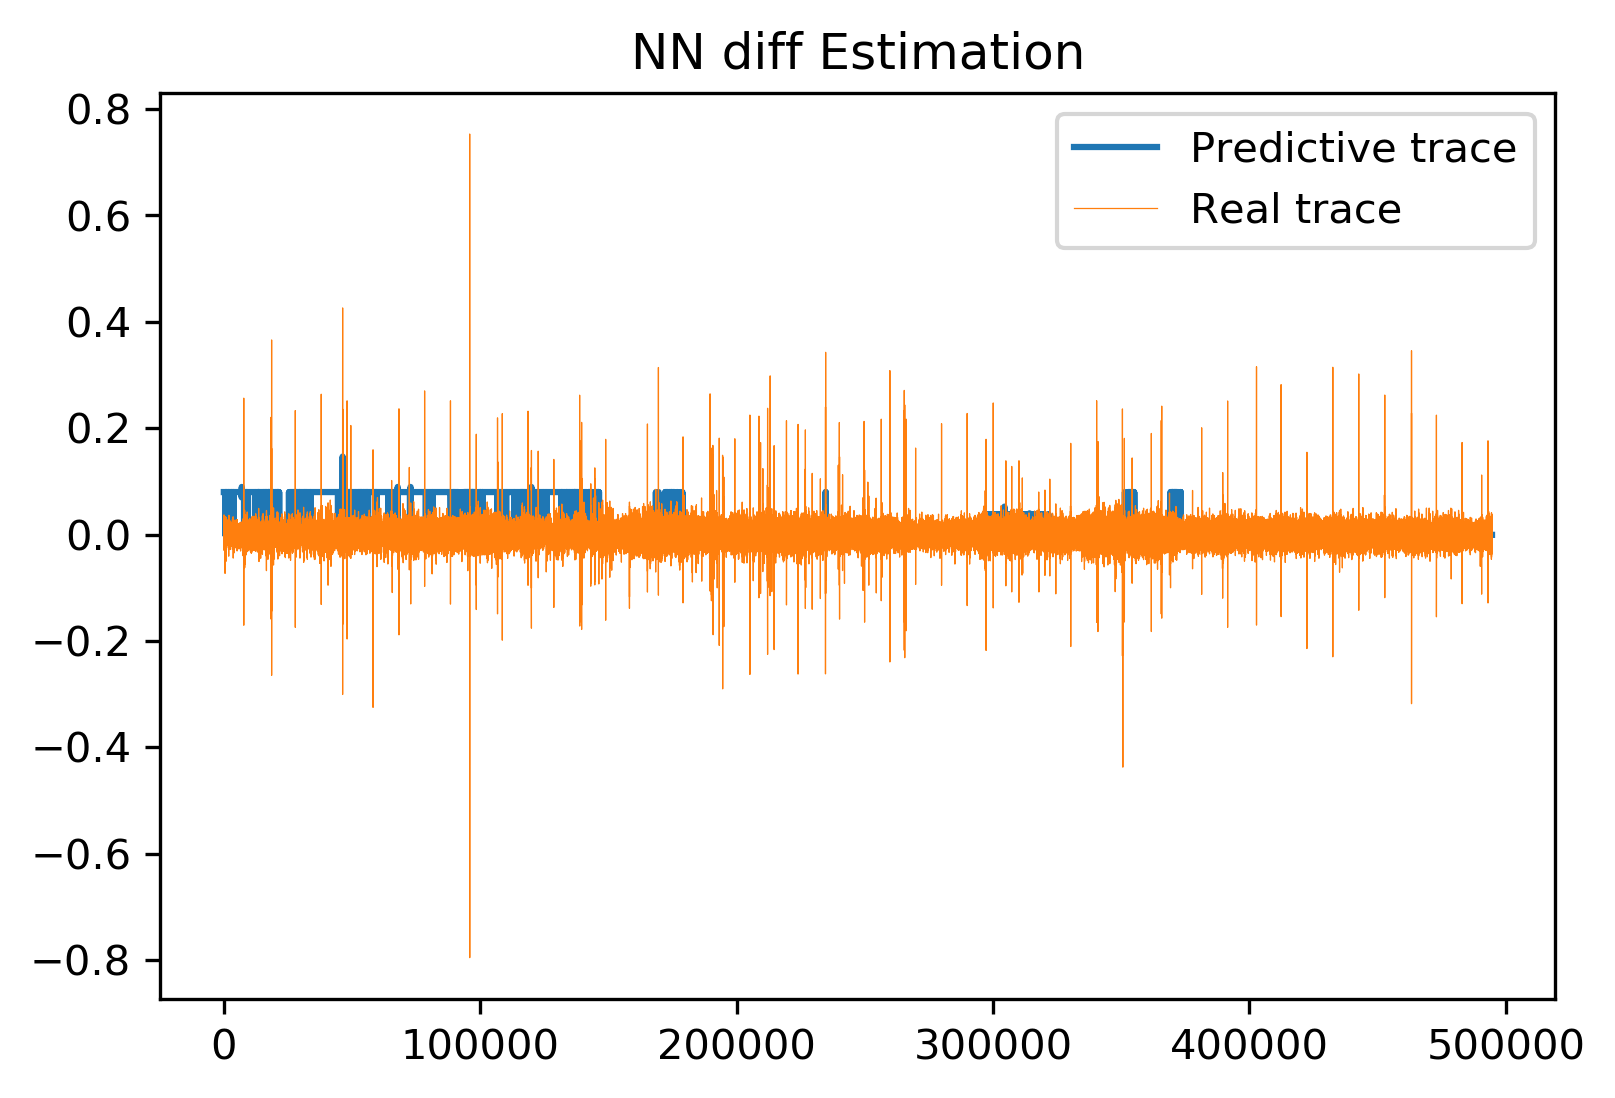

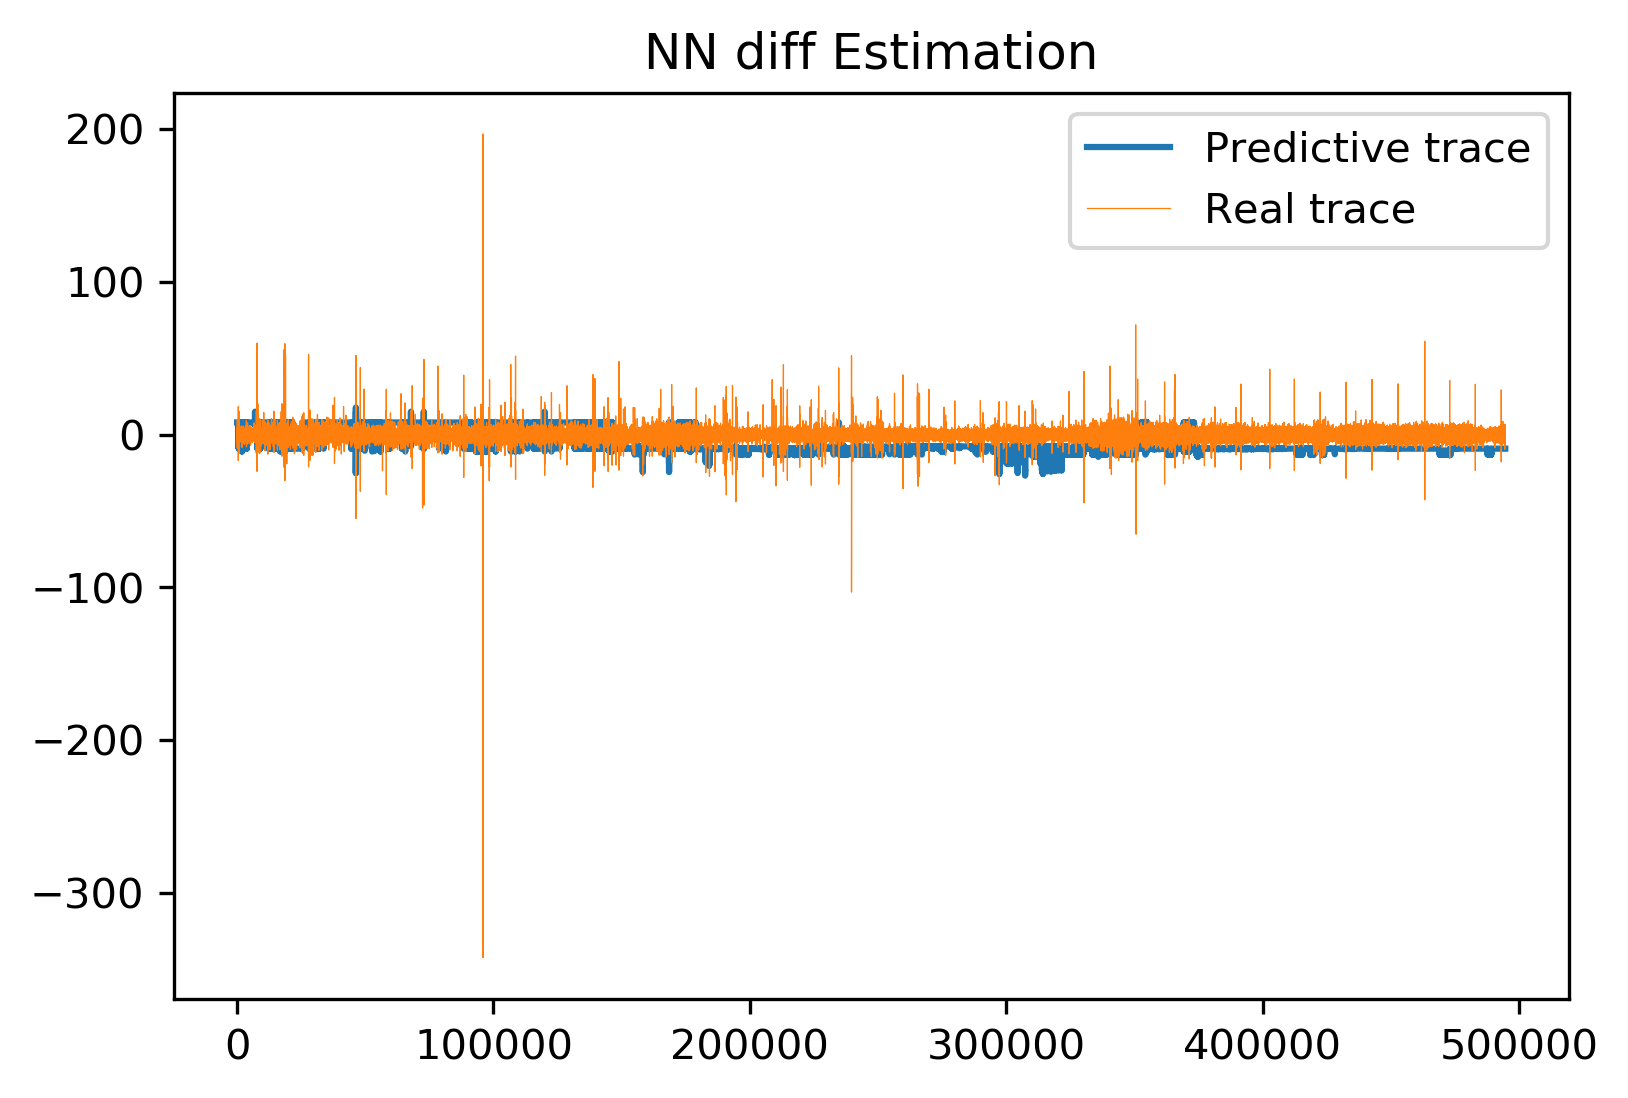

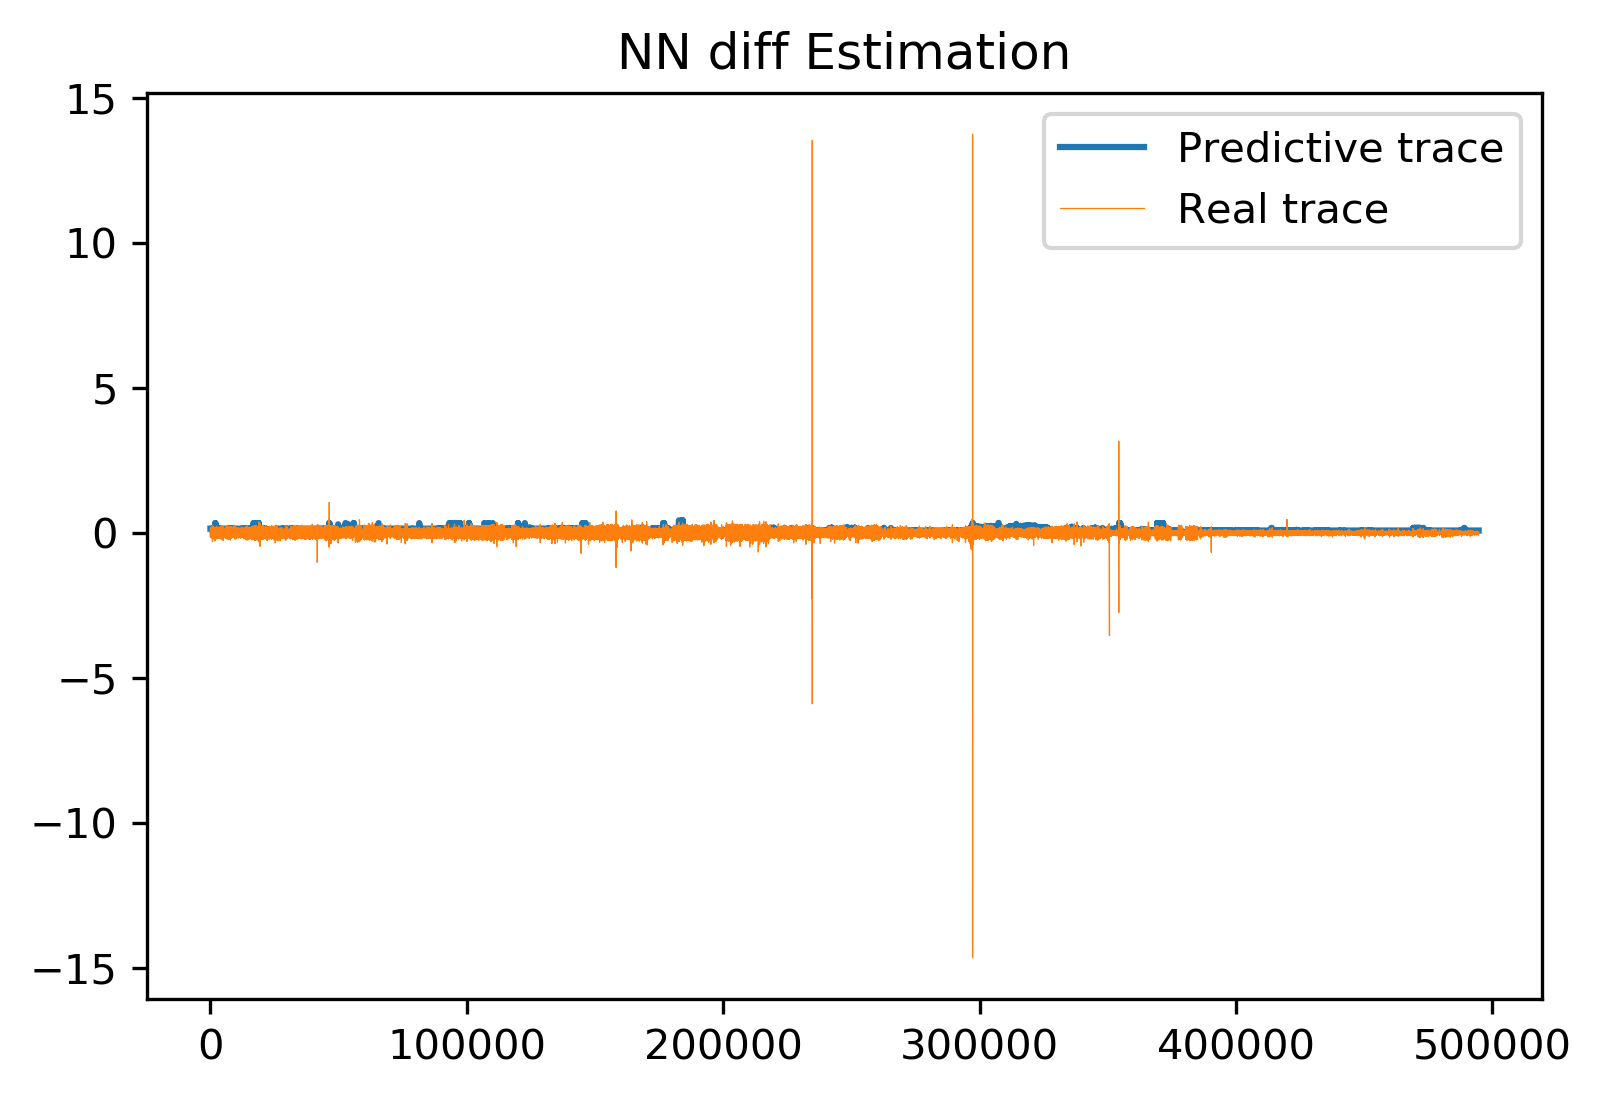

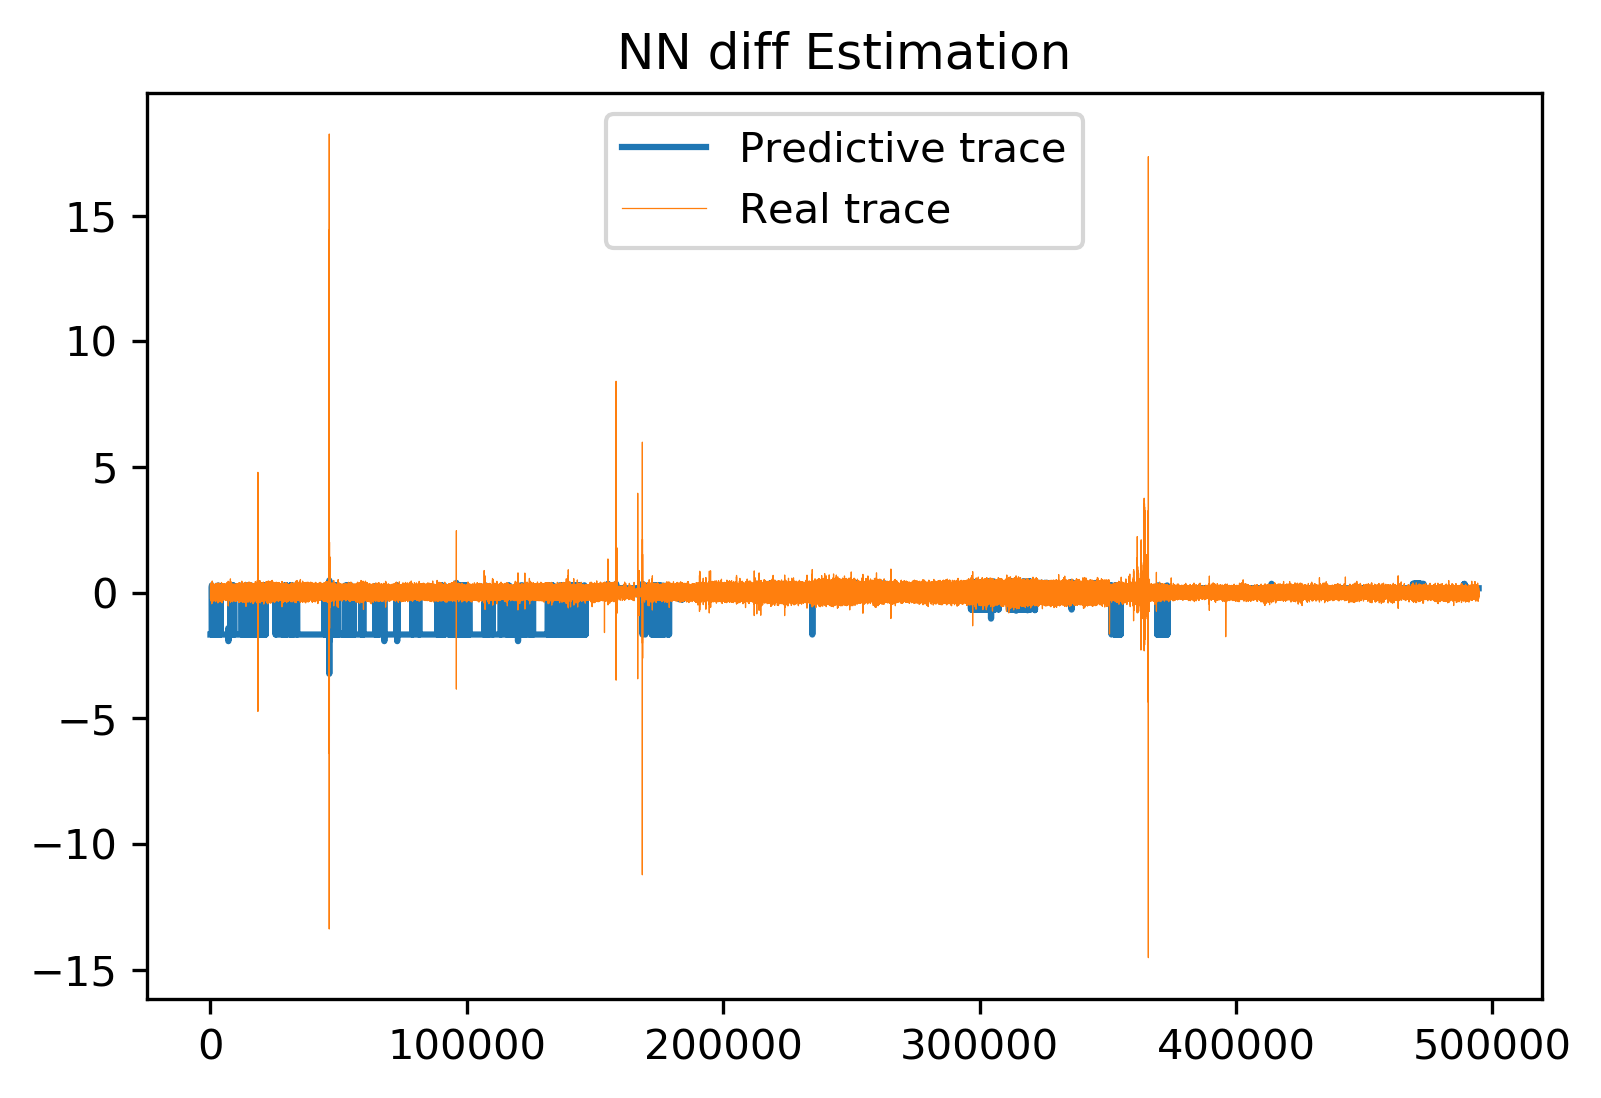

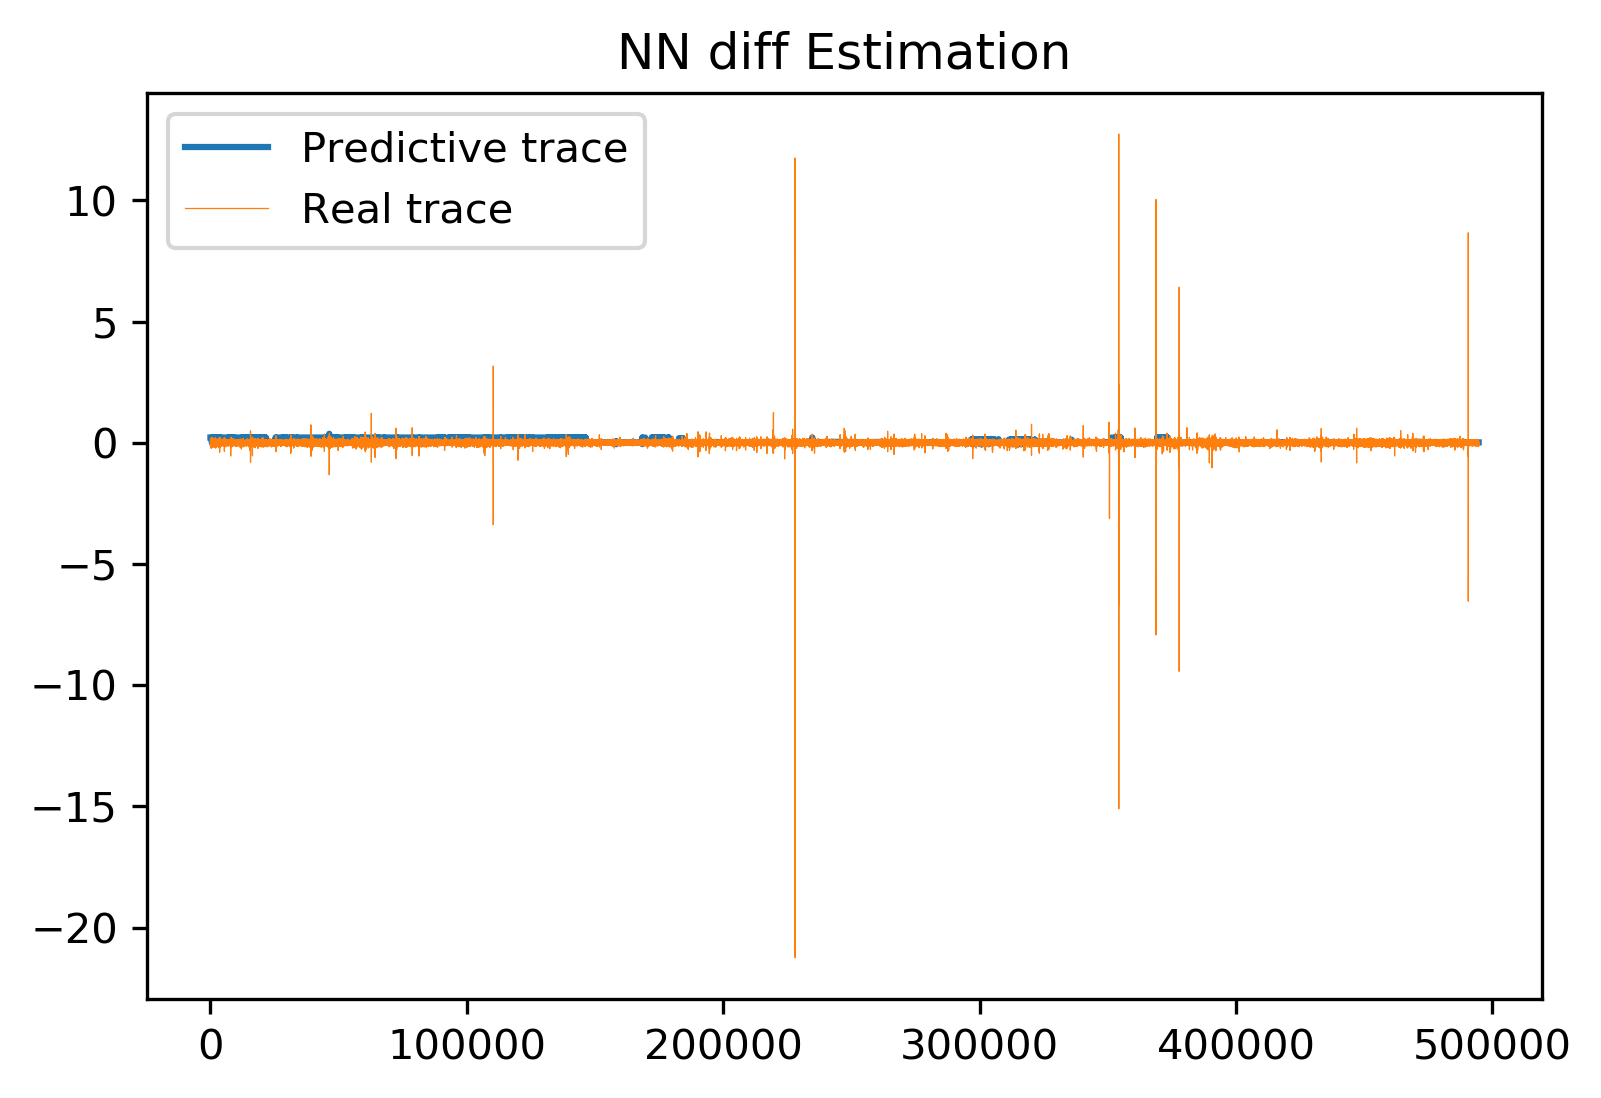

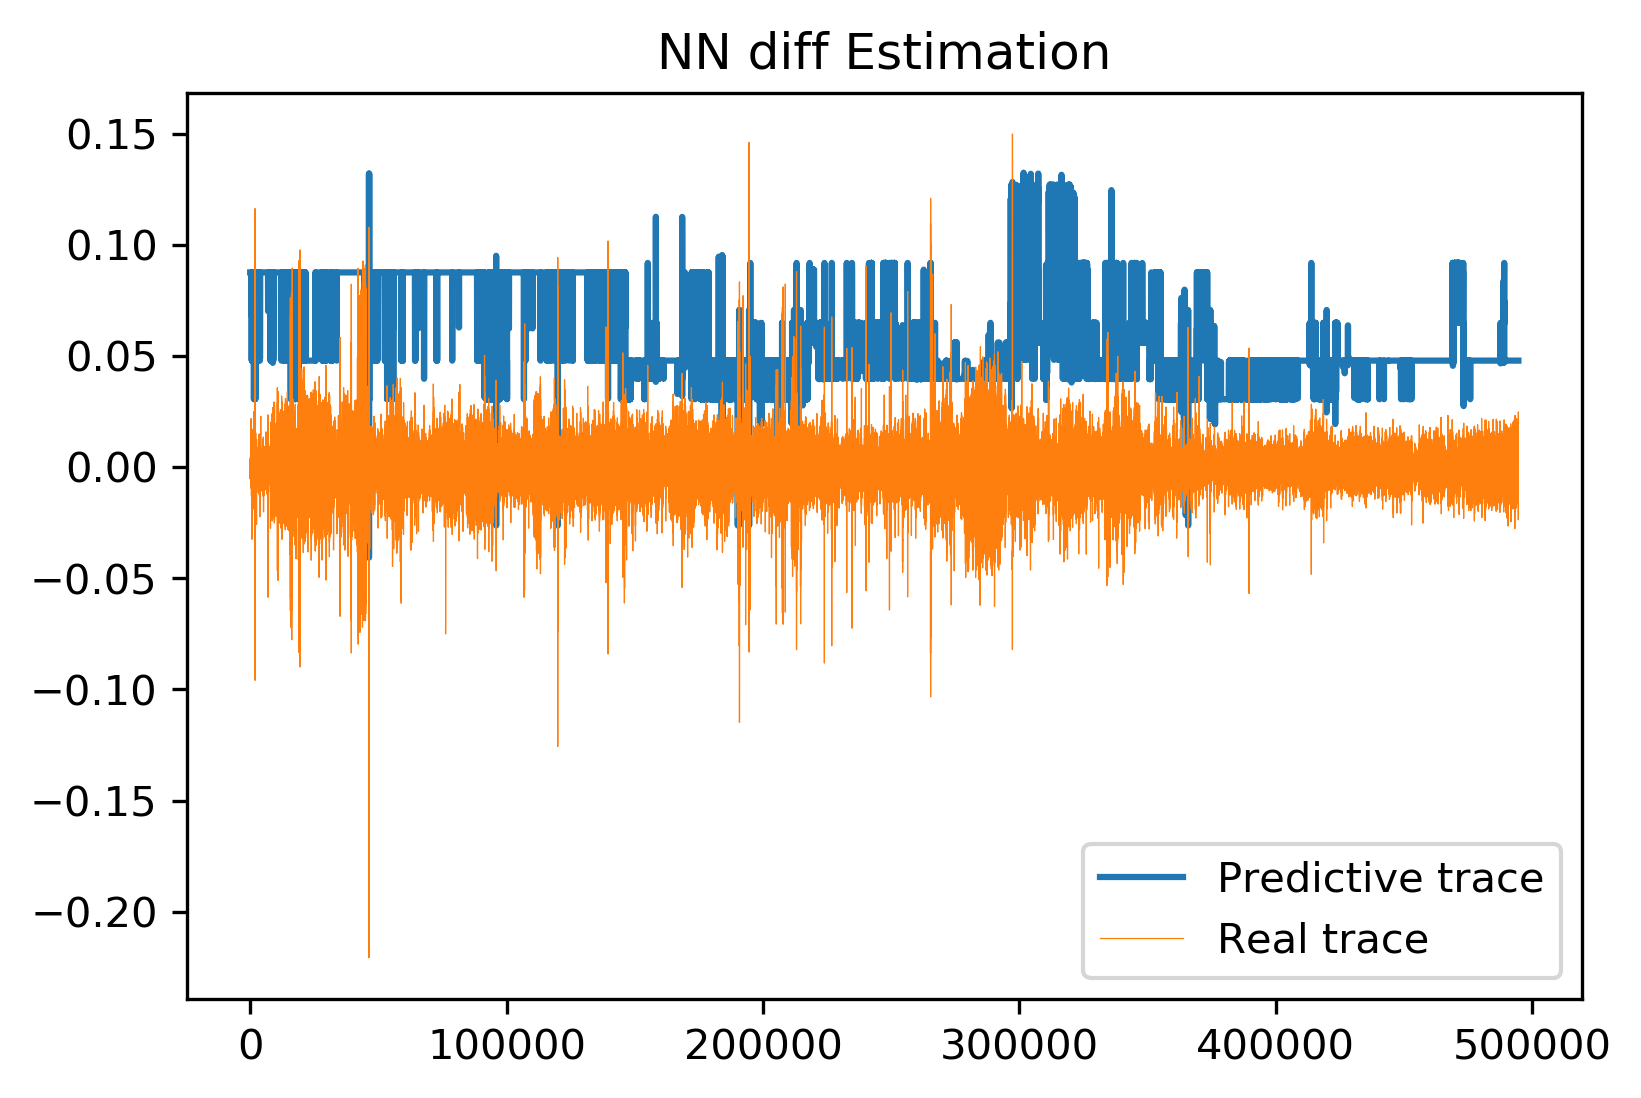

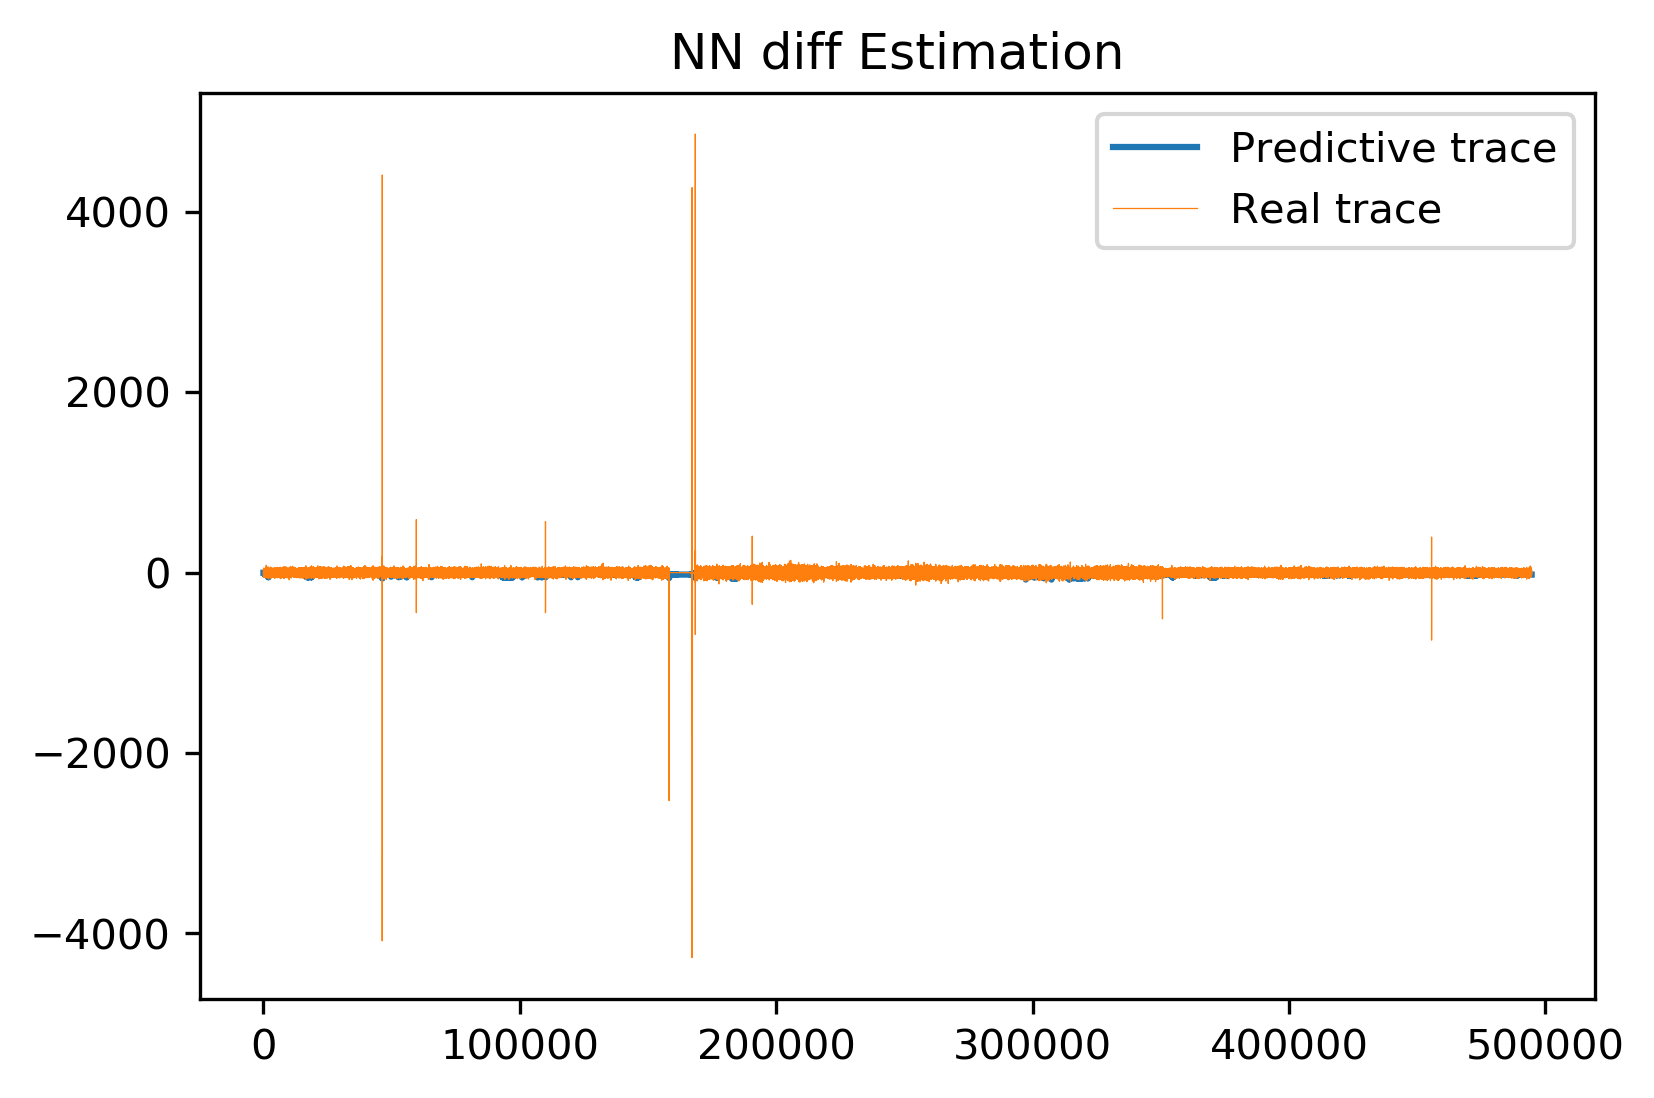

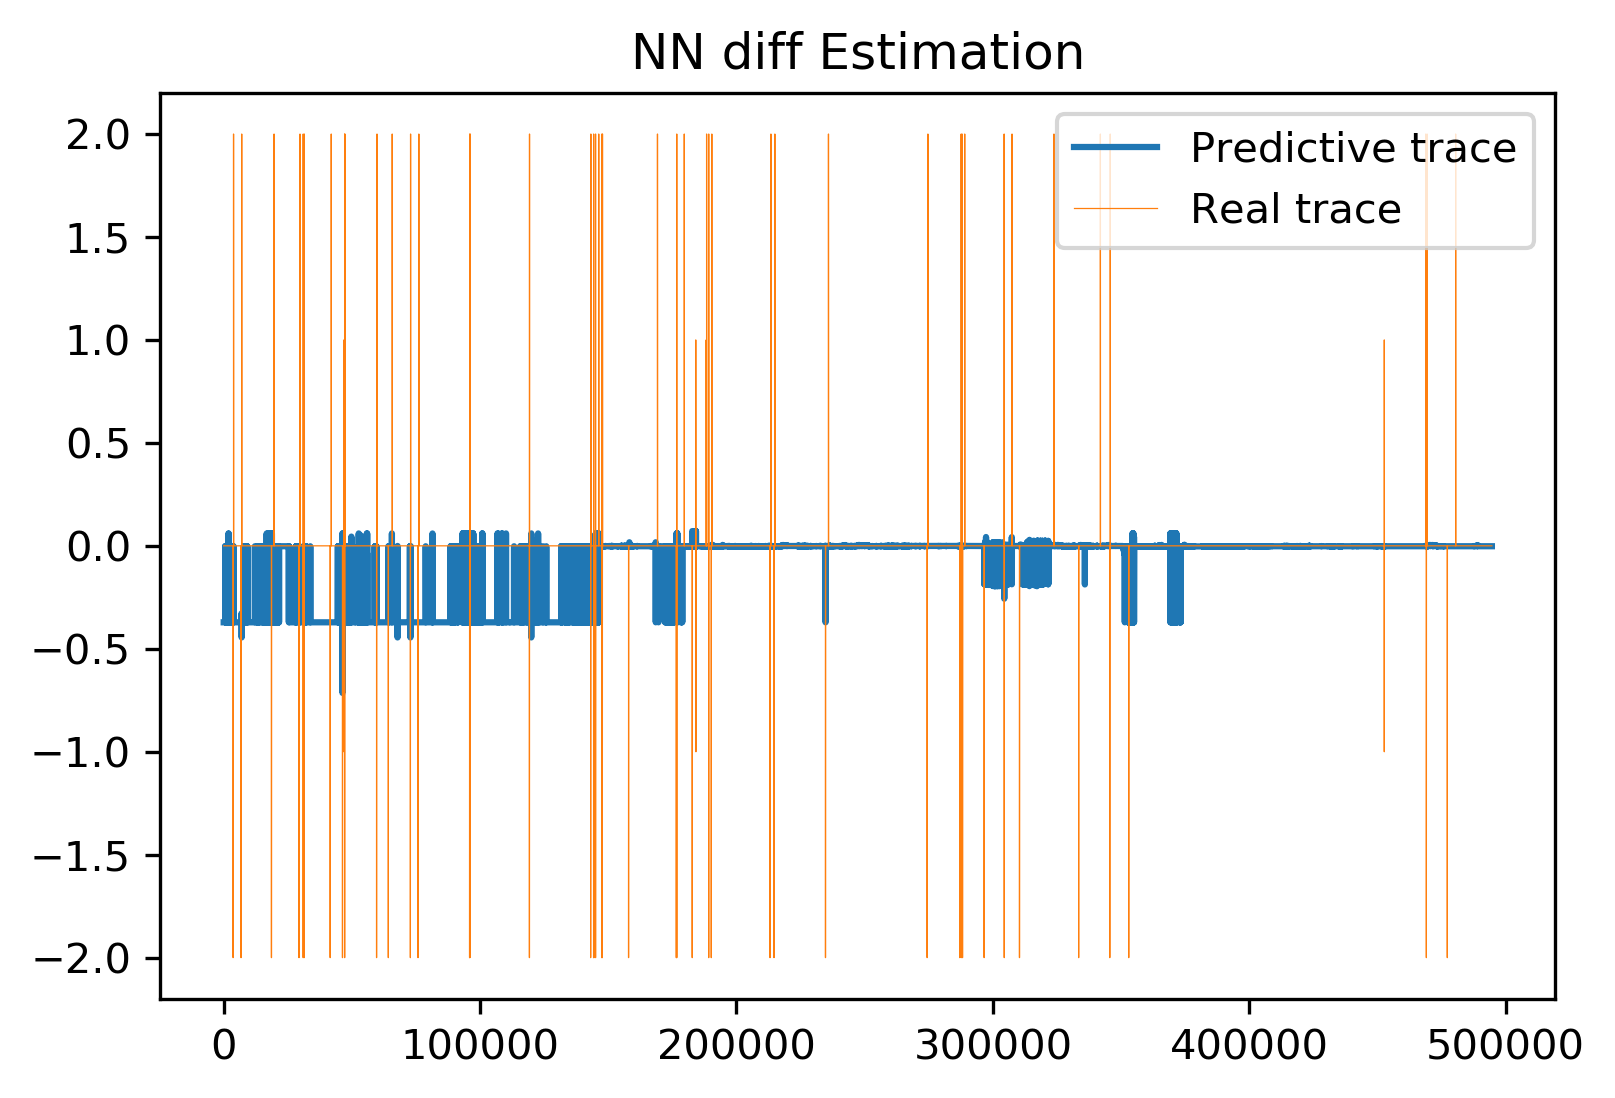

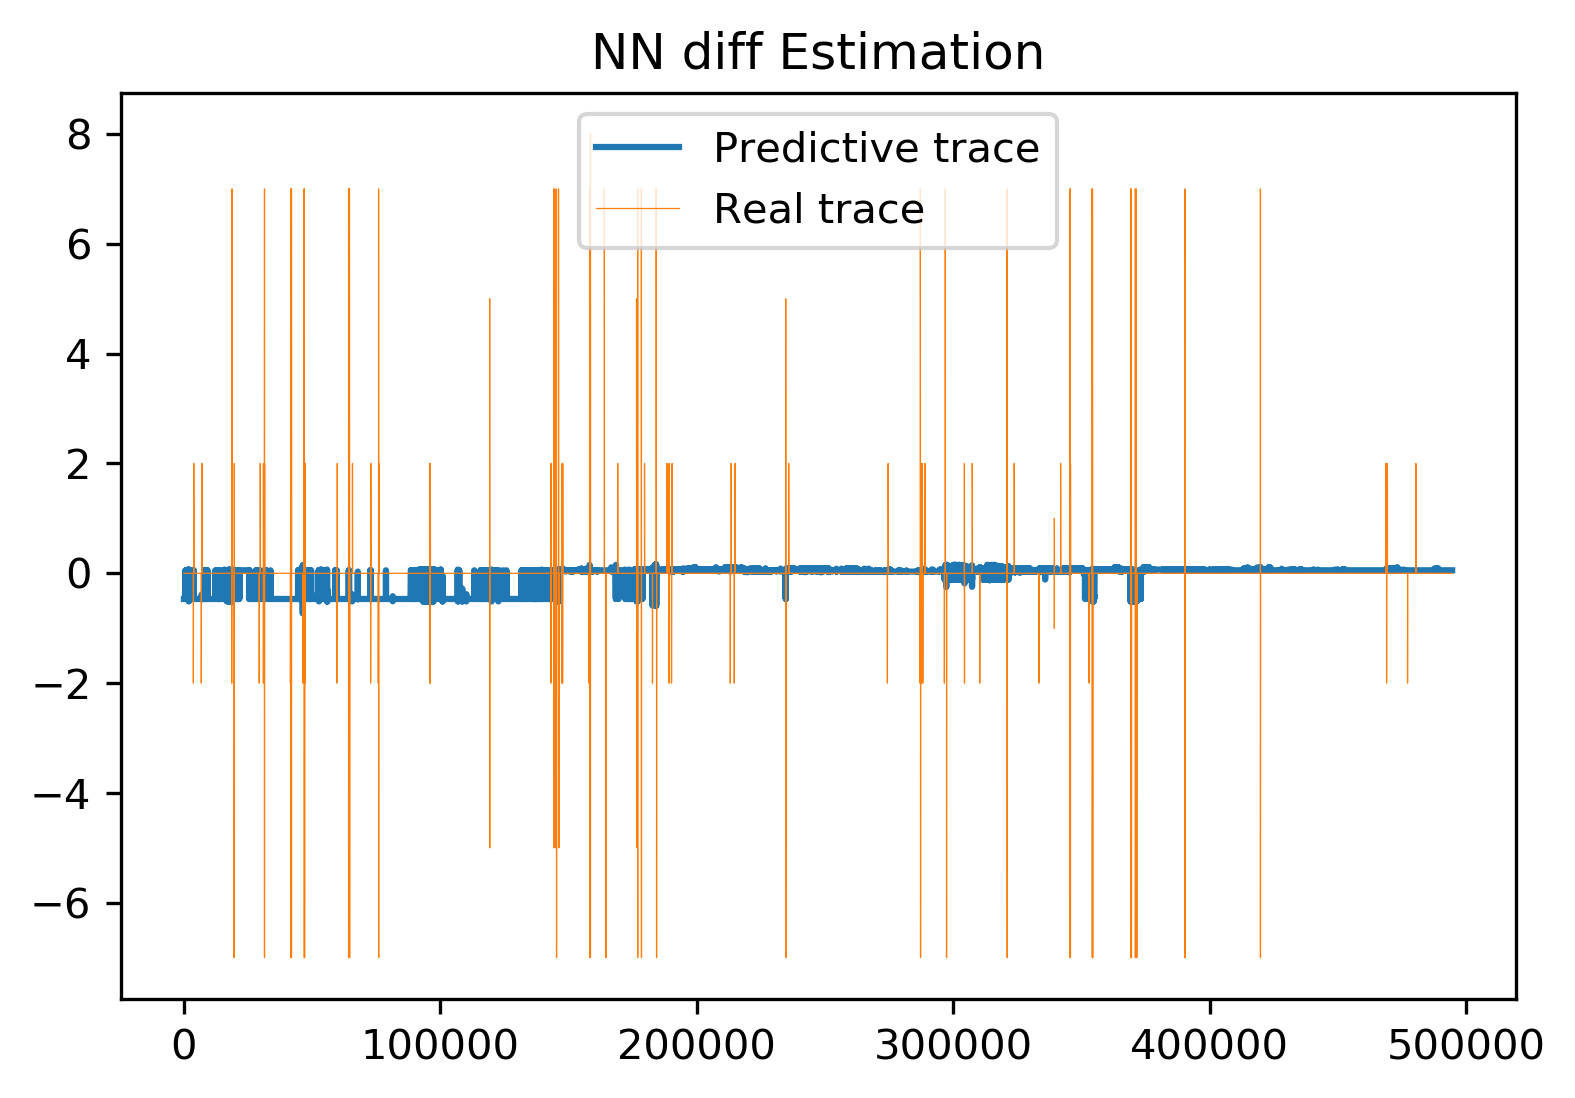

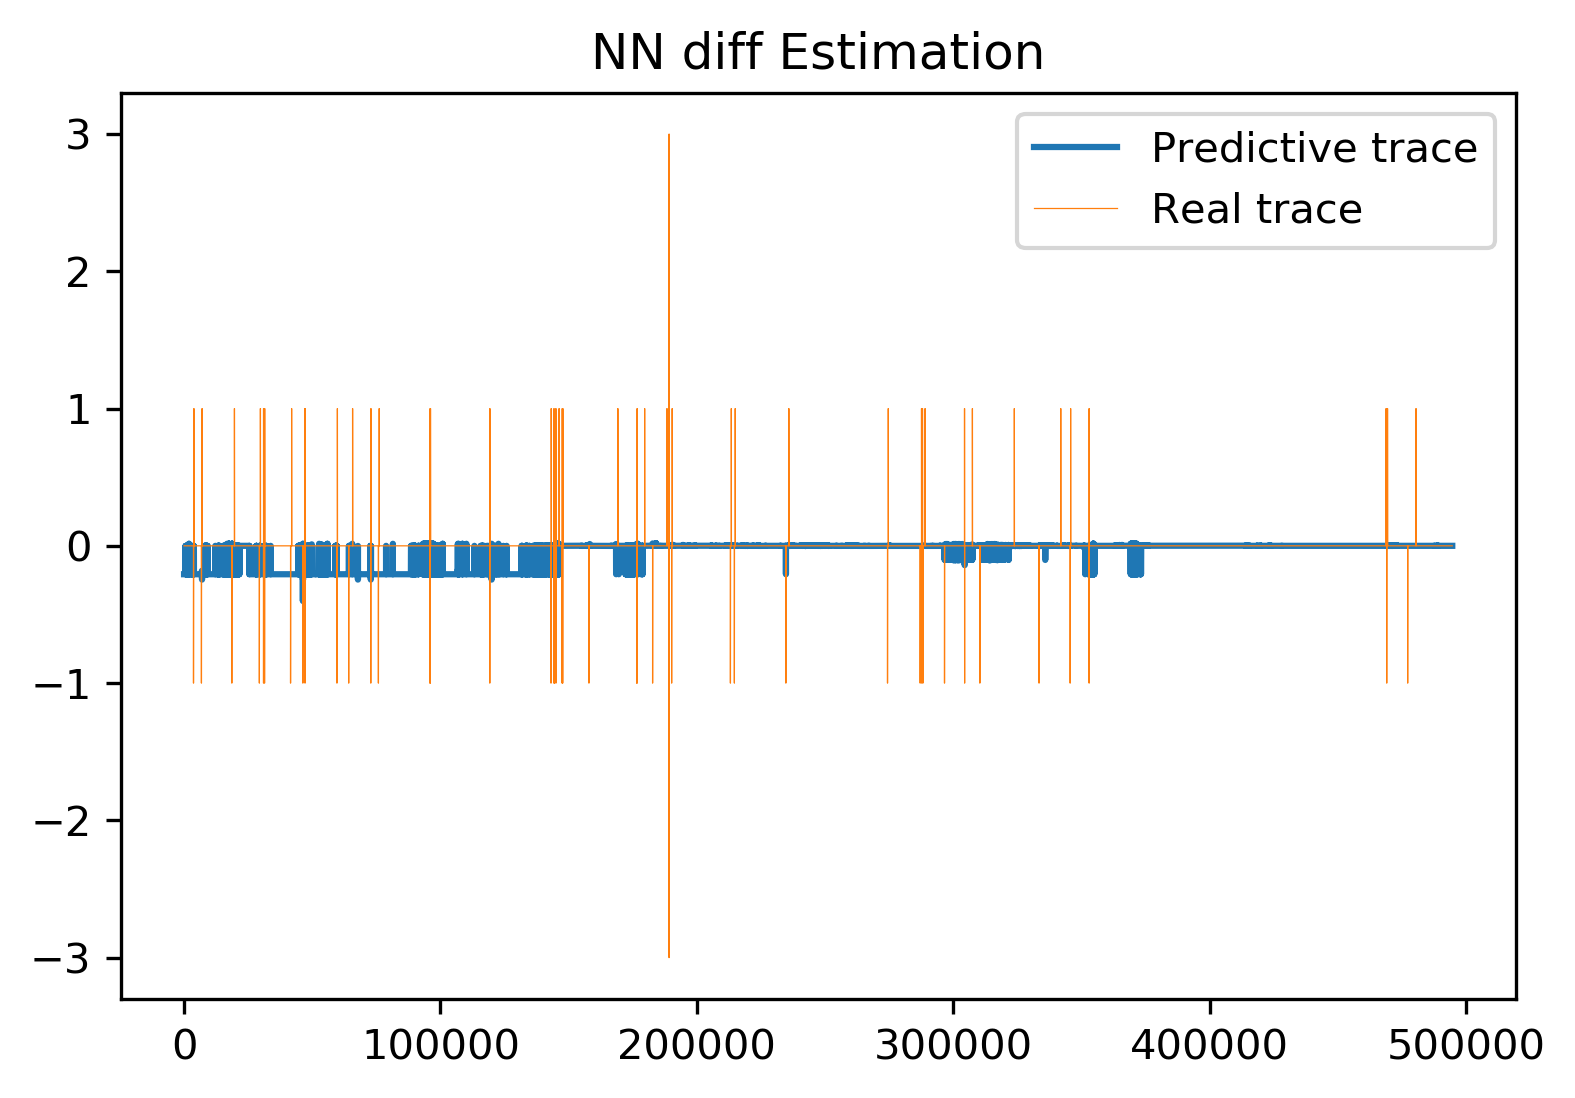

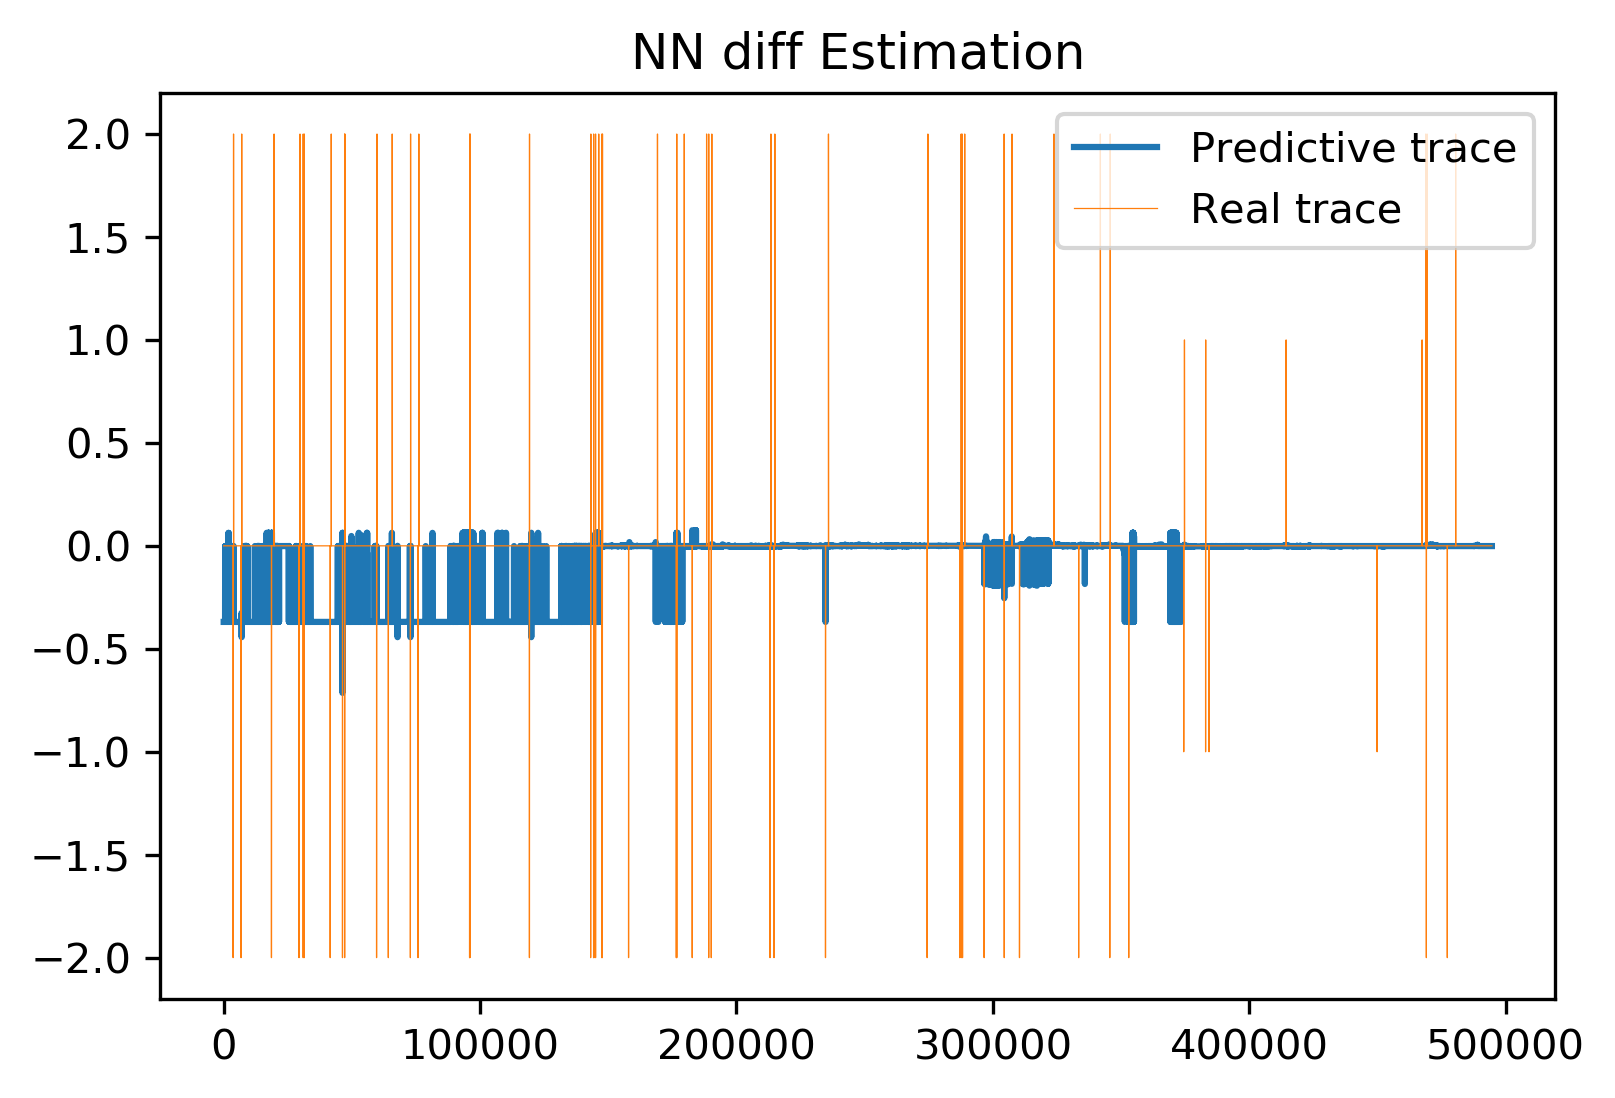

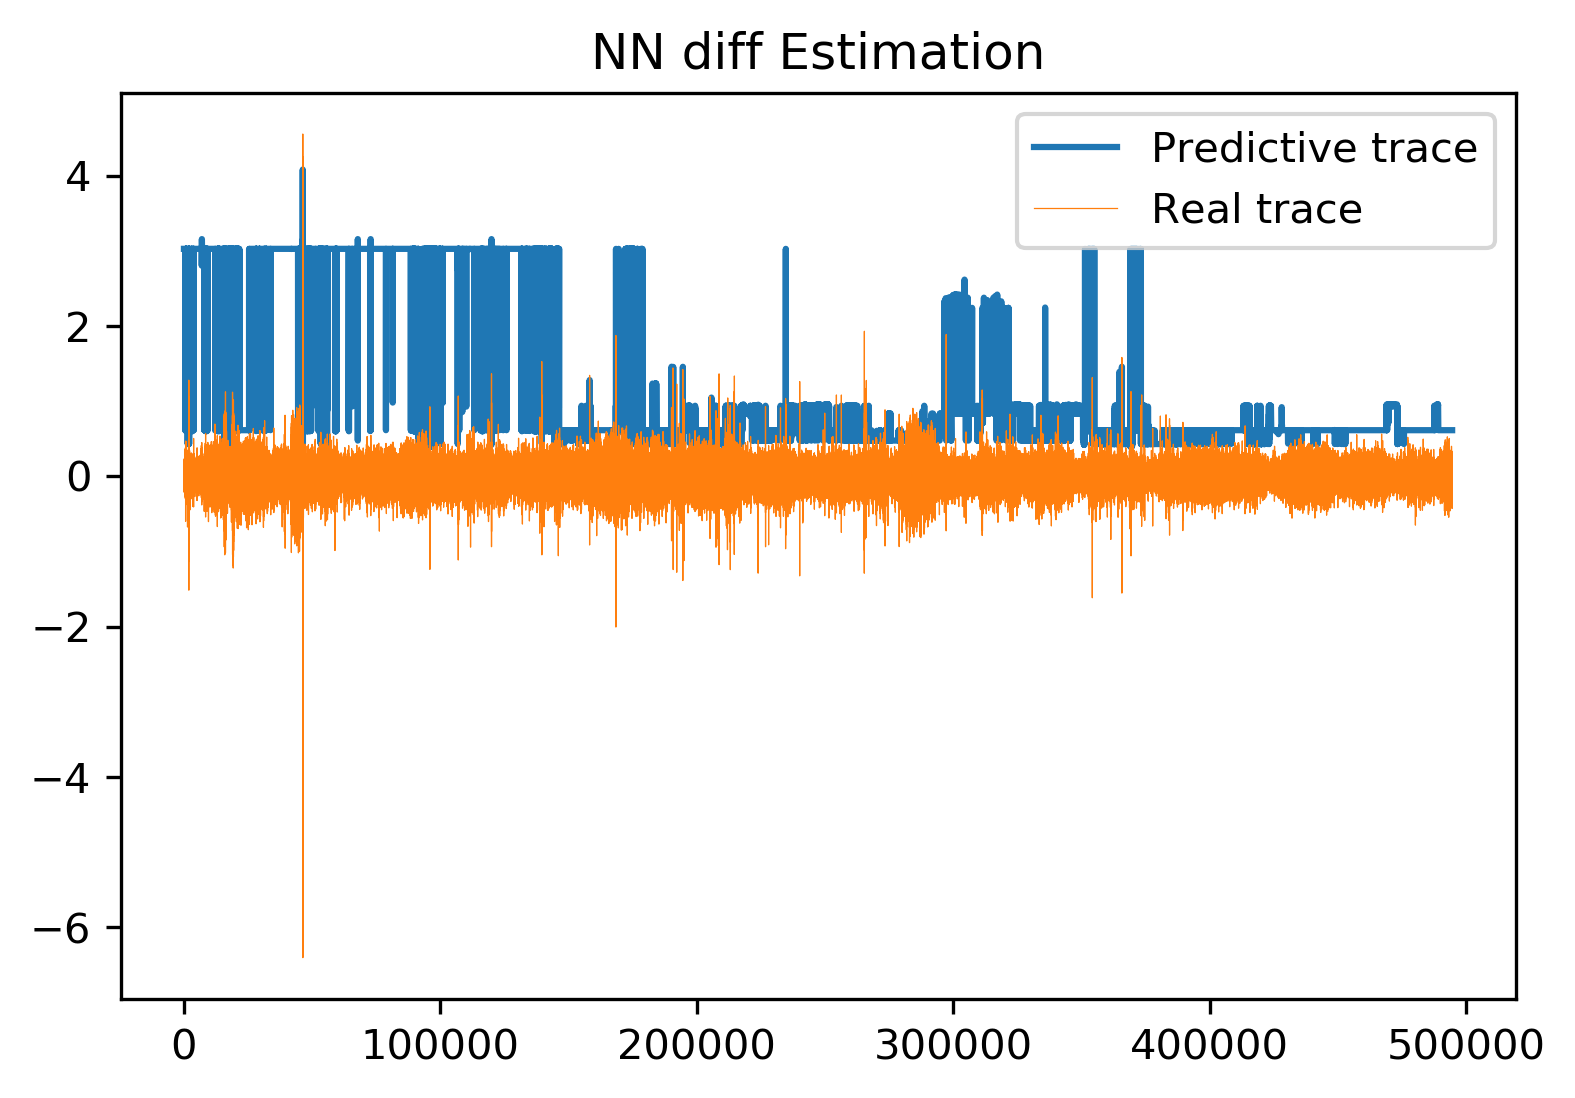

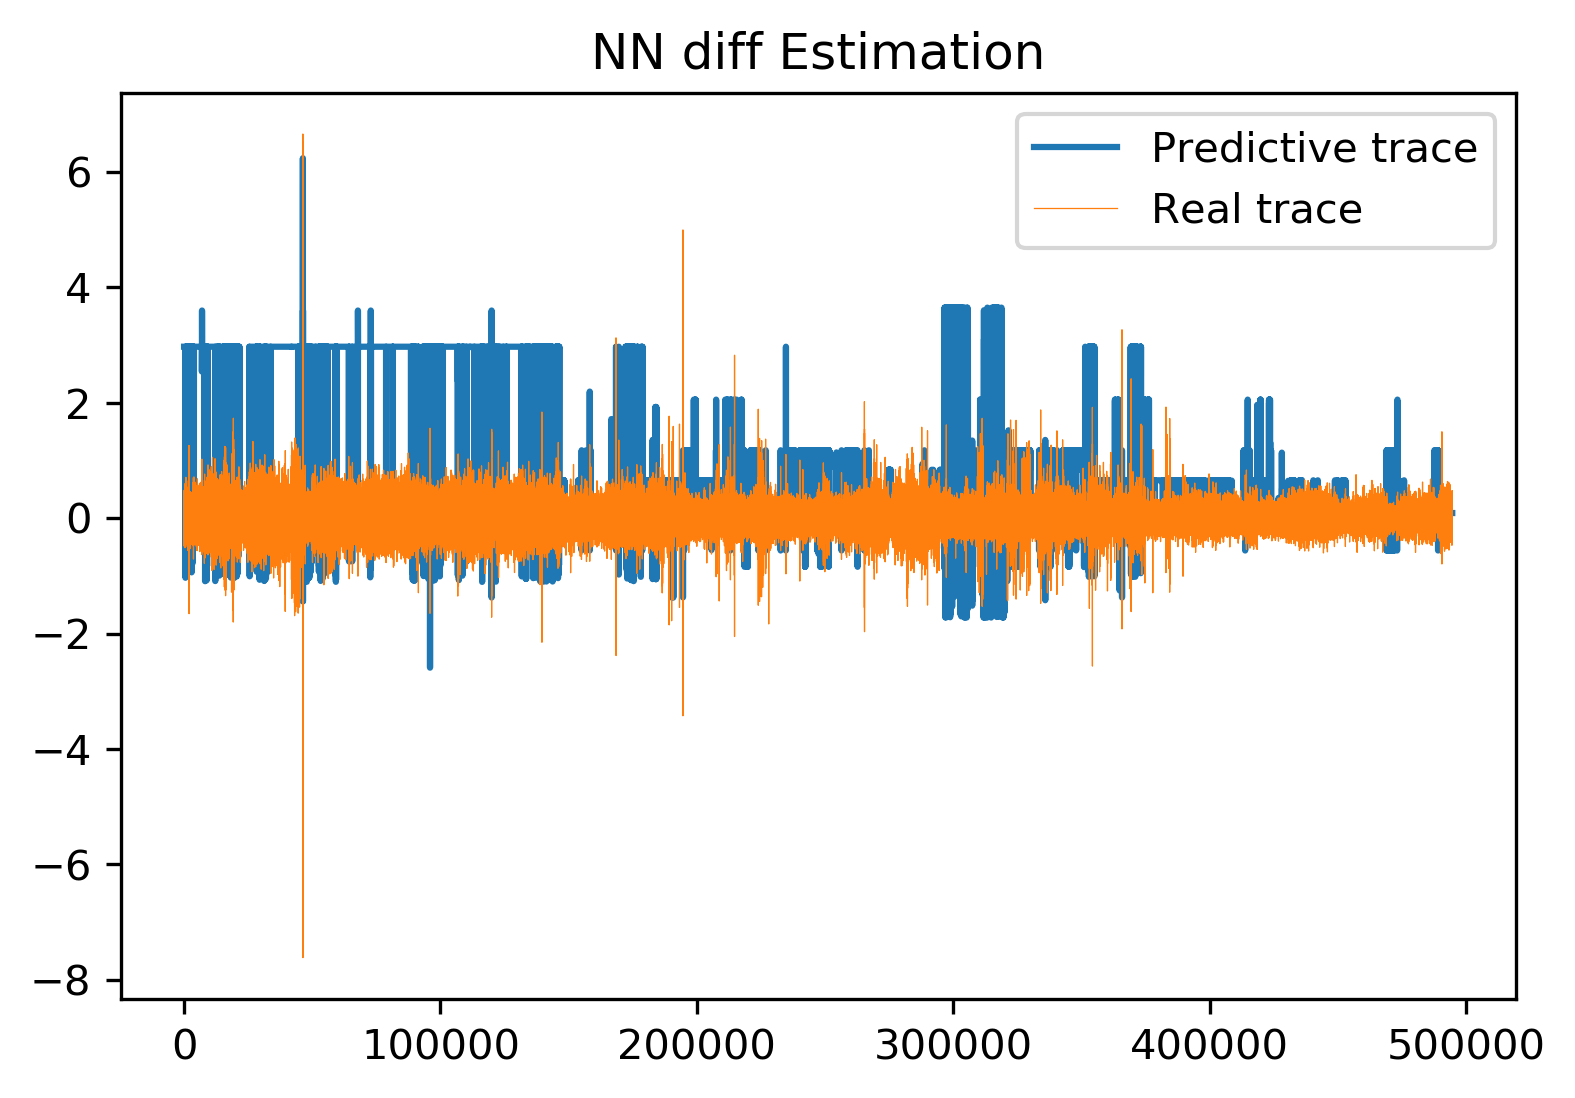

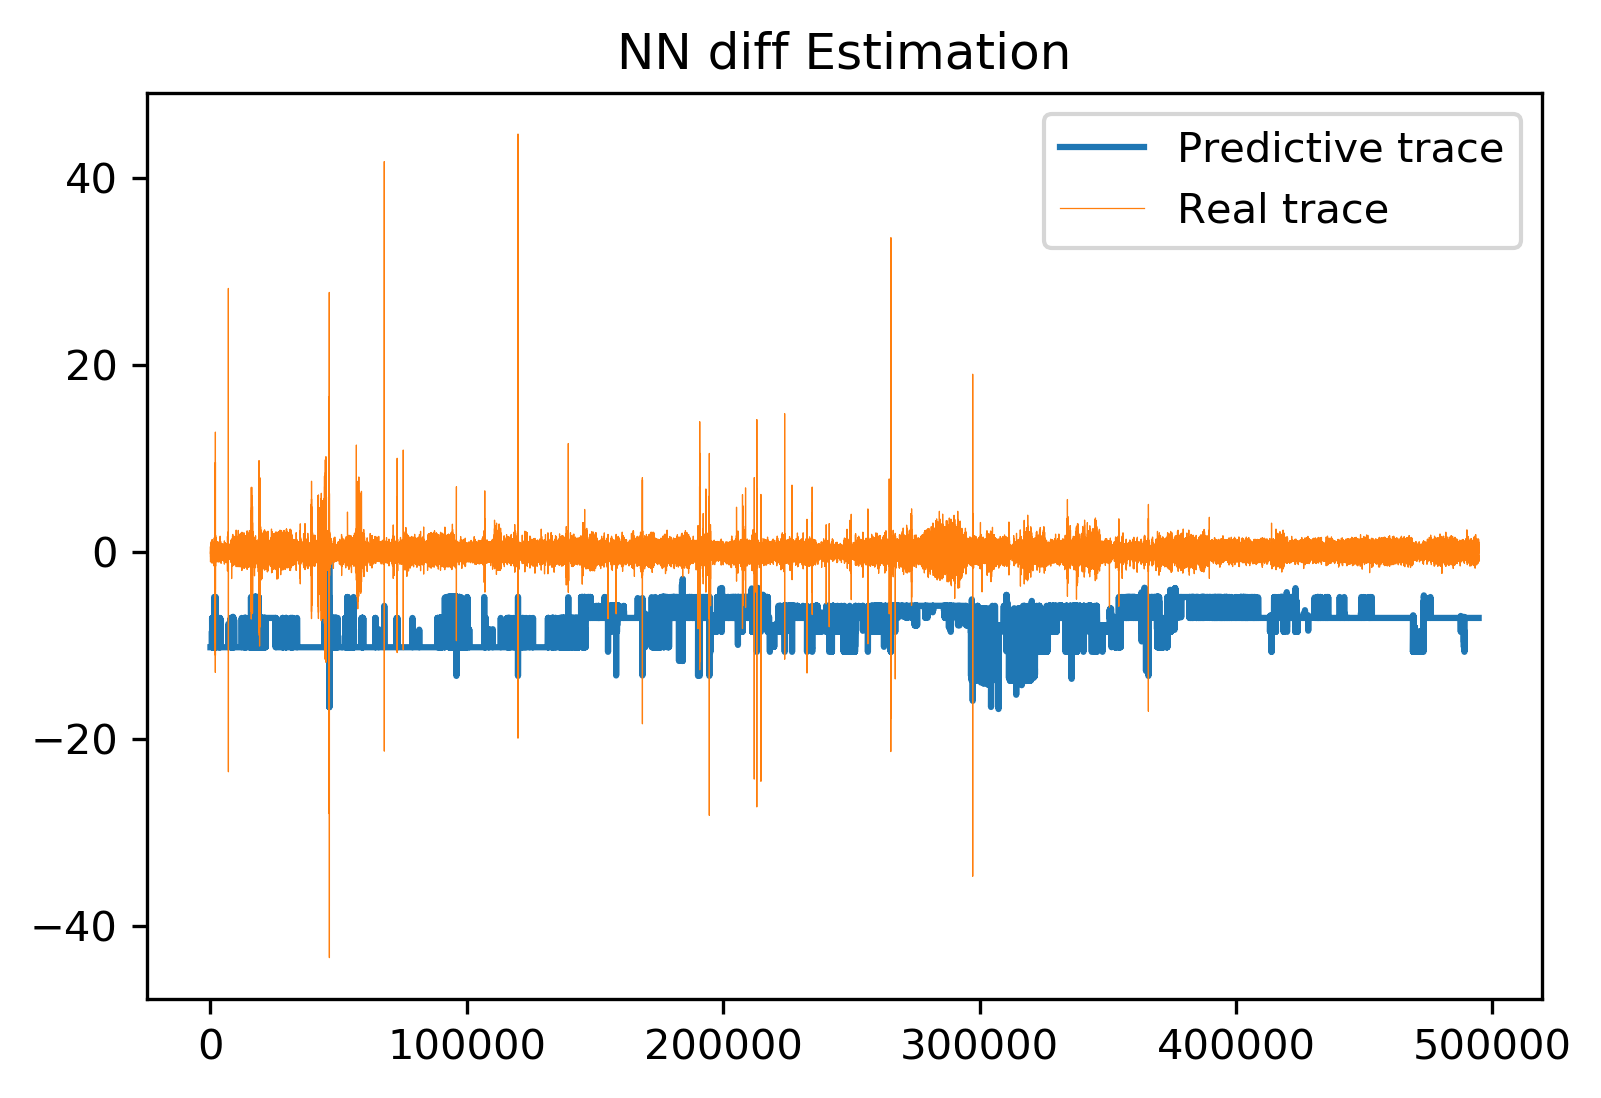

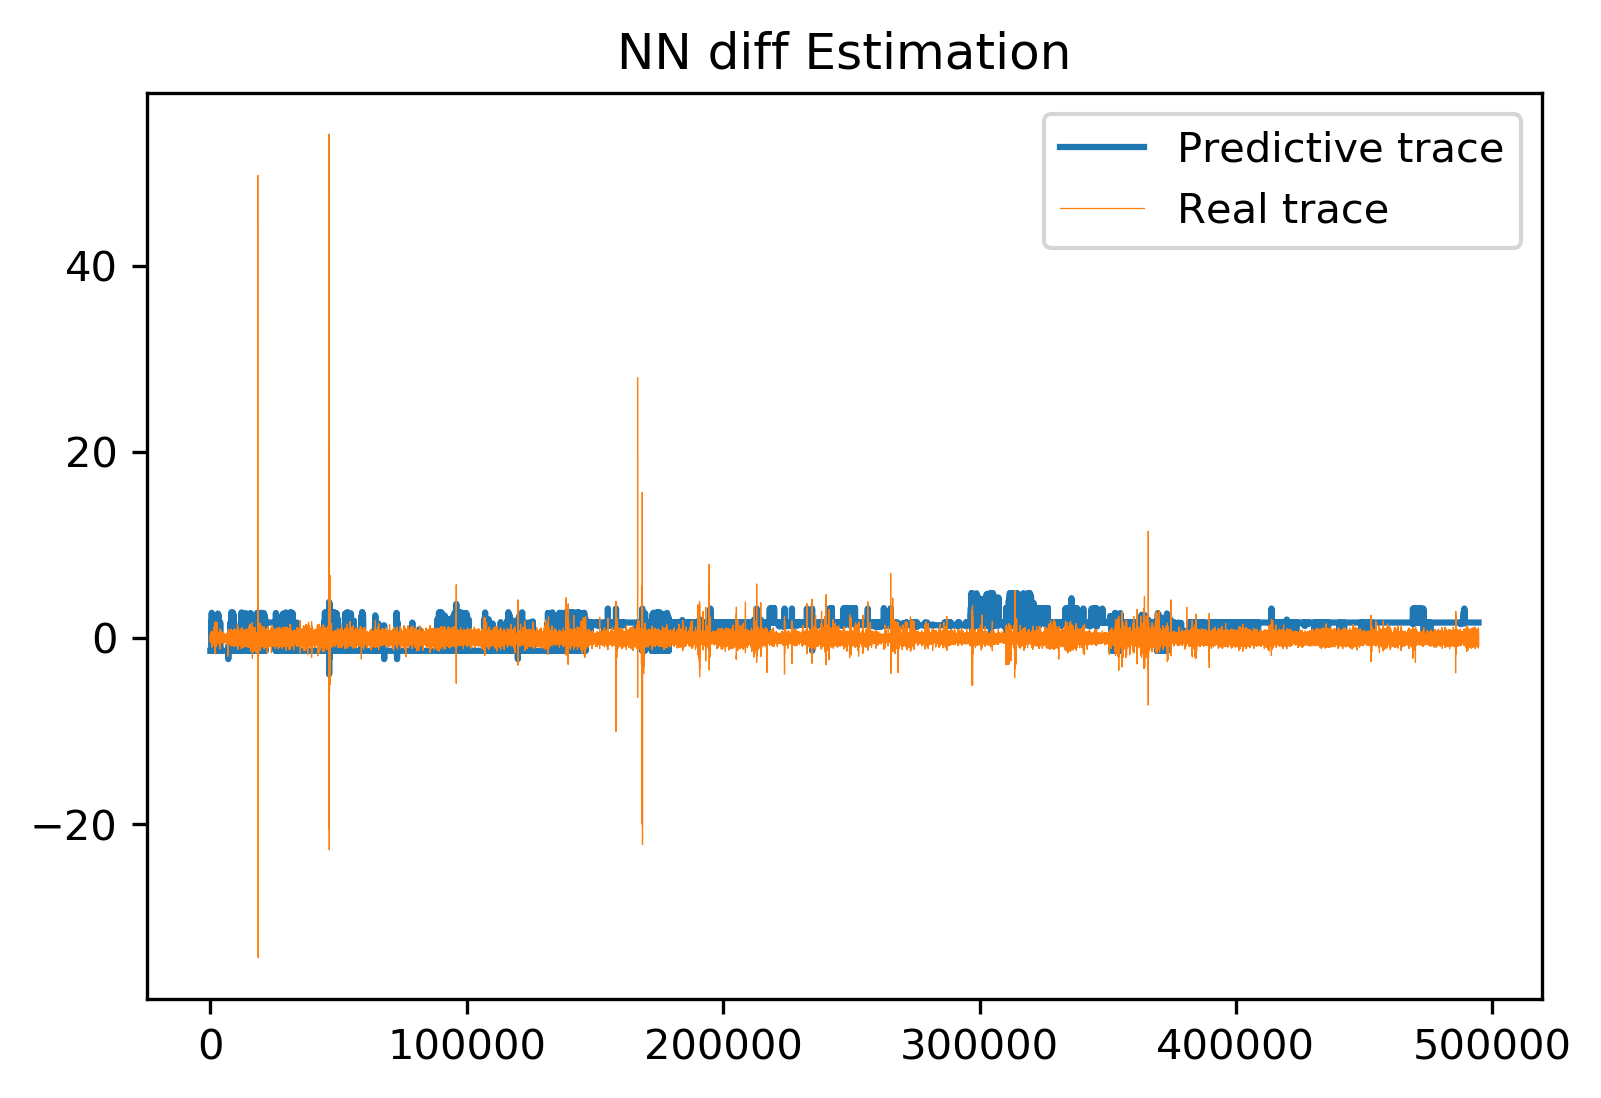

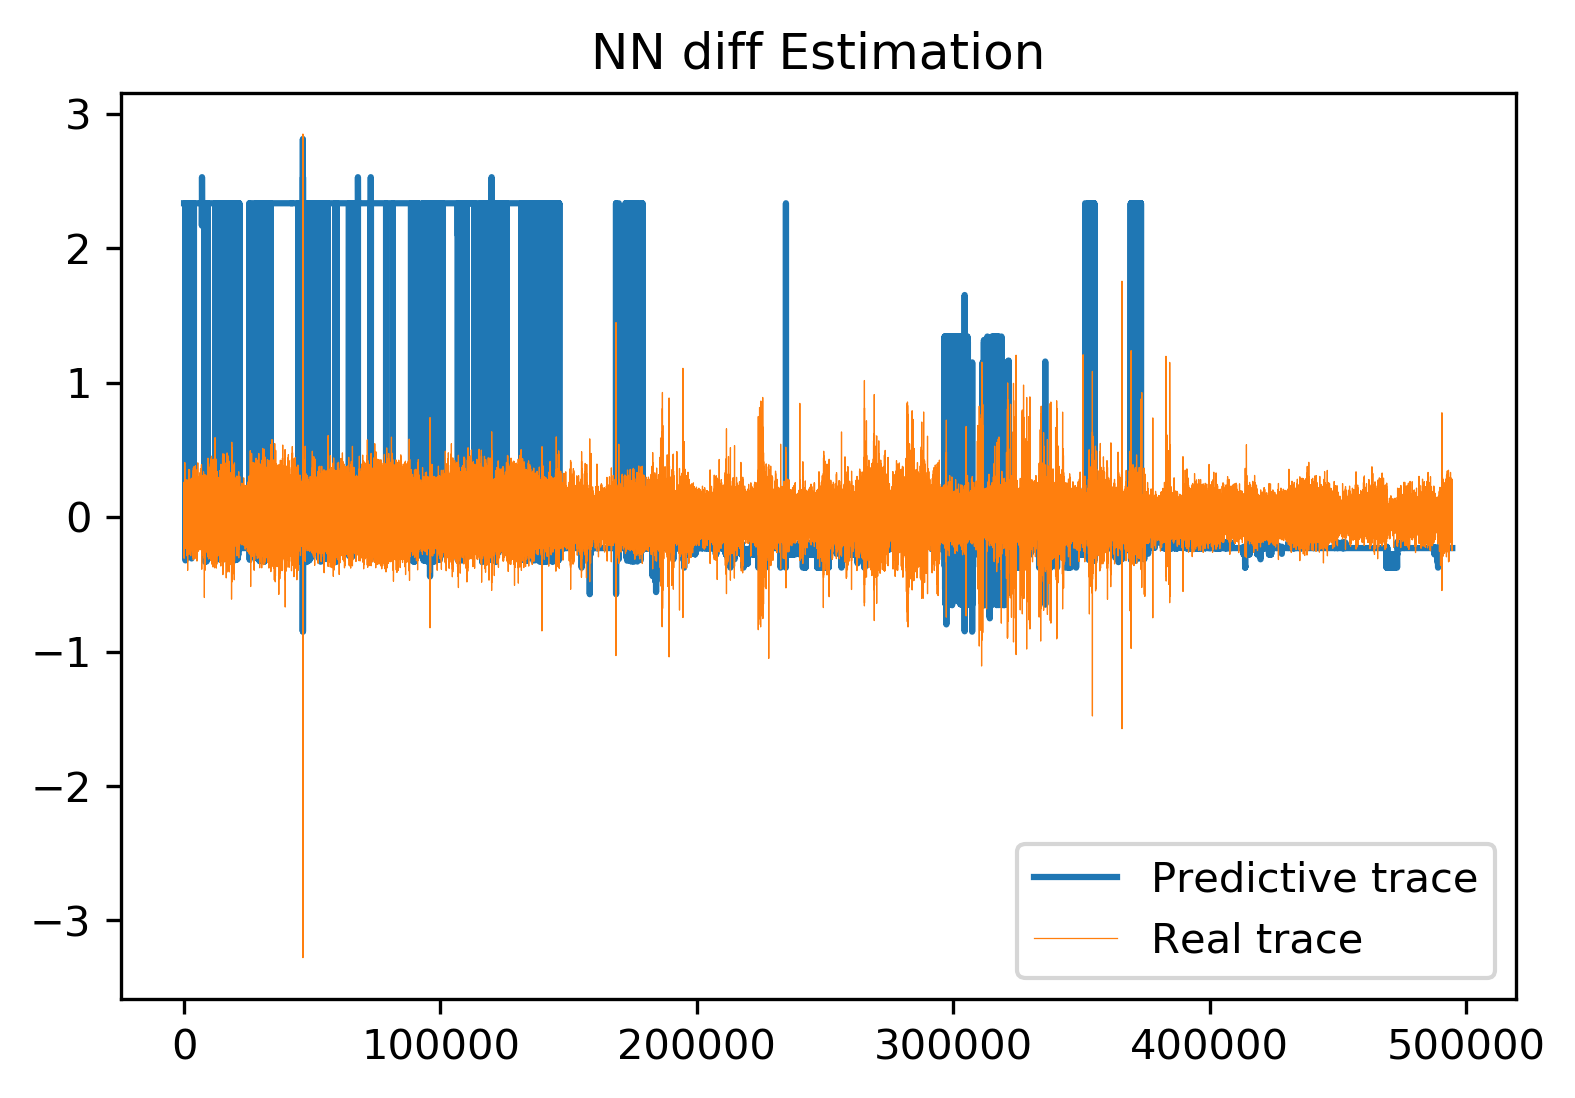

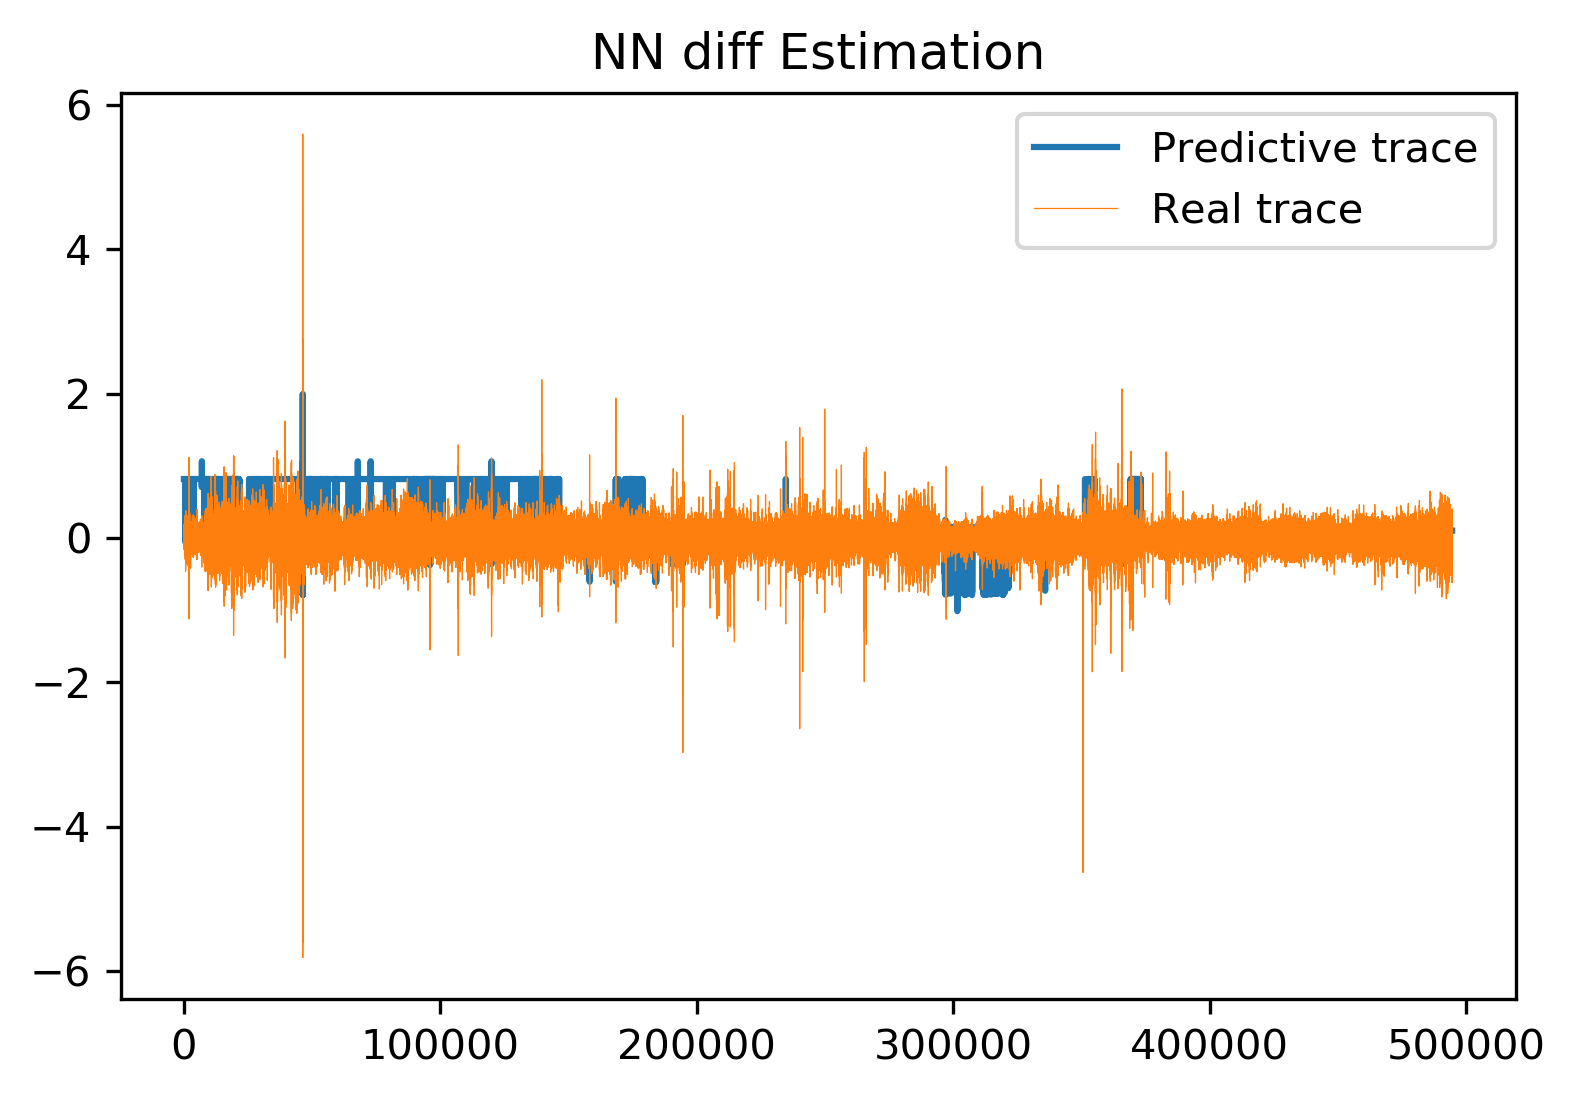

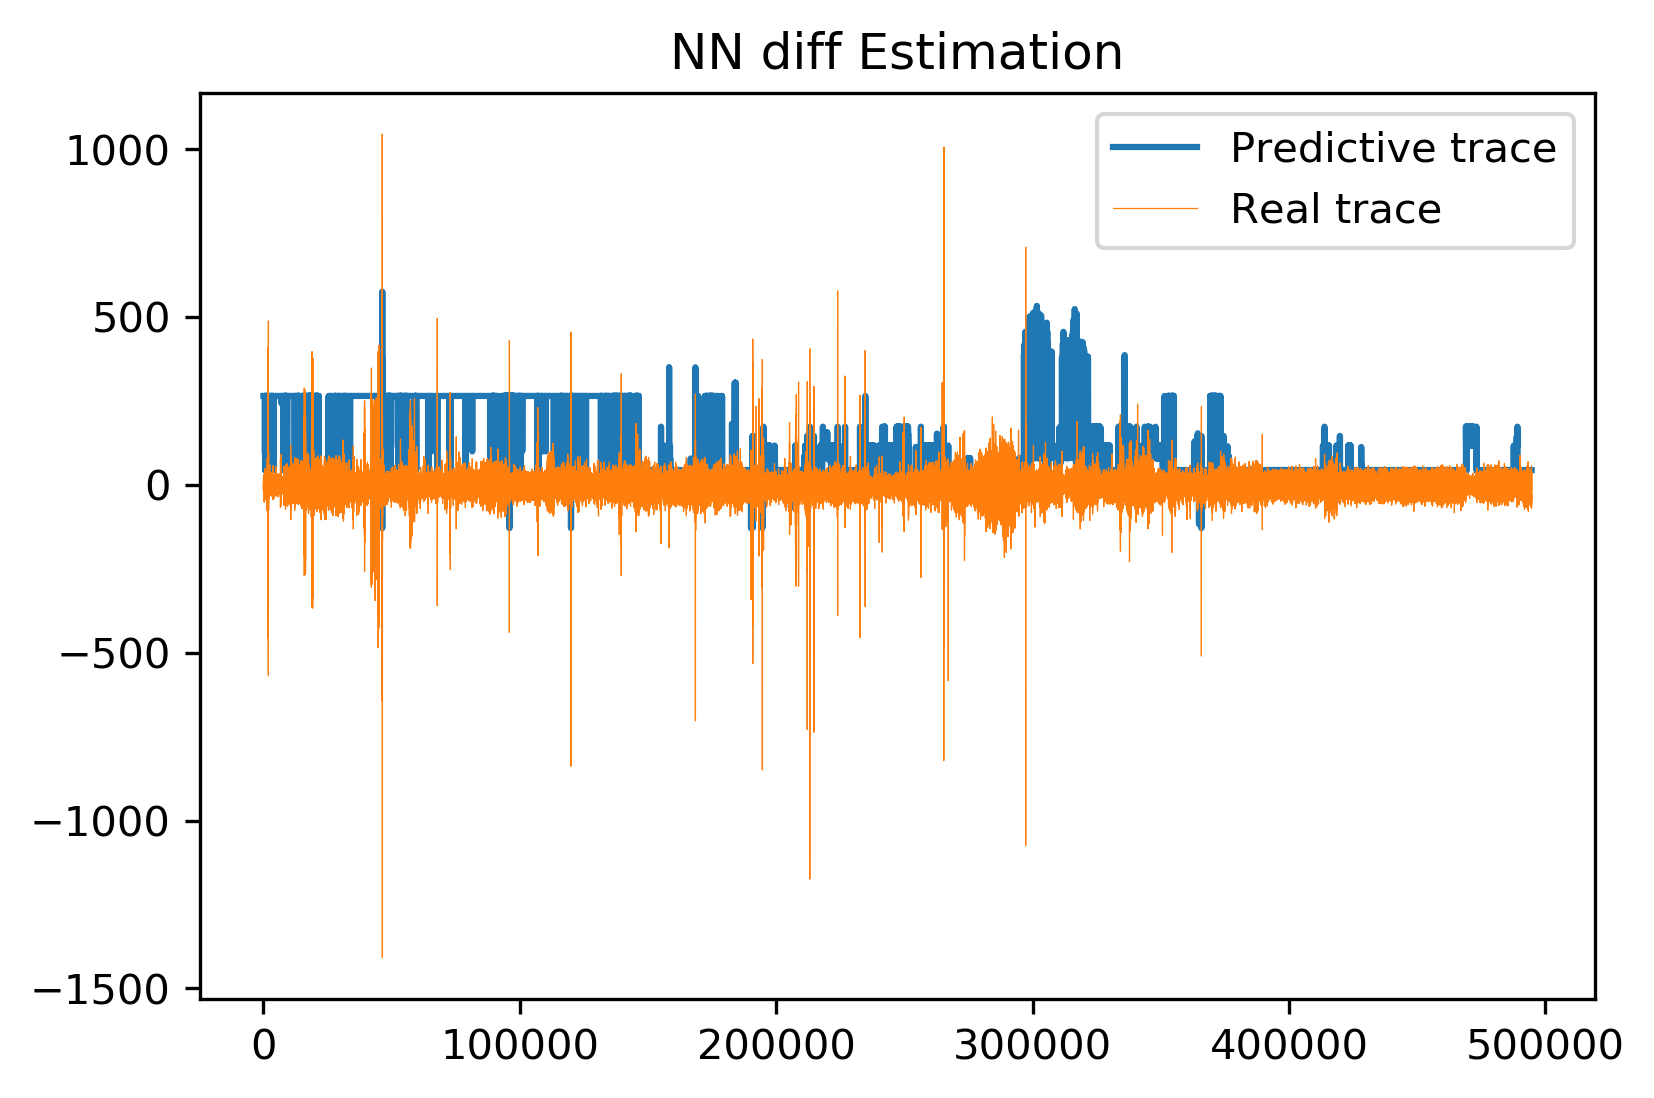

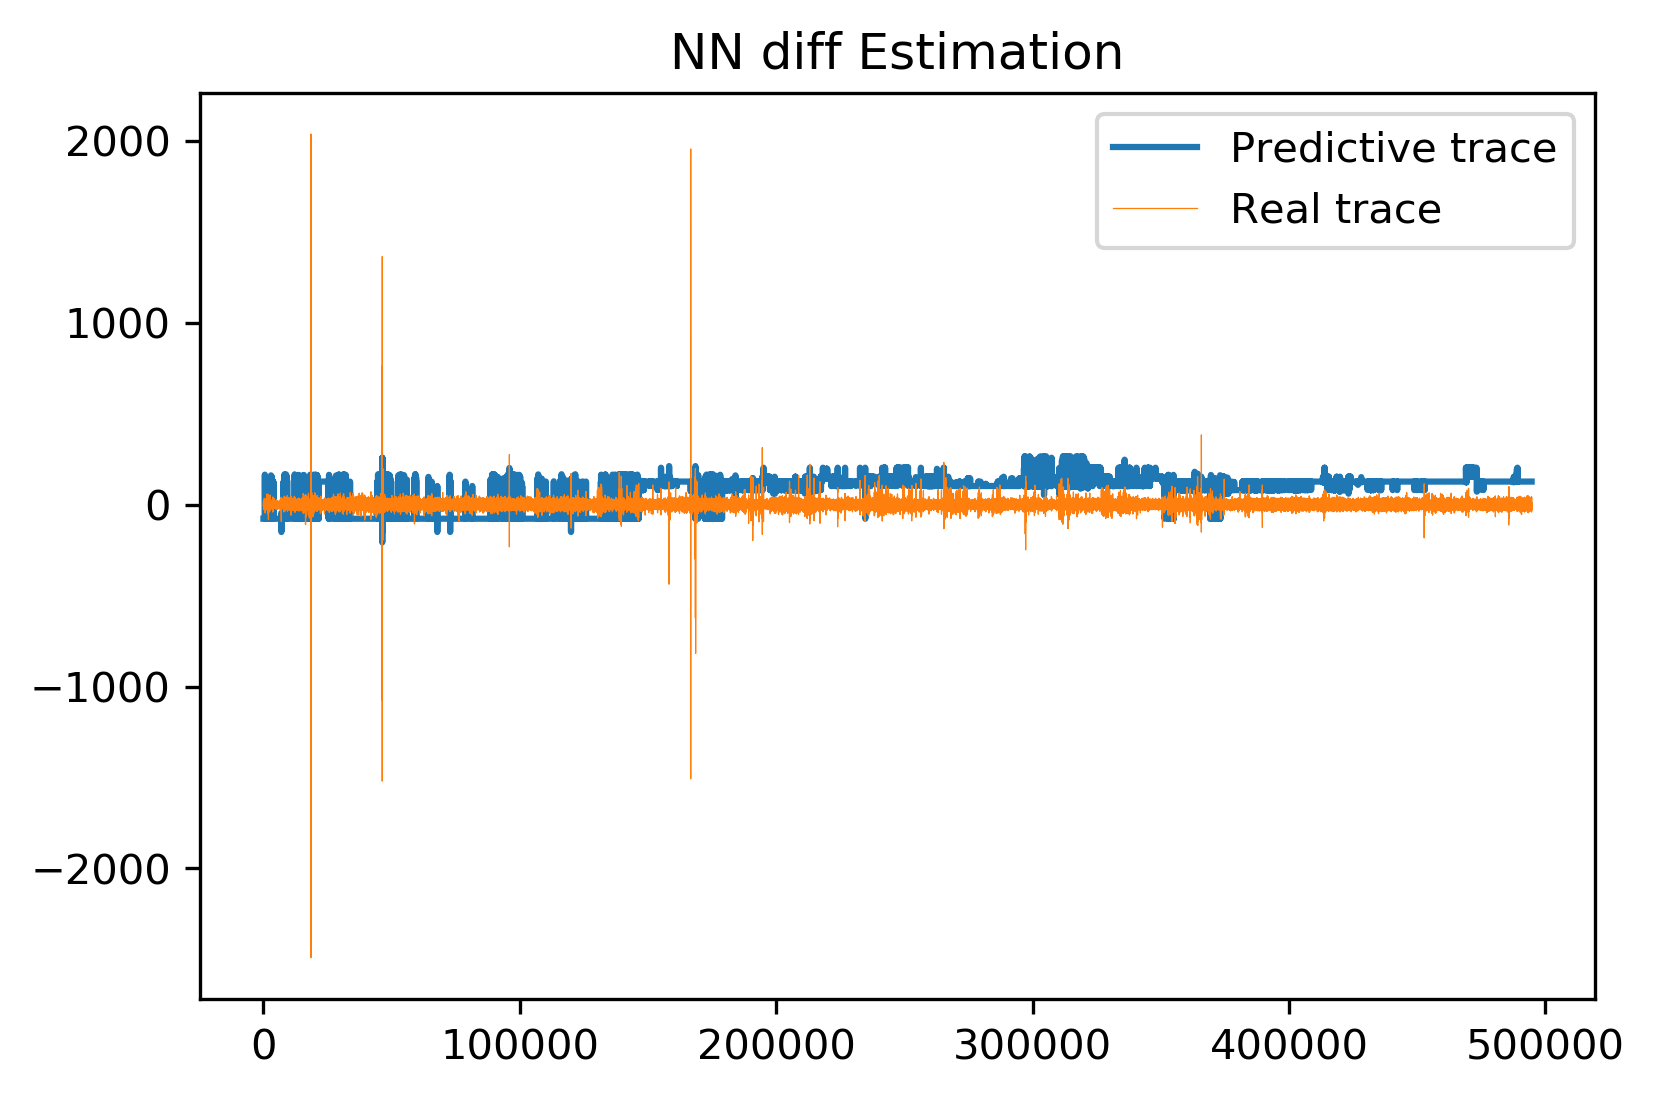

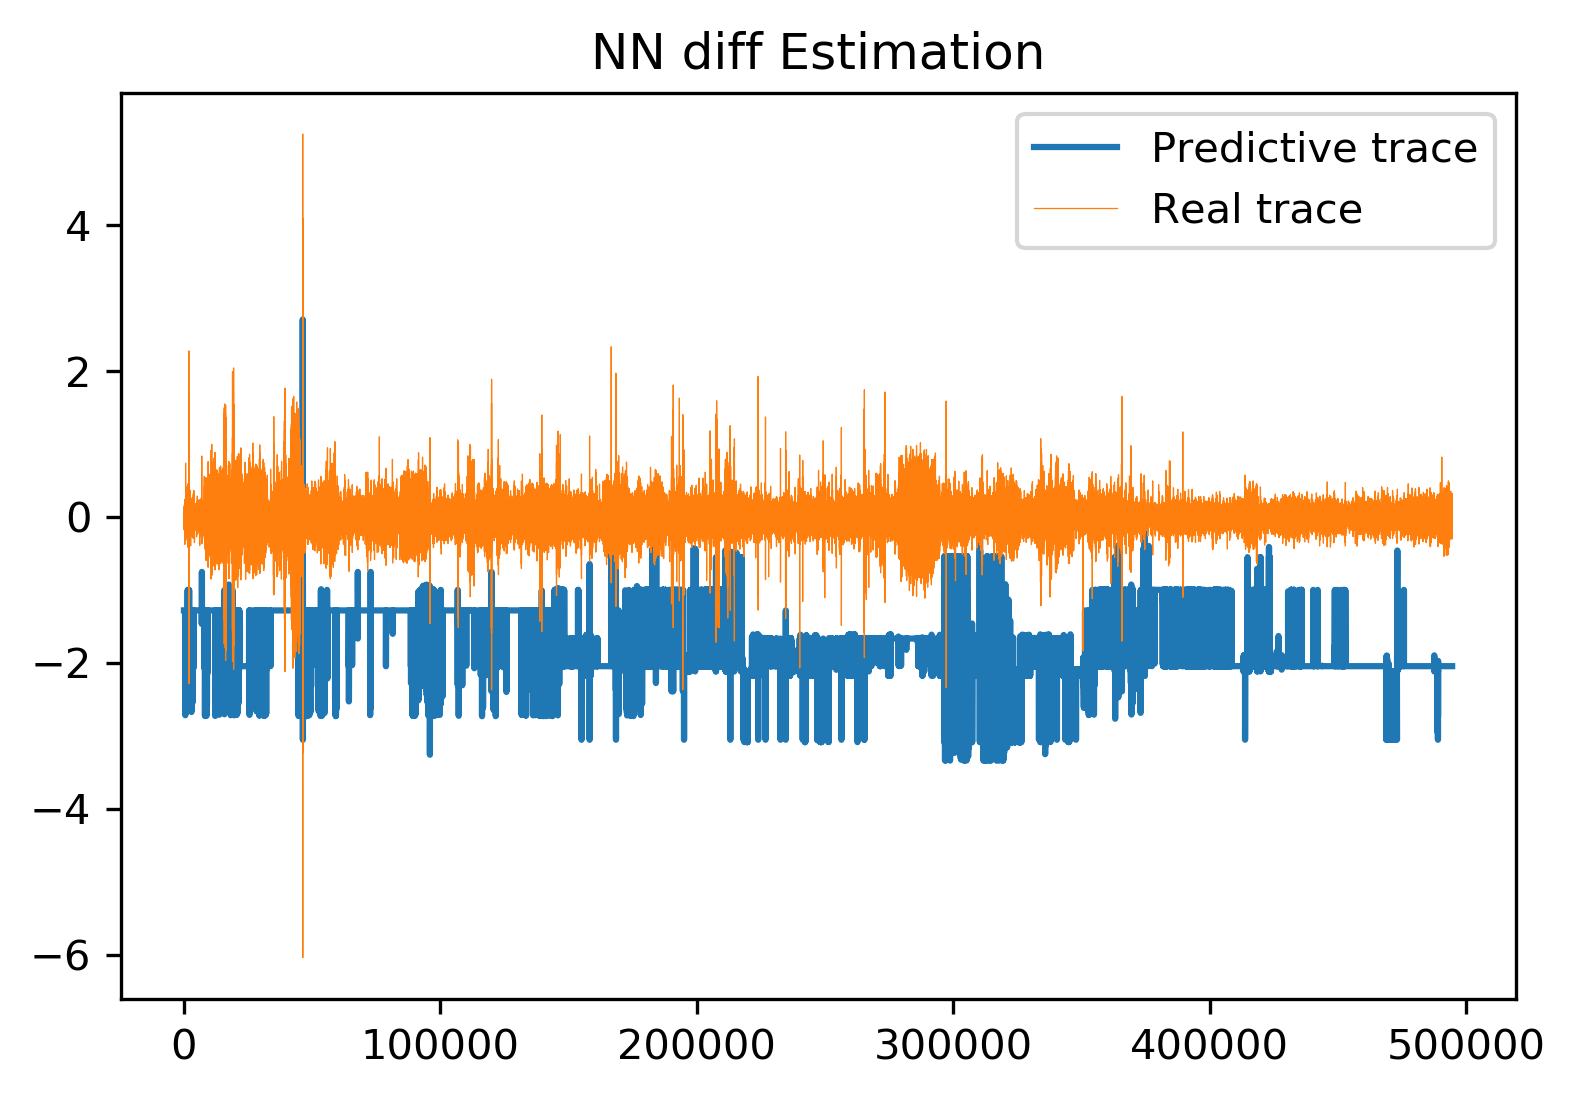

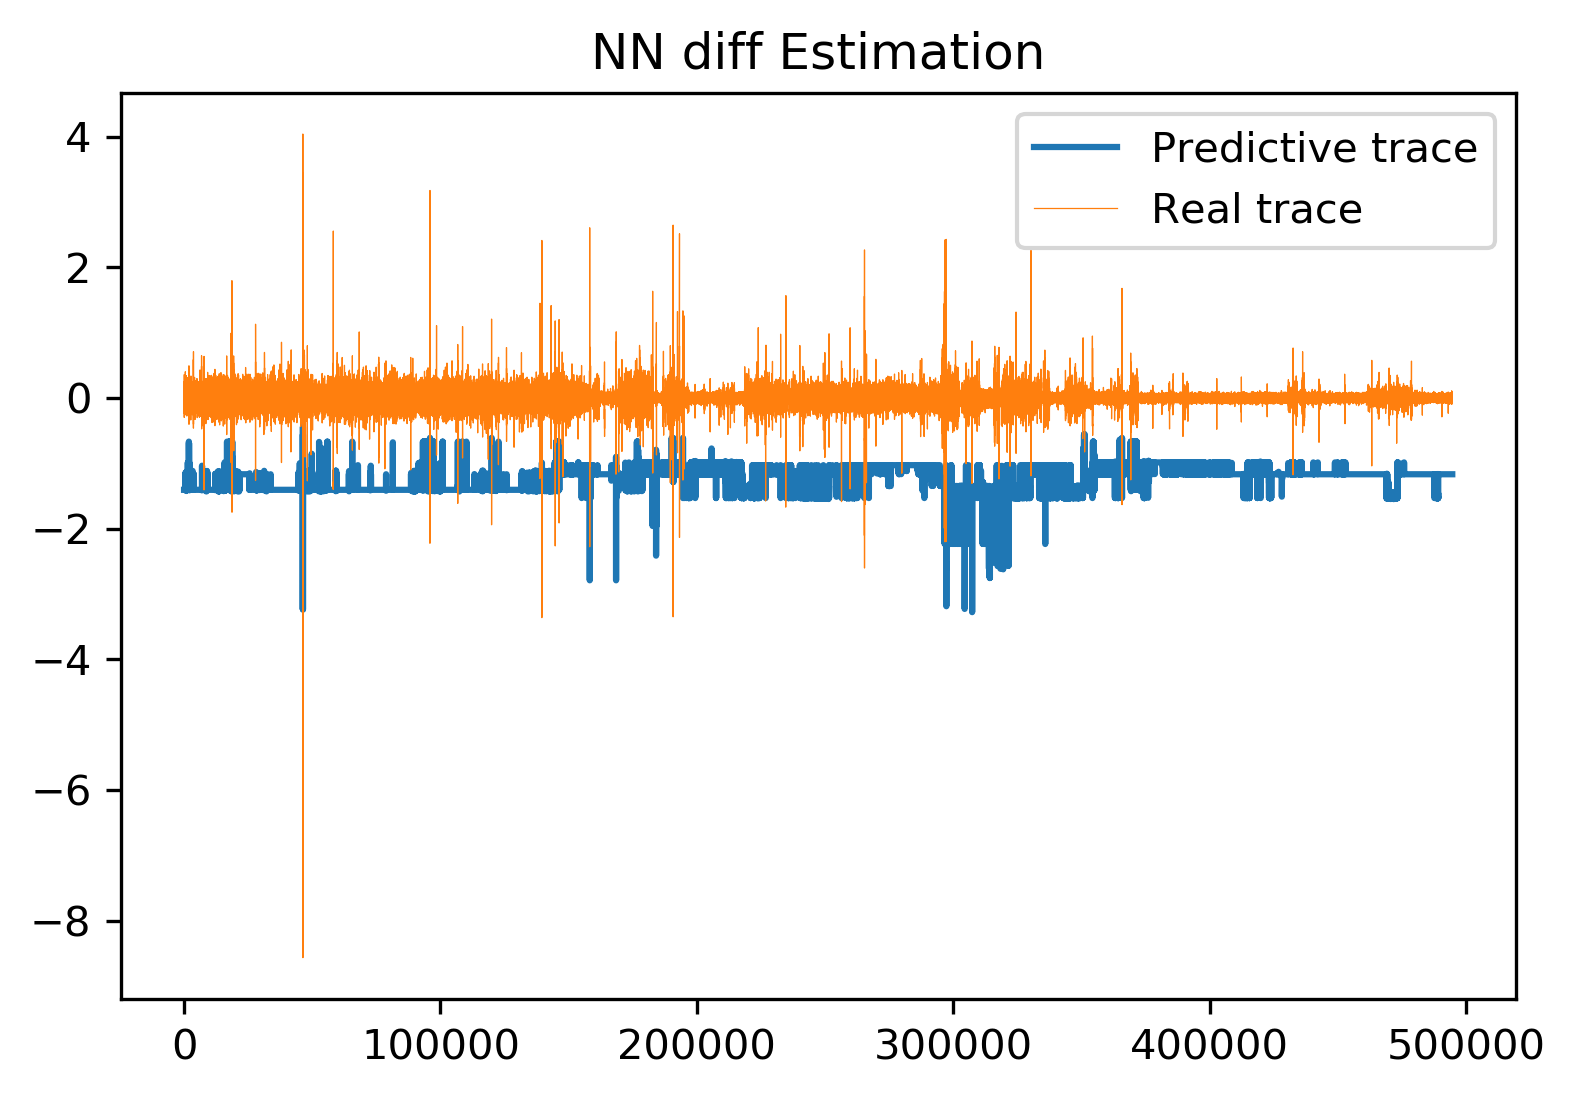

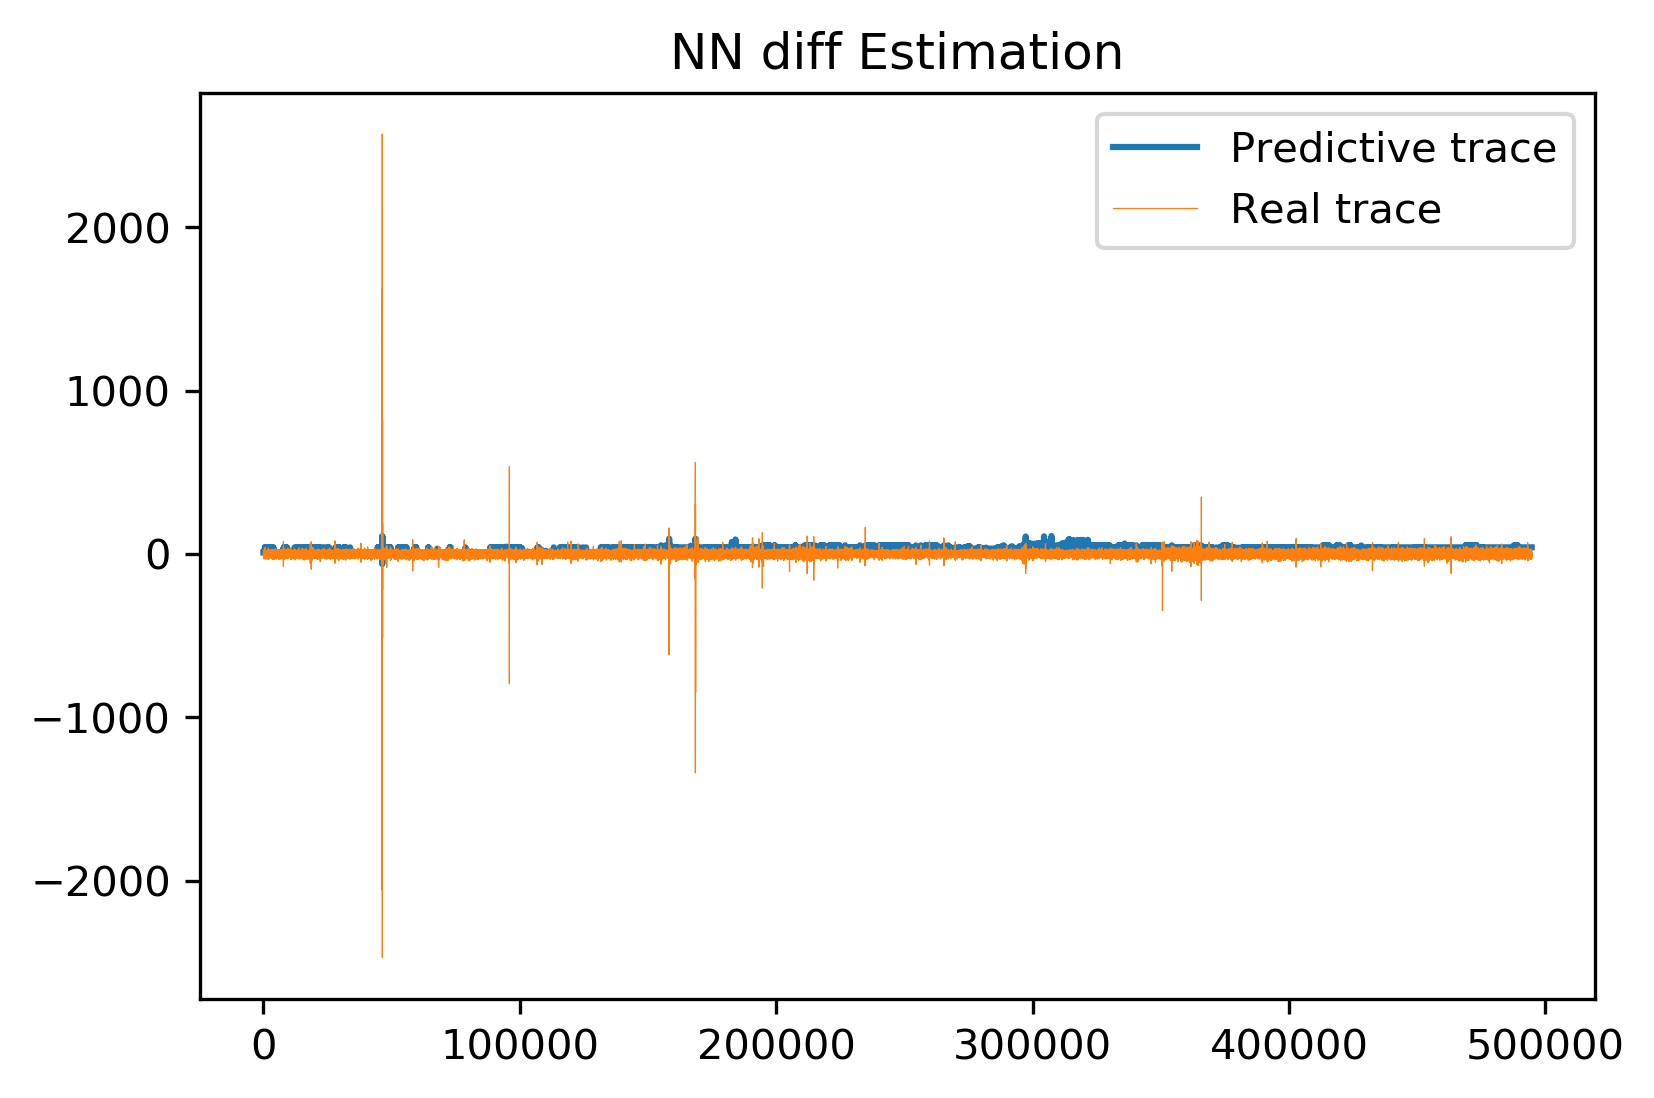

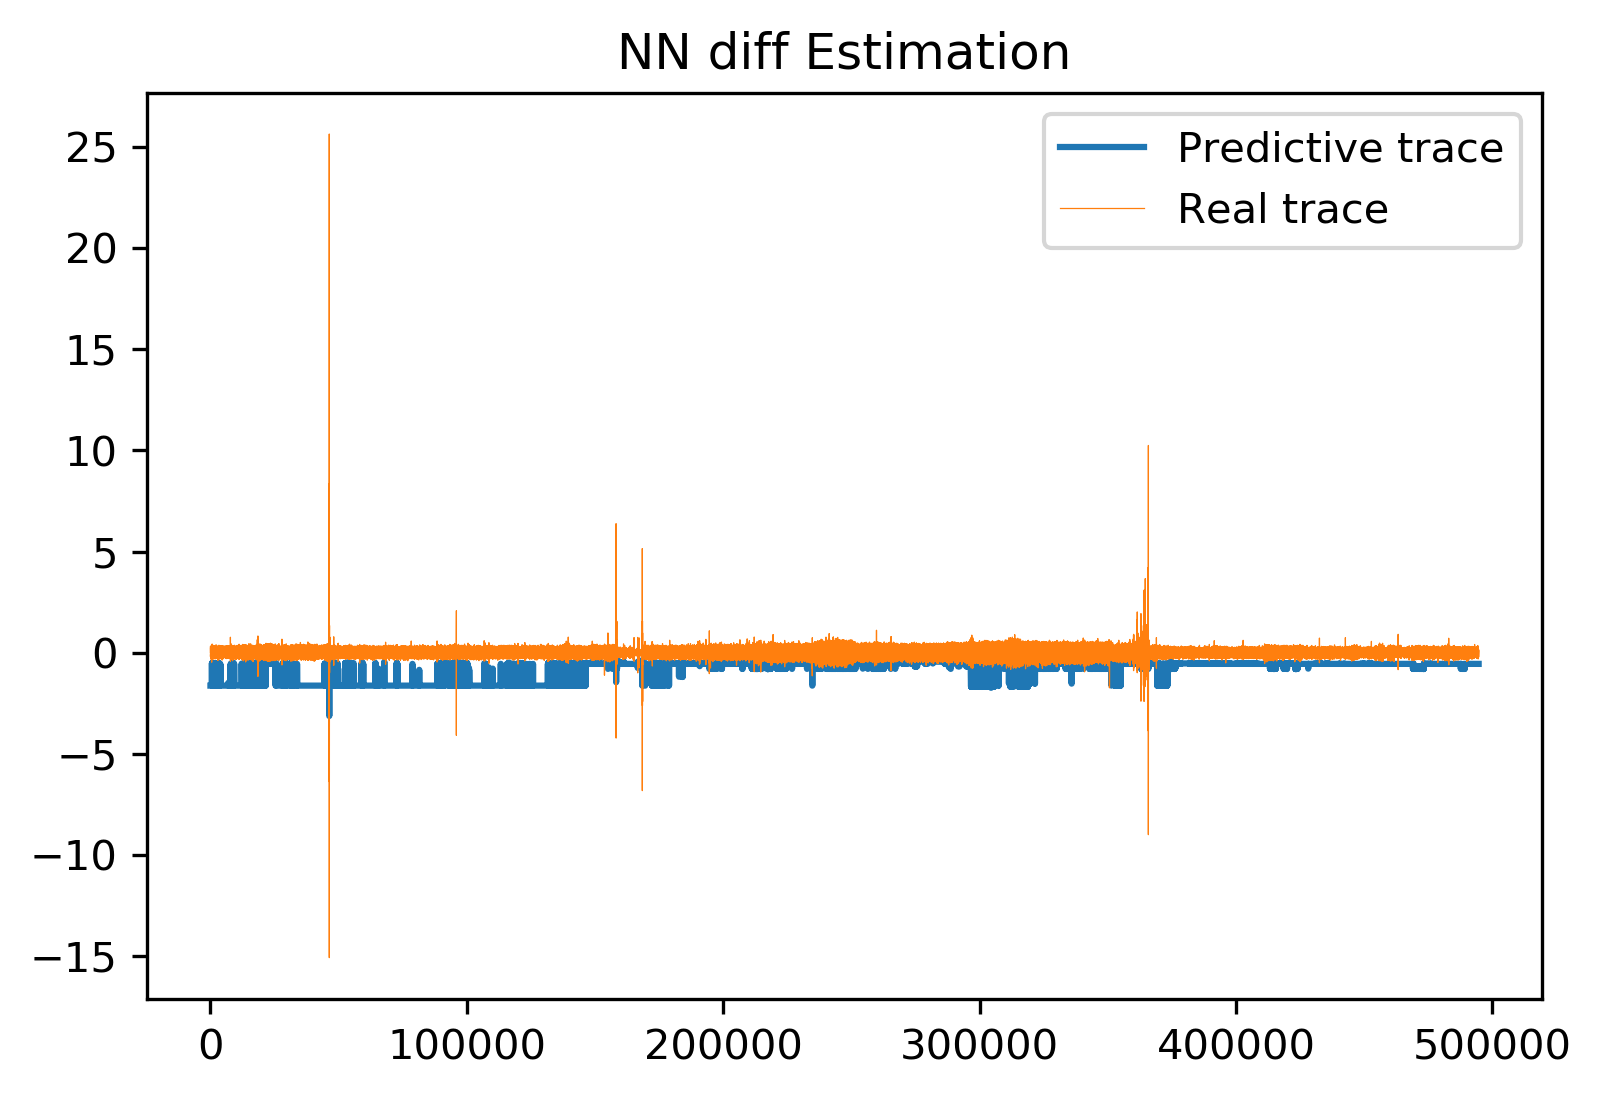

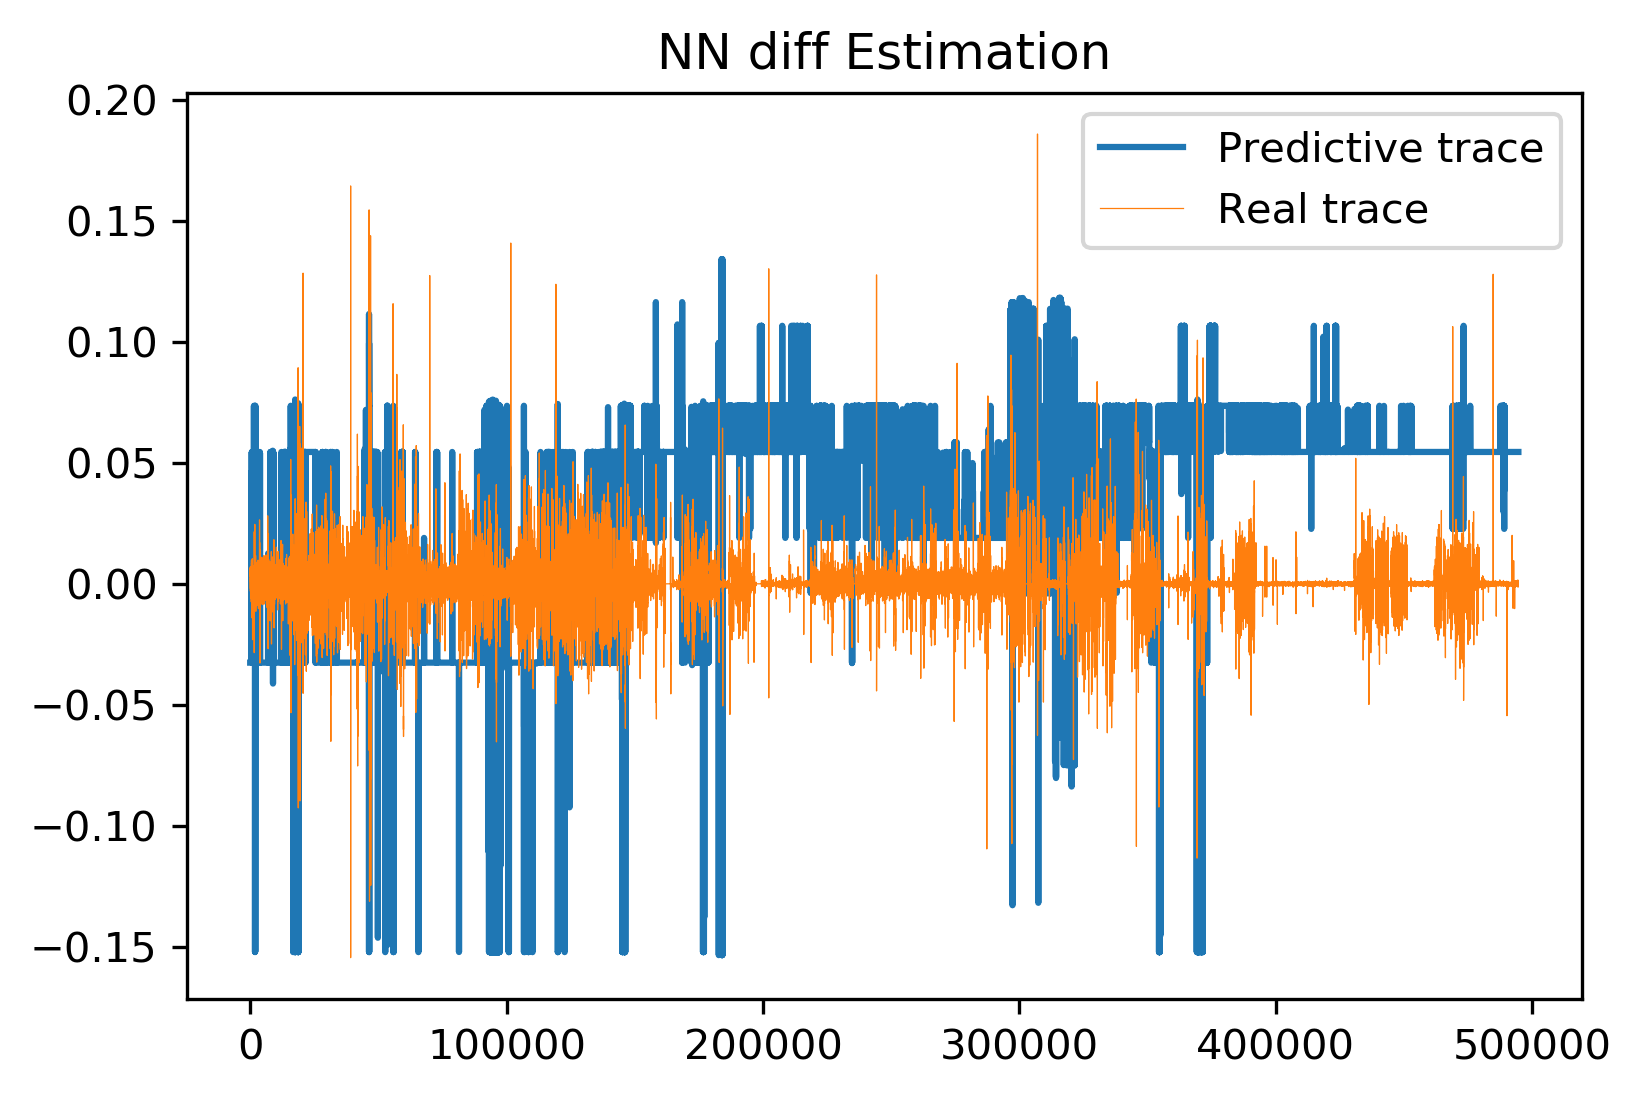

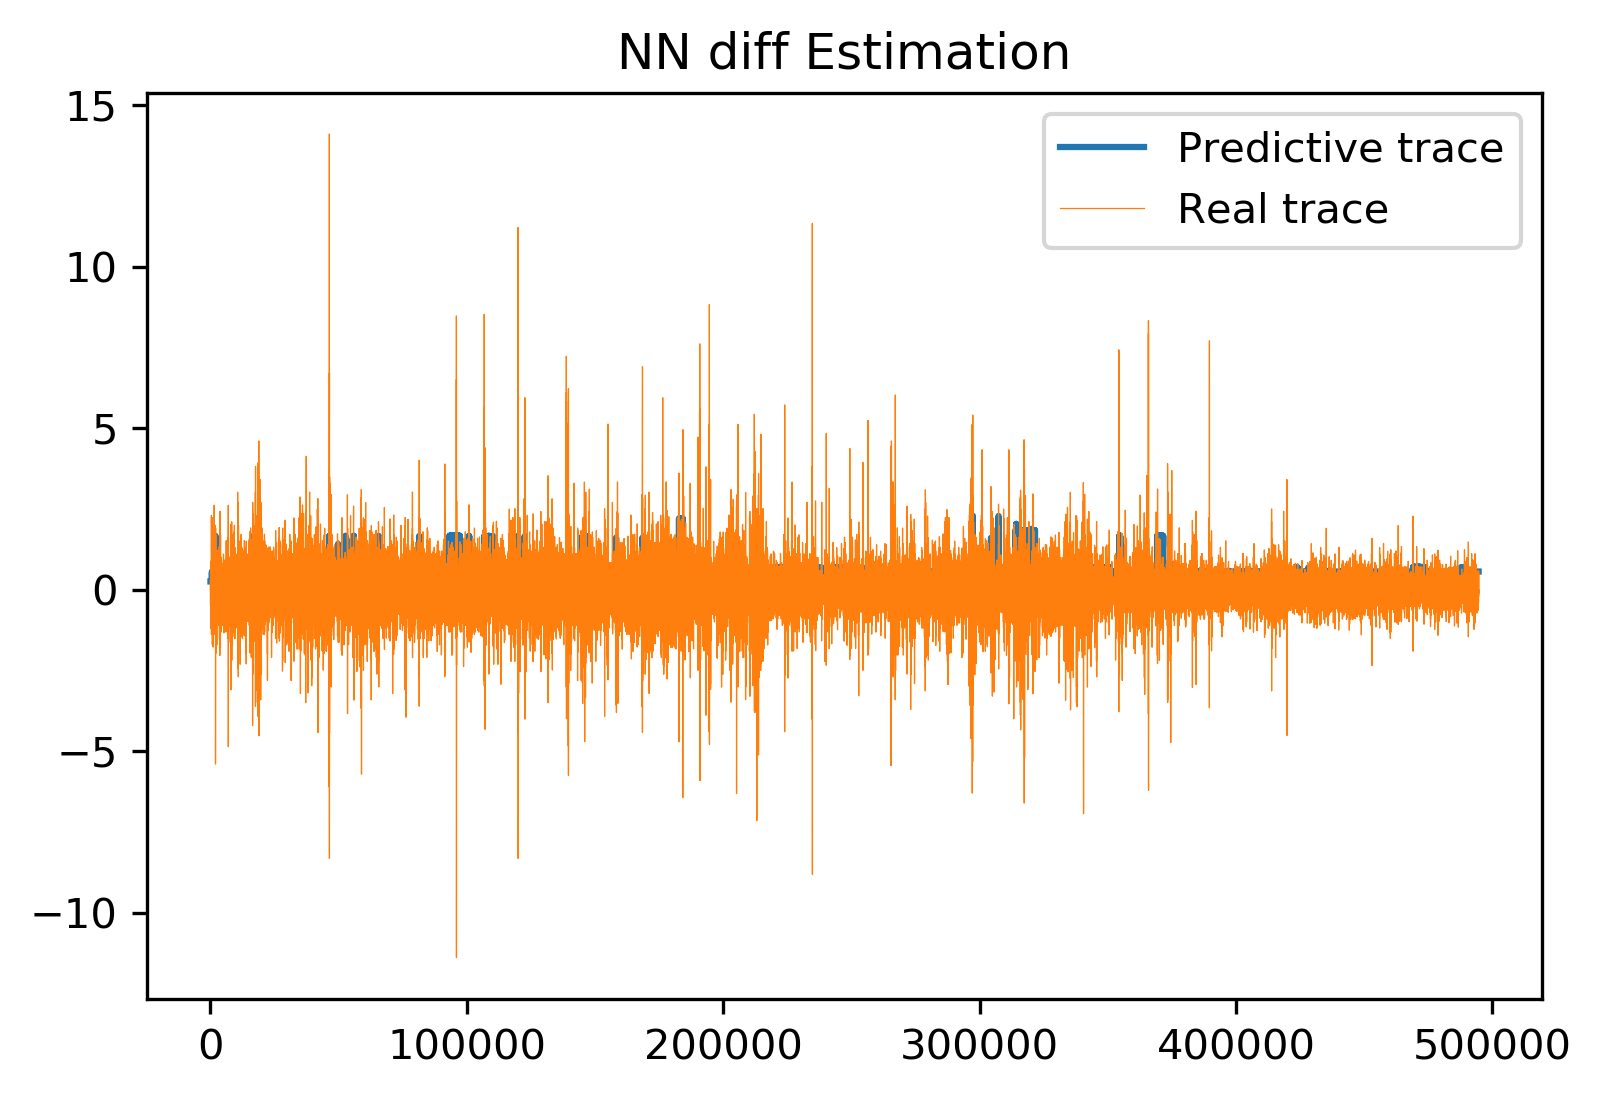

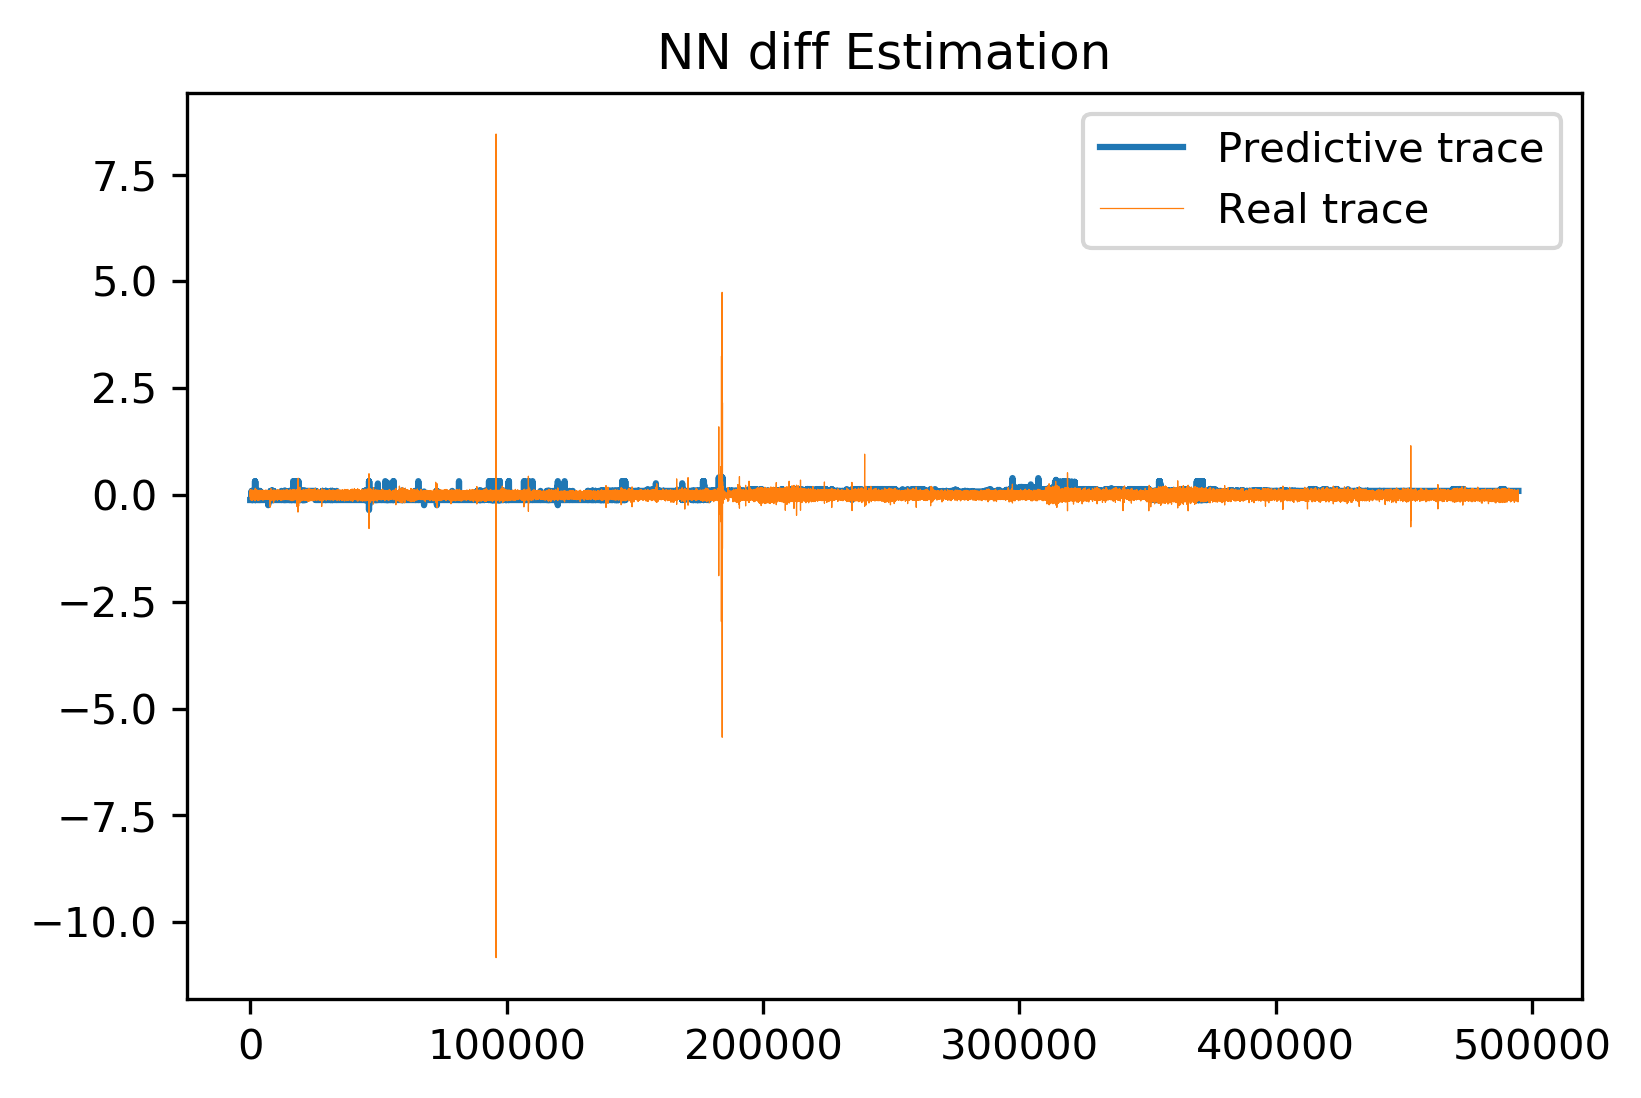

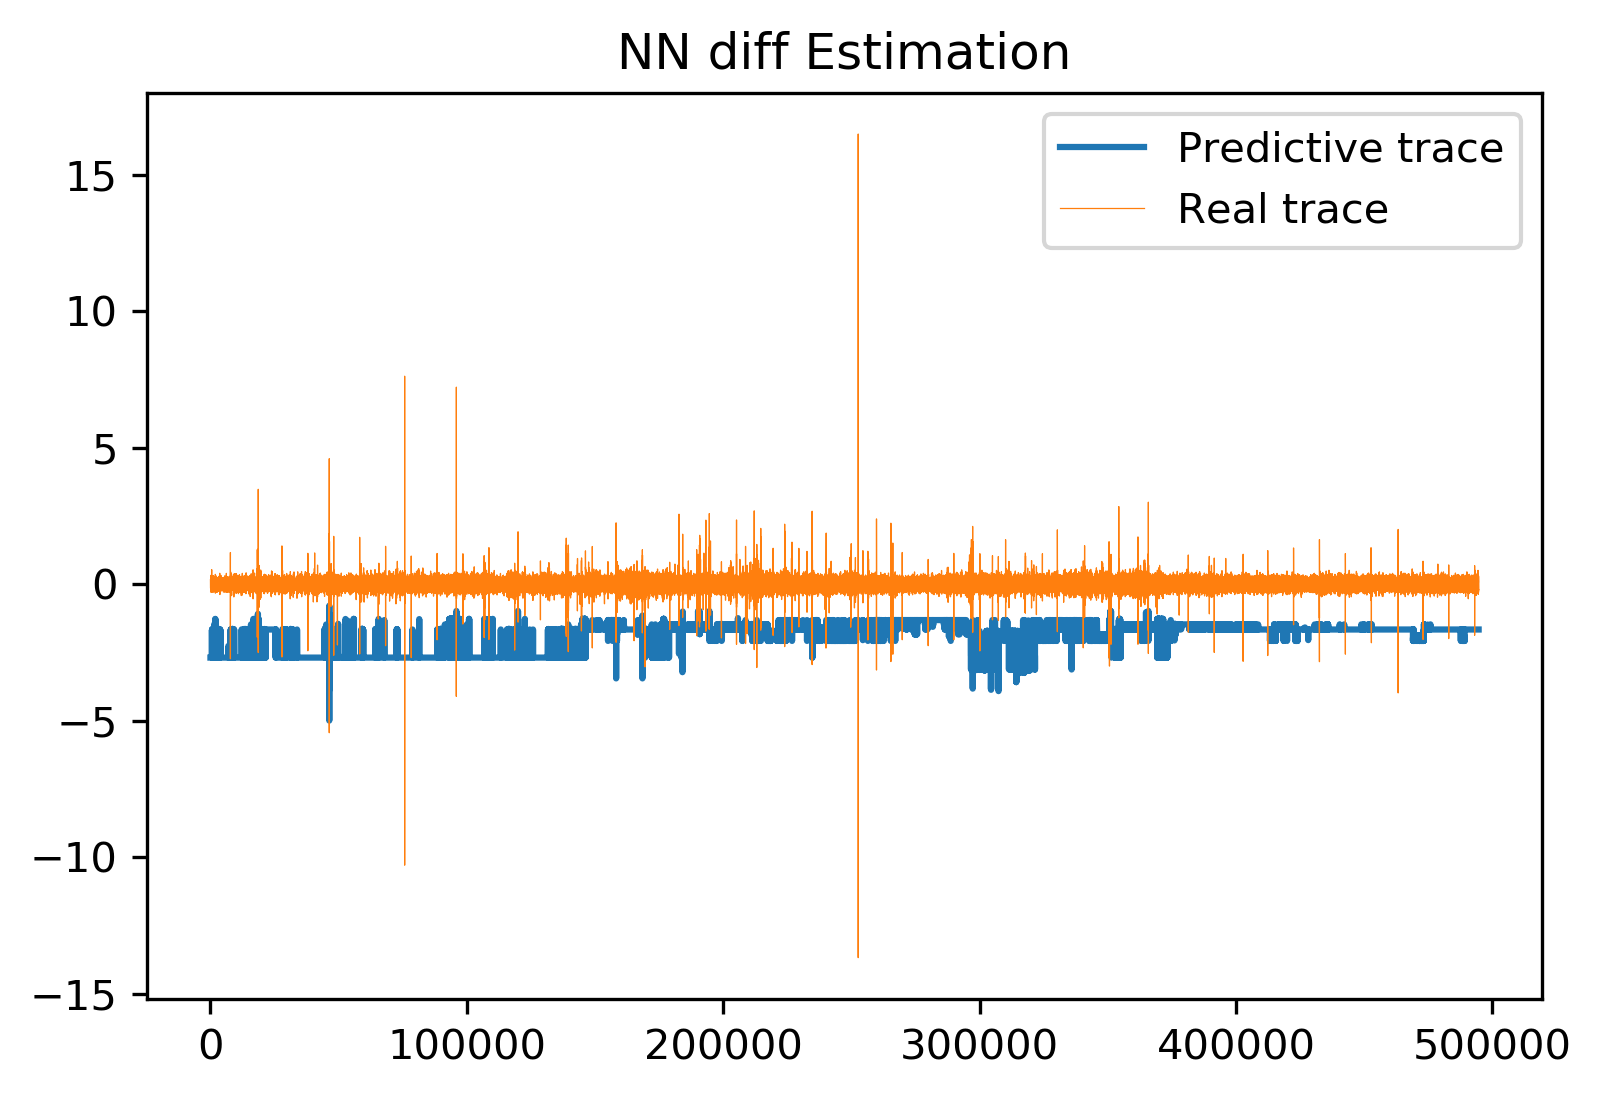

In [108]:
plot_all_traces(predictor_trace=diff_each_step_estimation_nn_trace,real_trace=state_diff,title="NN diff Estimation")

## Gradient Boost one step estimation

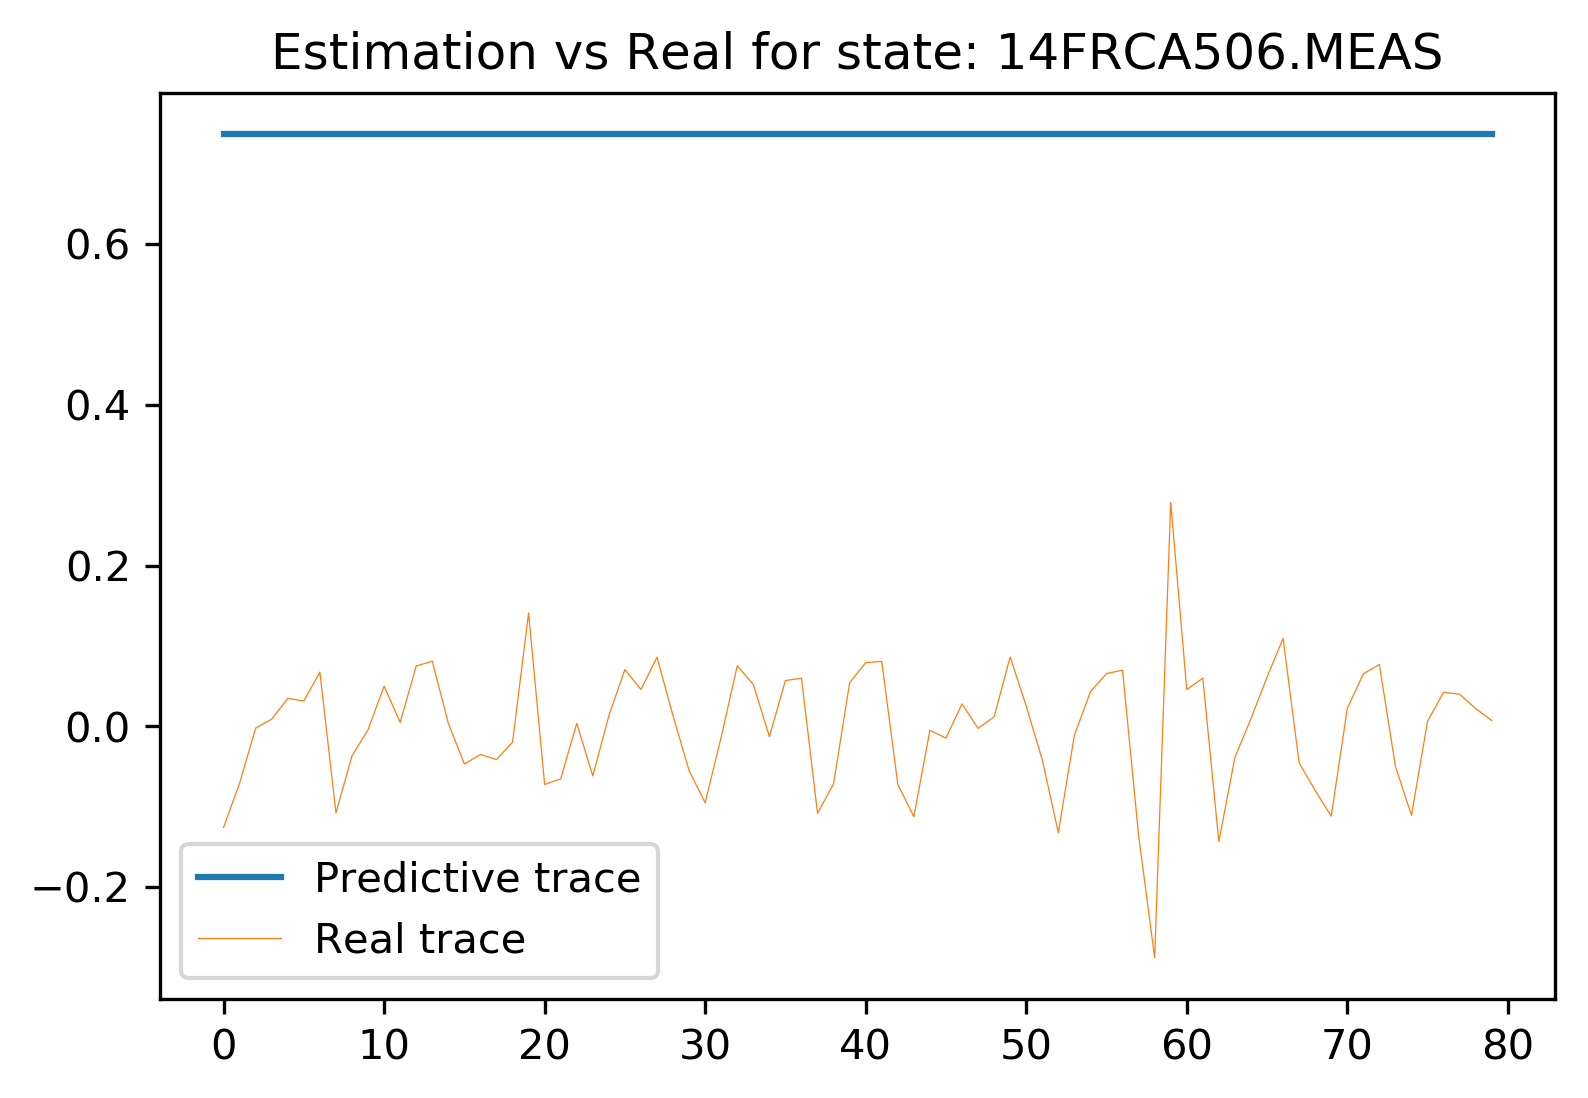

In [120]:
column=5
ini_obs=100000
num_obs=80
#num_obs=494624
state=state_names[column]
plot_title=('GB Estimation vs Real state:%s'%state)
plot_results(estimate_trace=diff_each_step_estimation_gb_trace[ini_obs:ini_obs+num_obs,column],real_trace=state_diff[ini_obs:ini_obs+num_obs,column],title=plot_title)

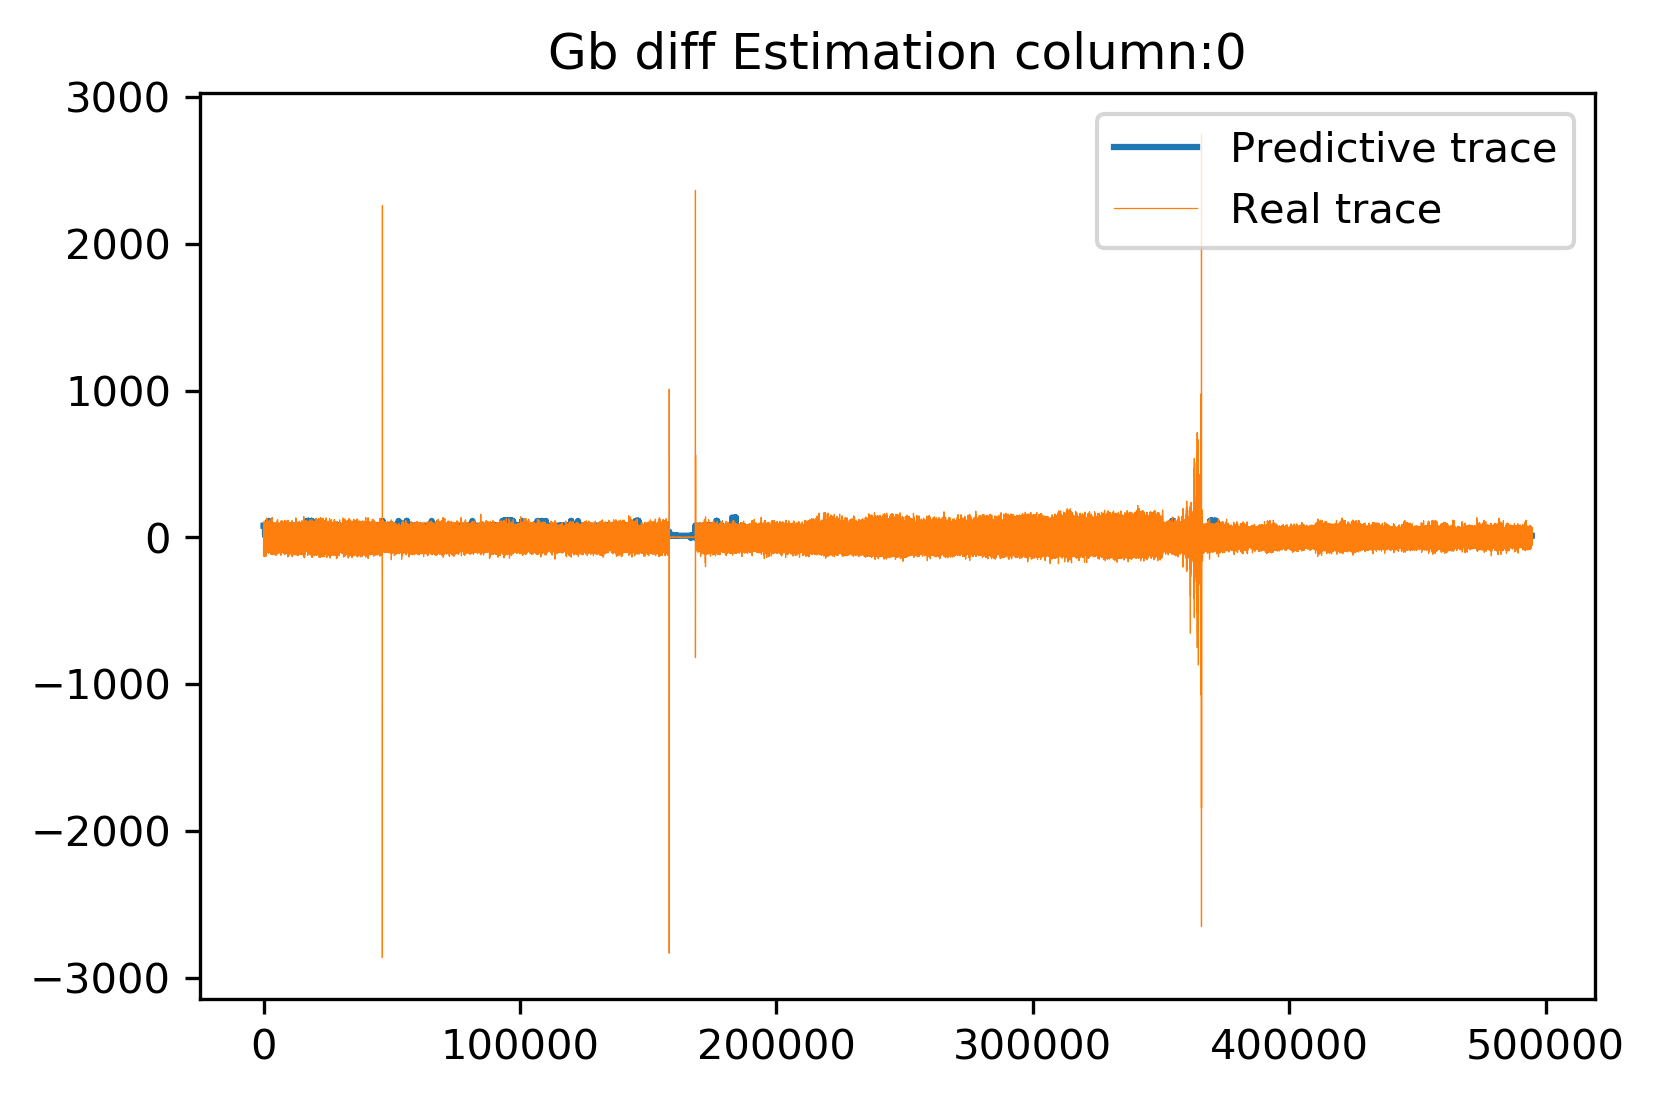

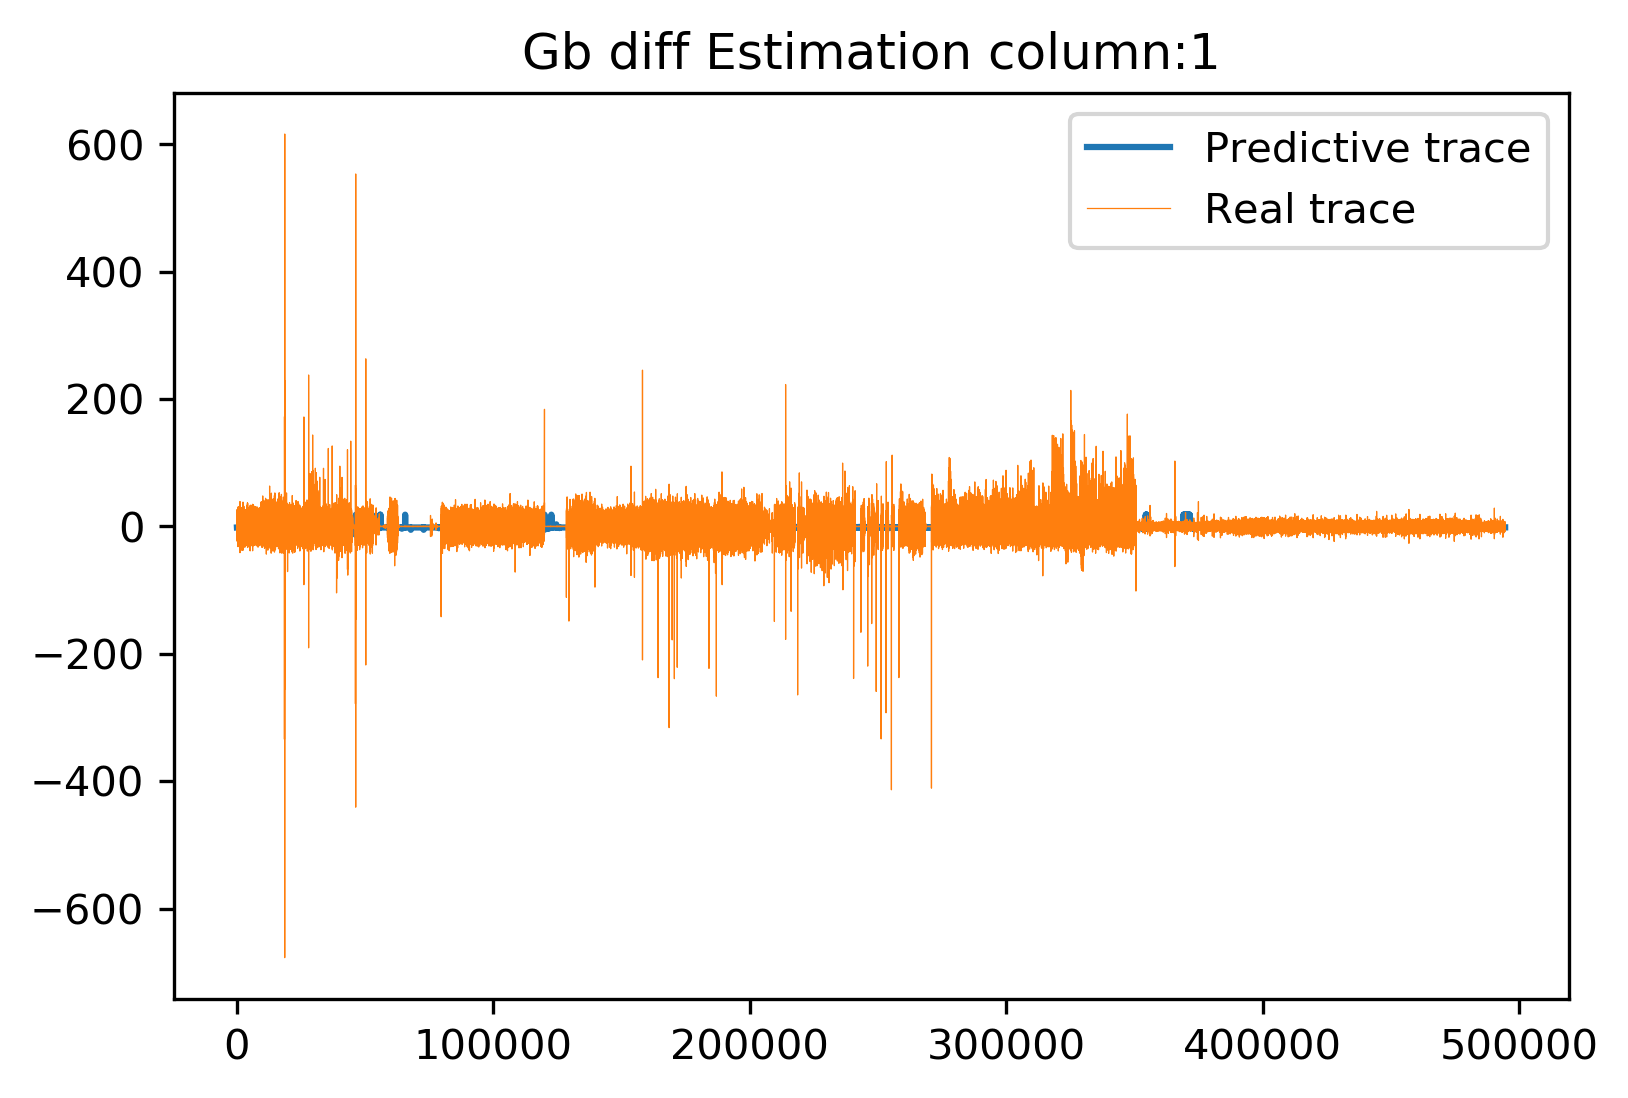

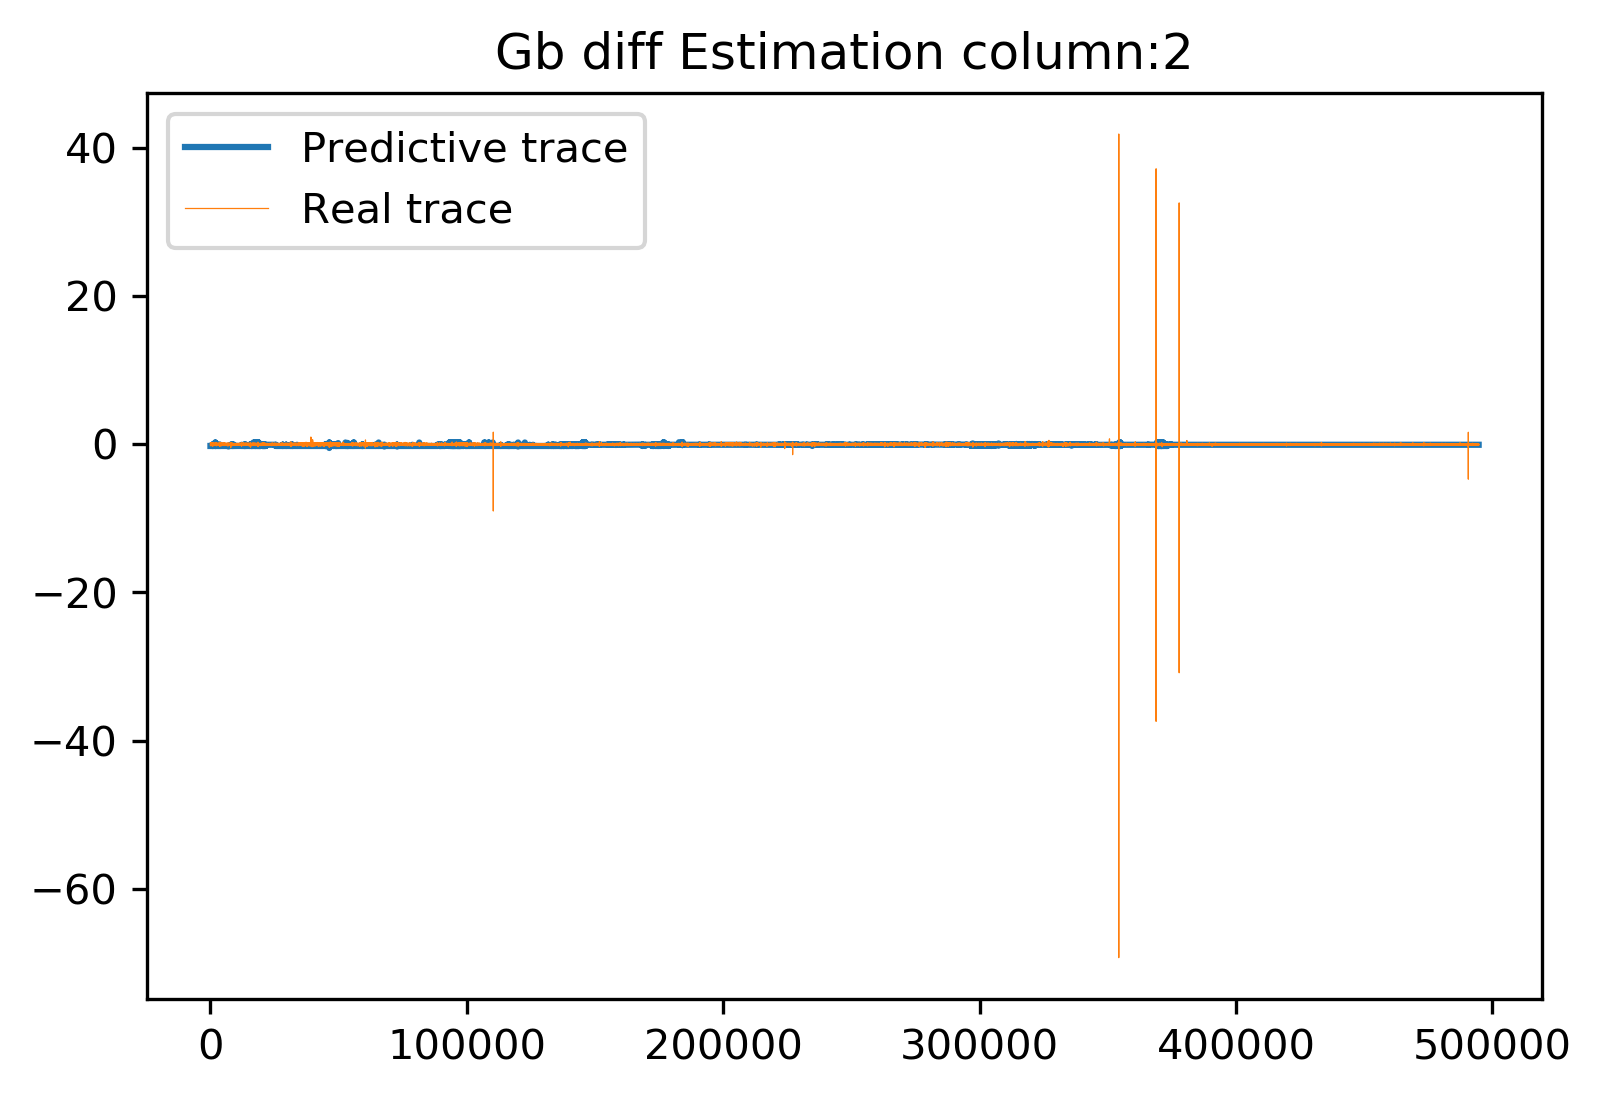

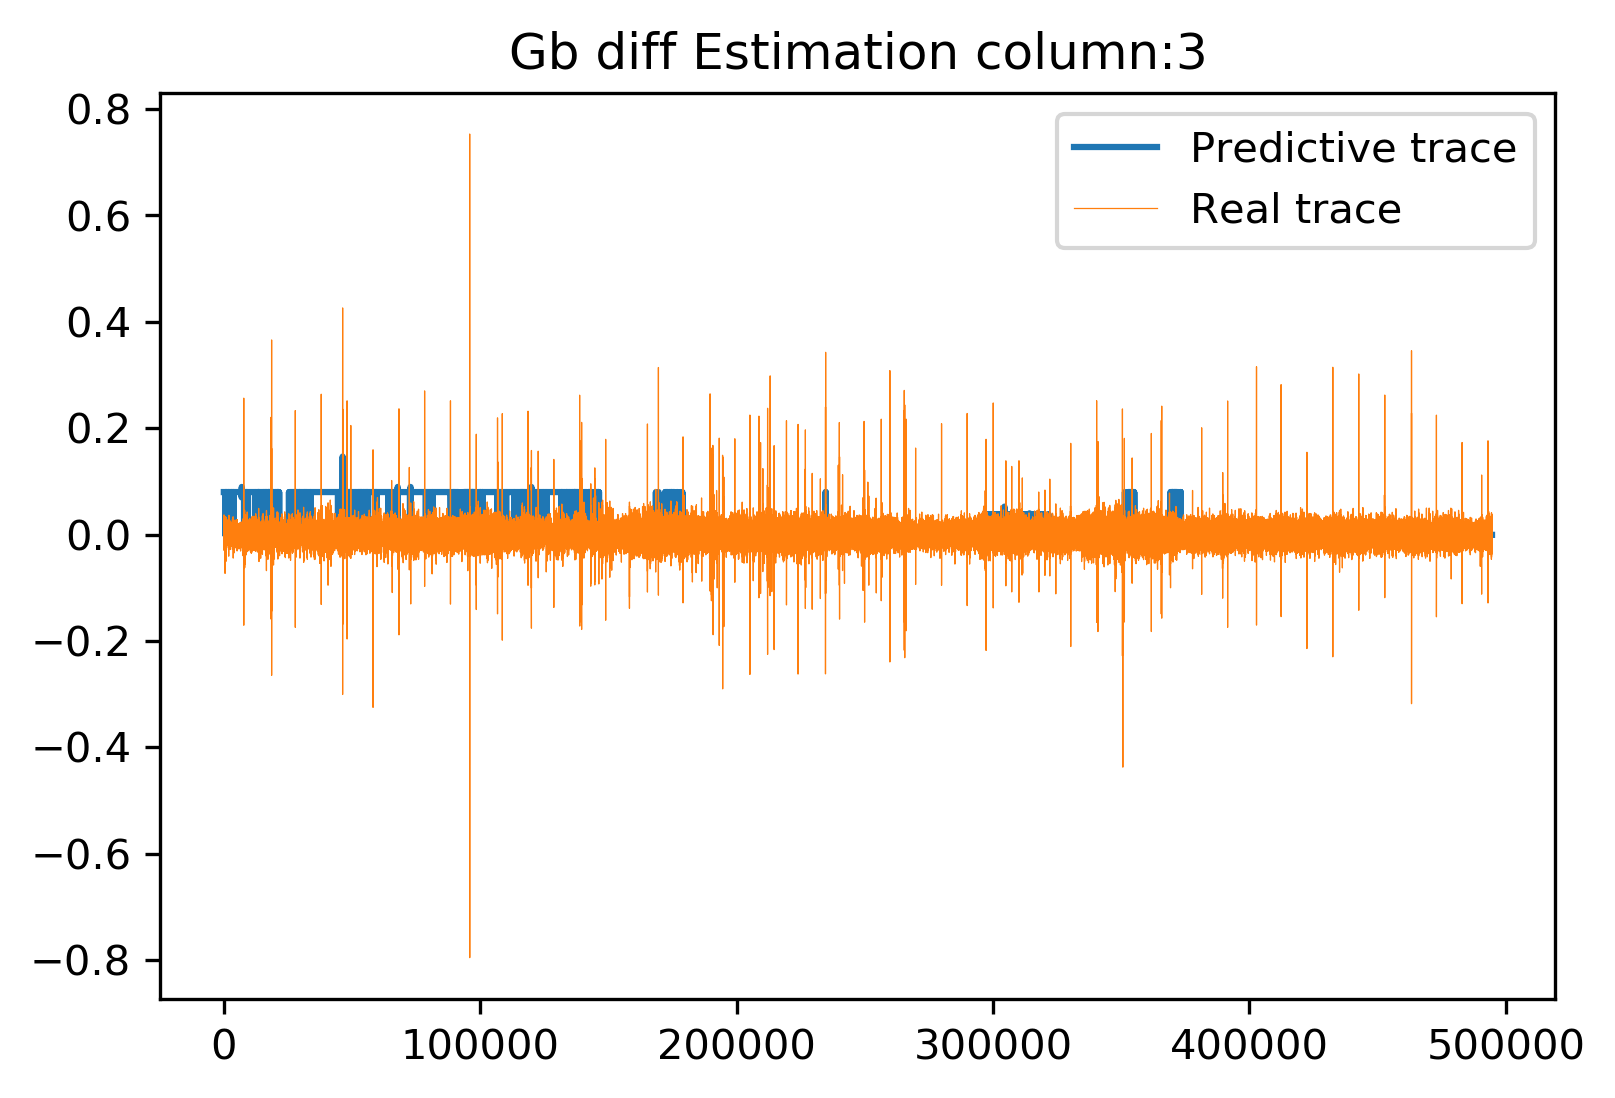

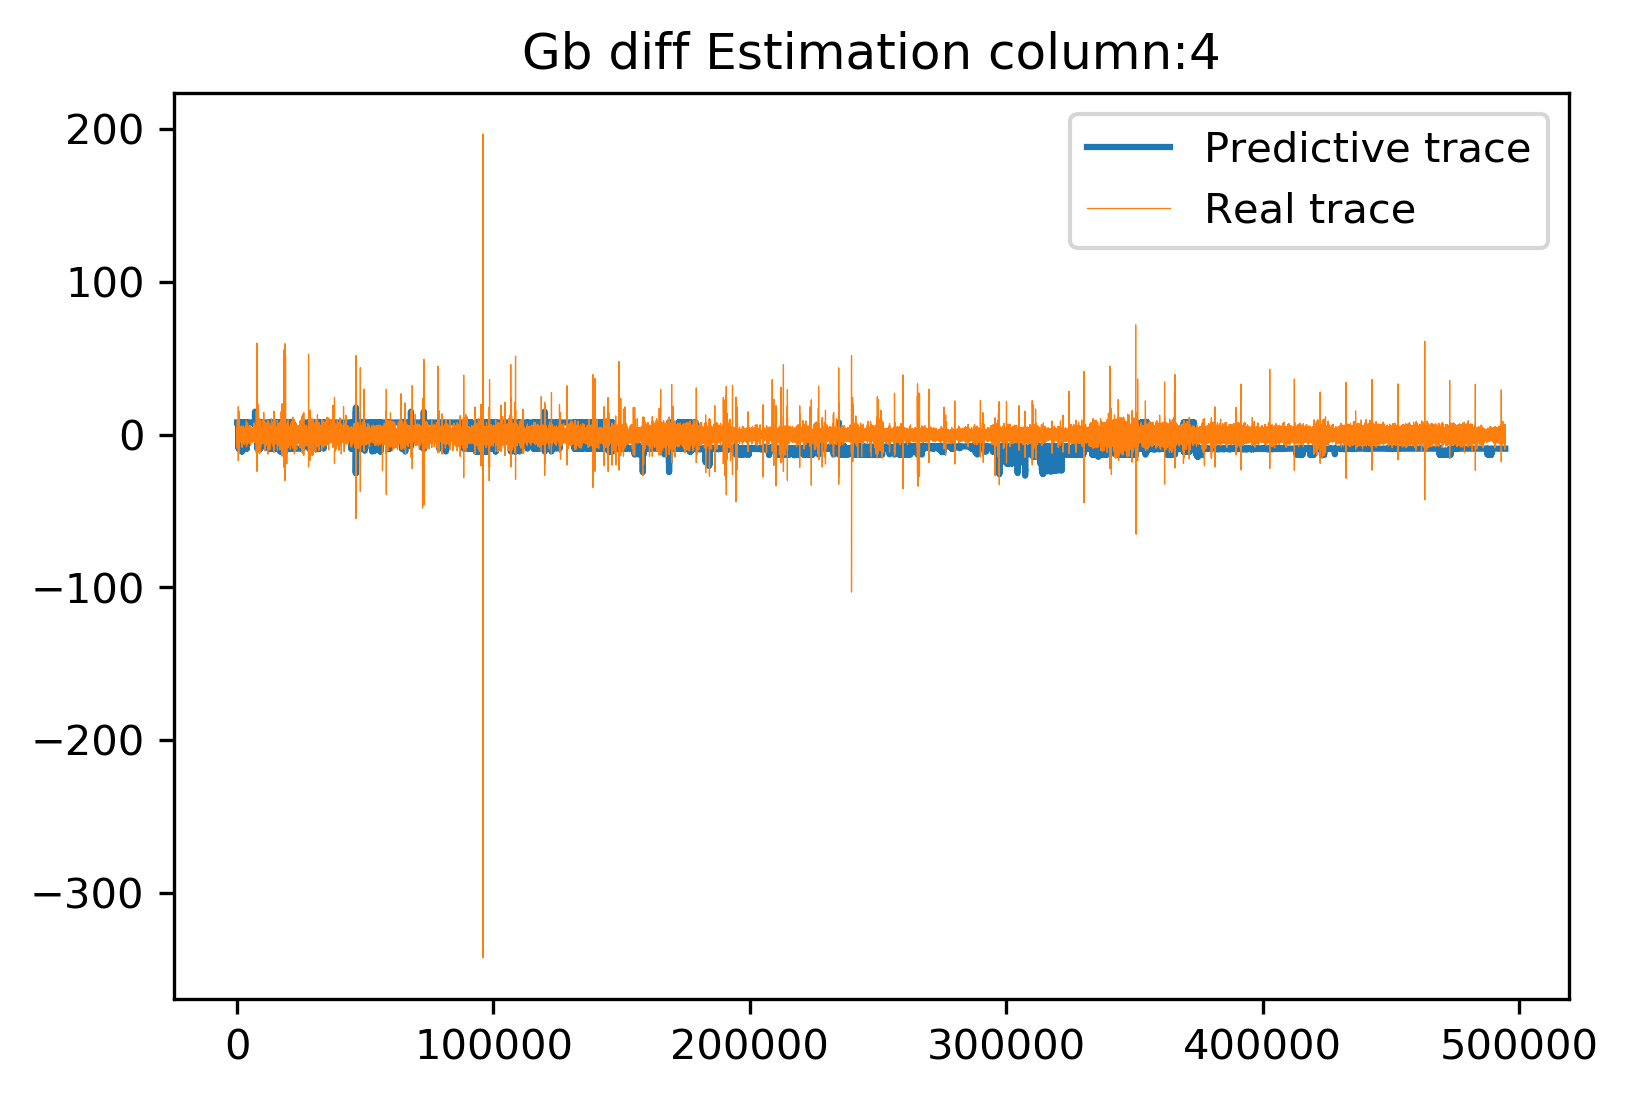

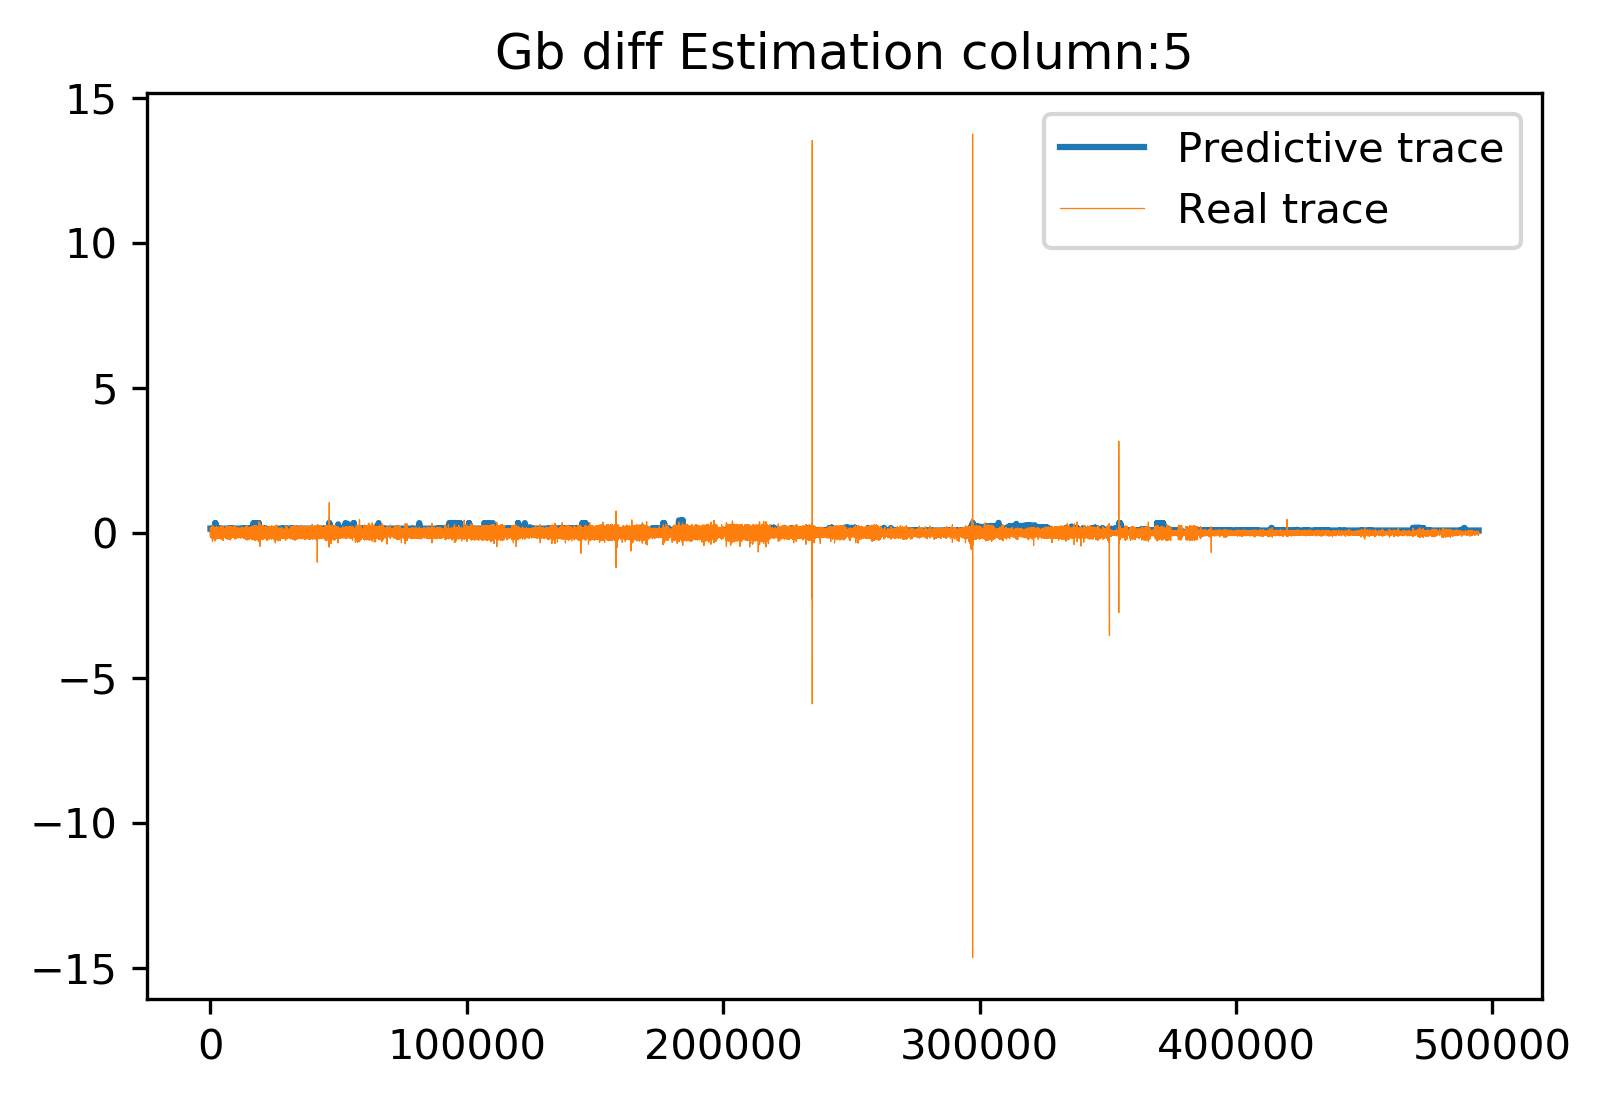

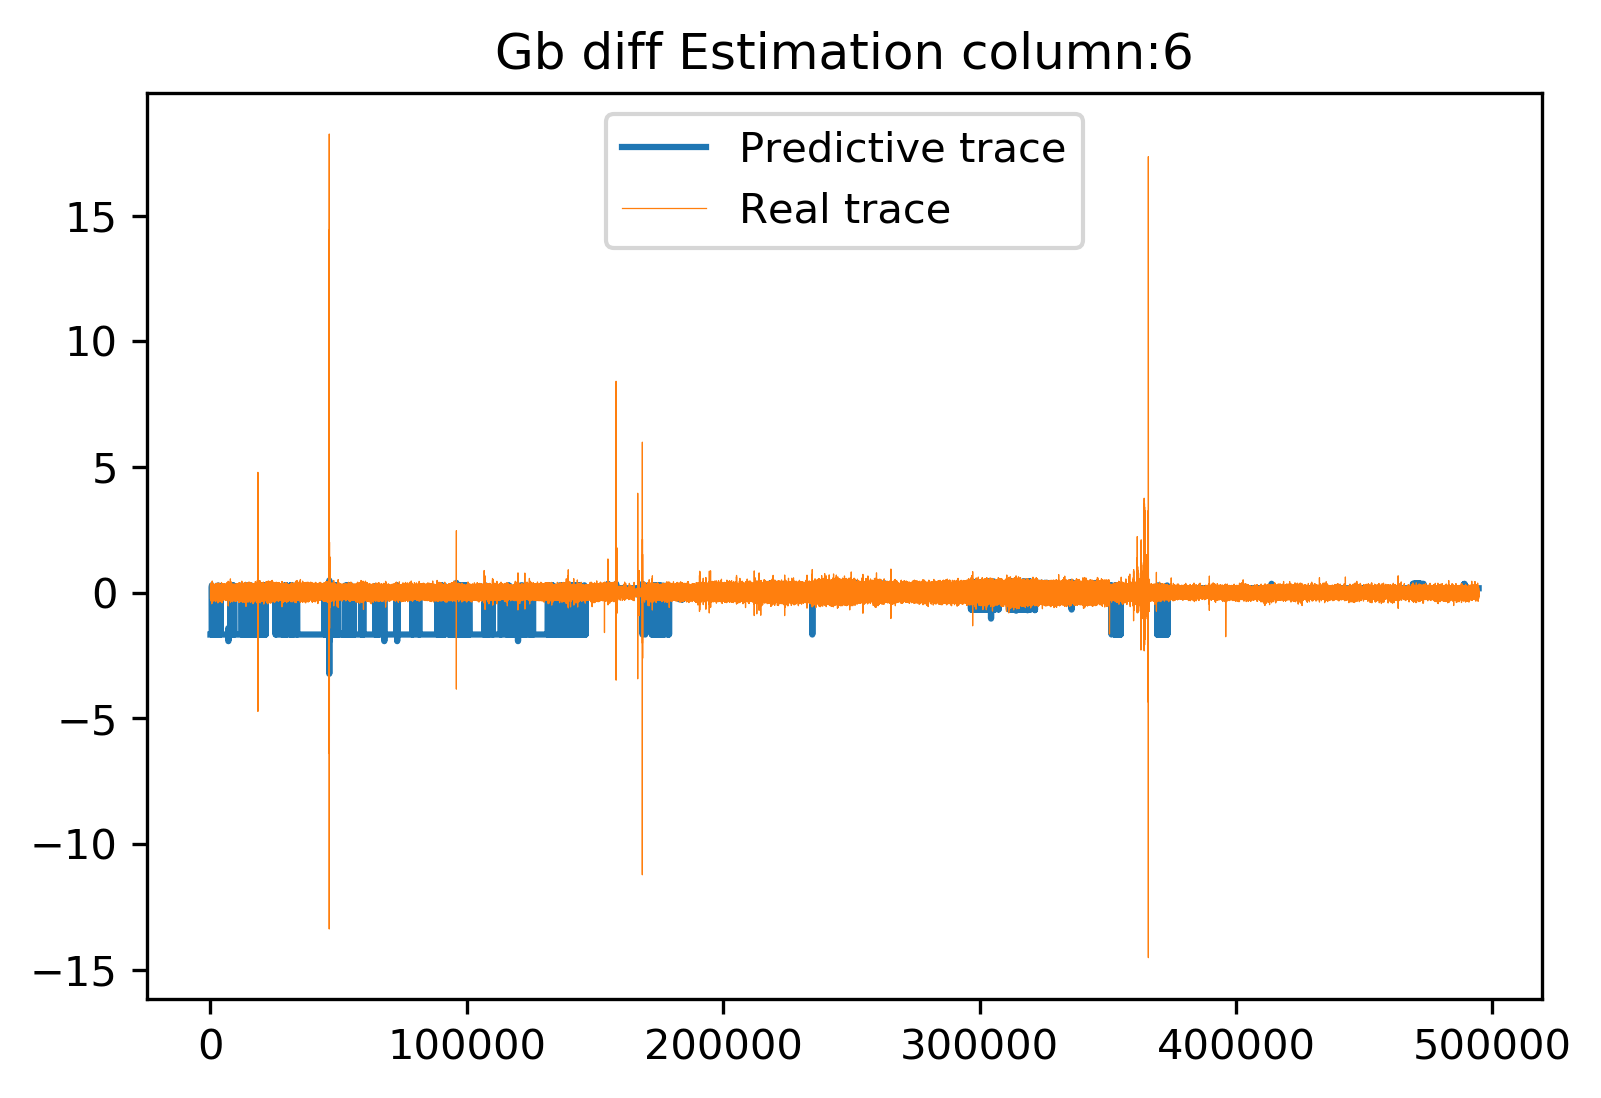

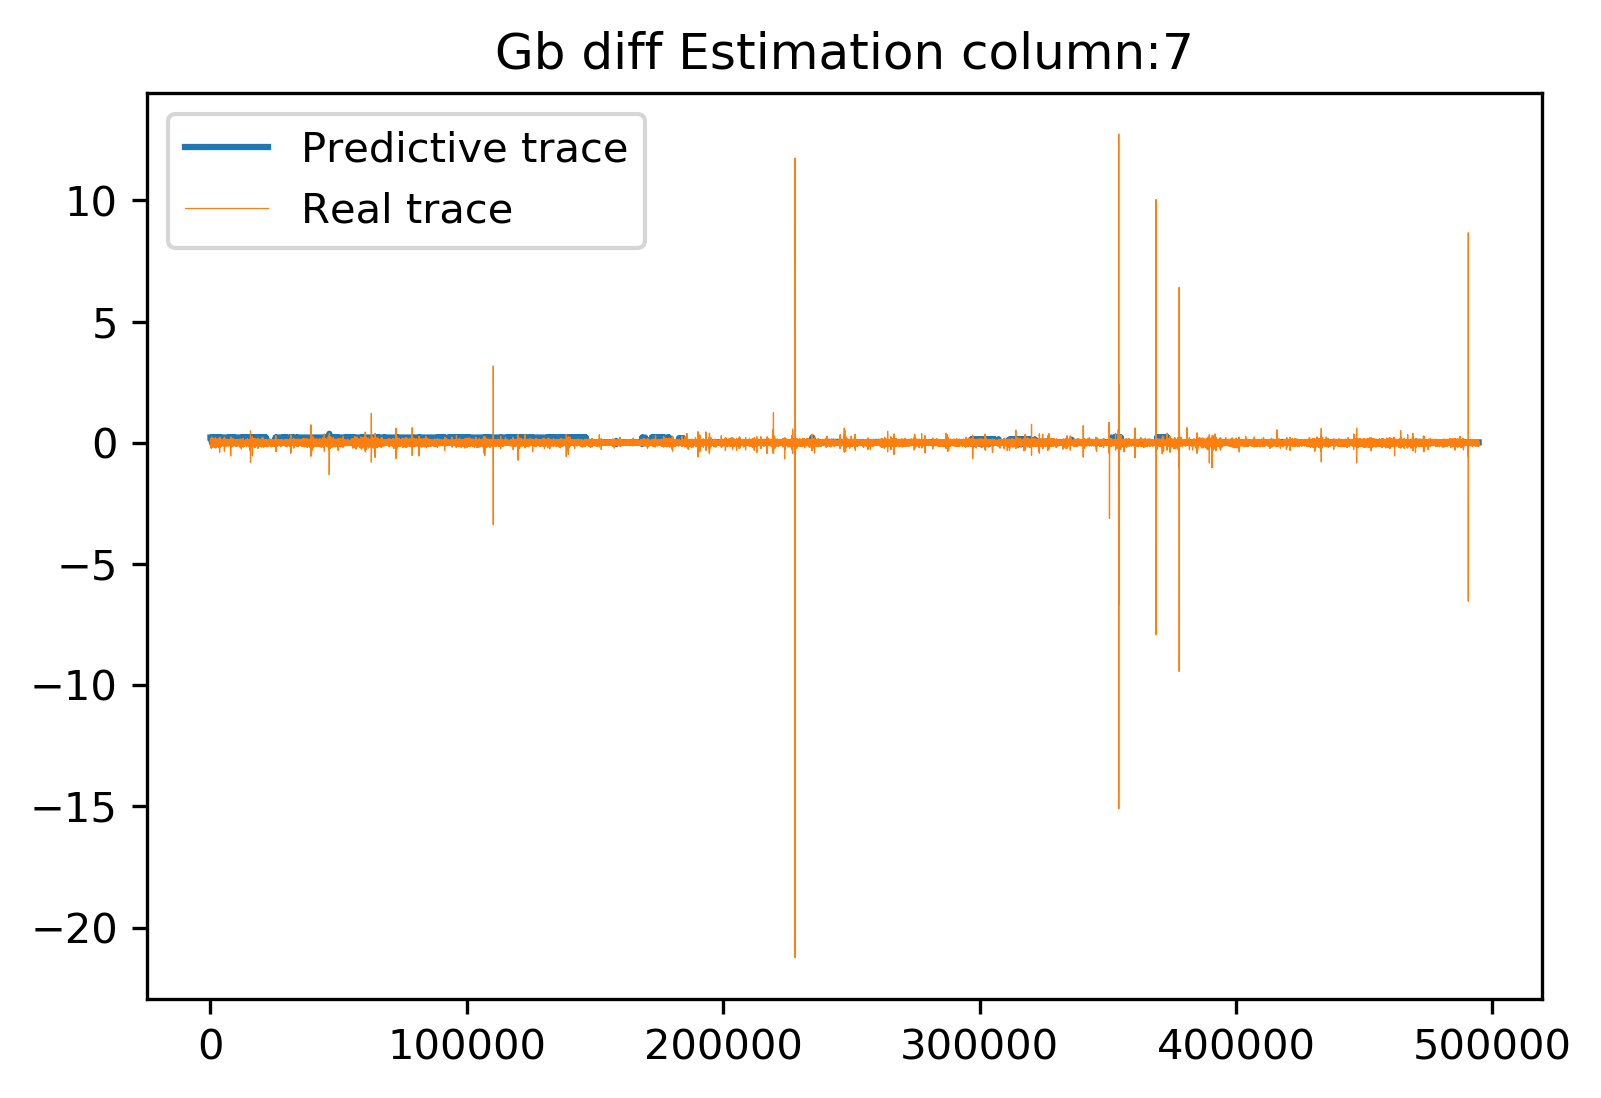

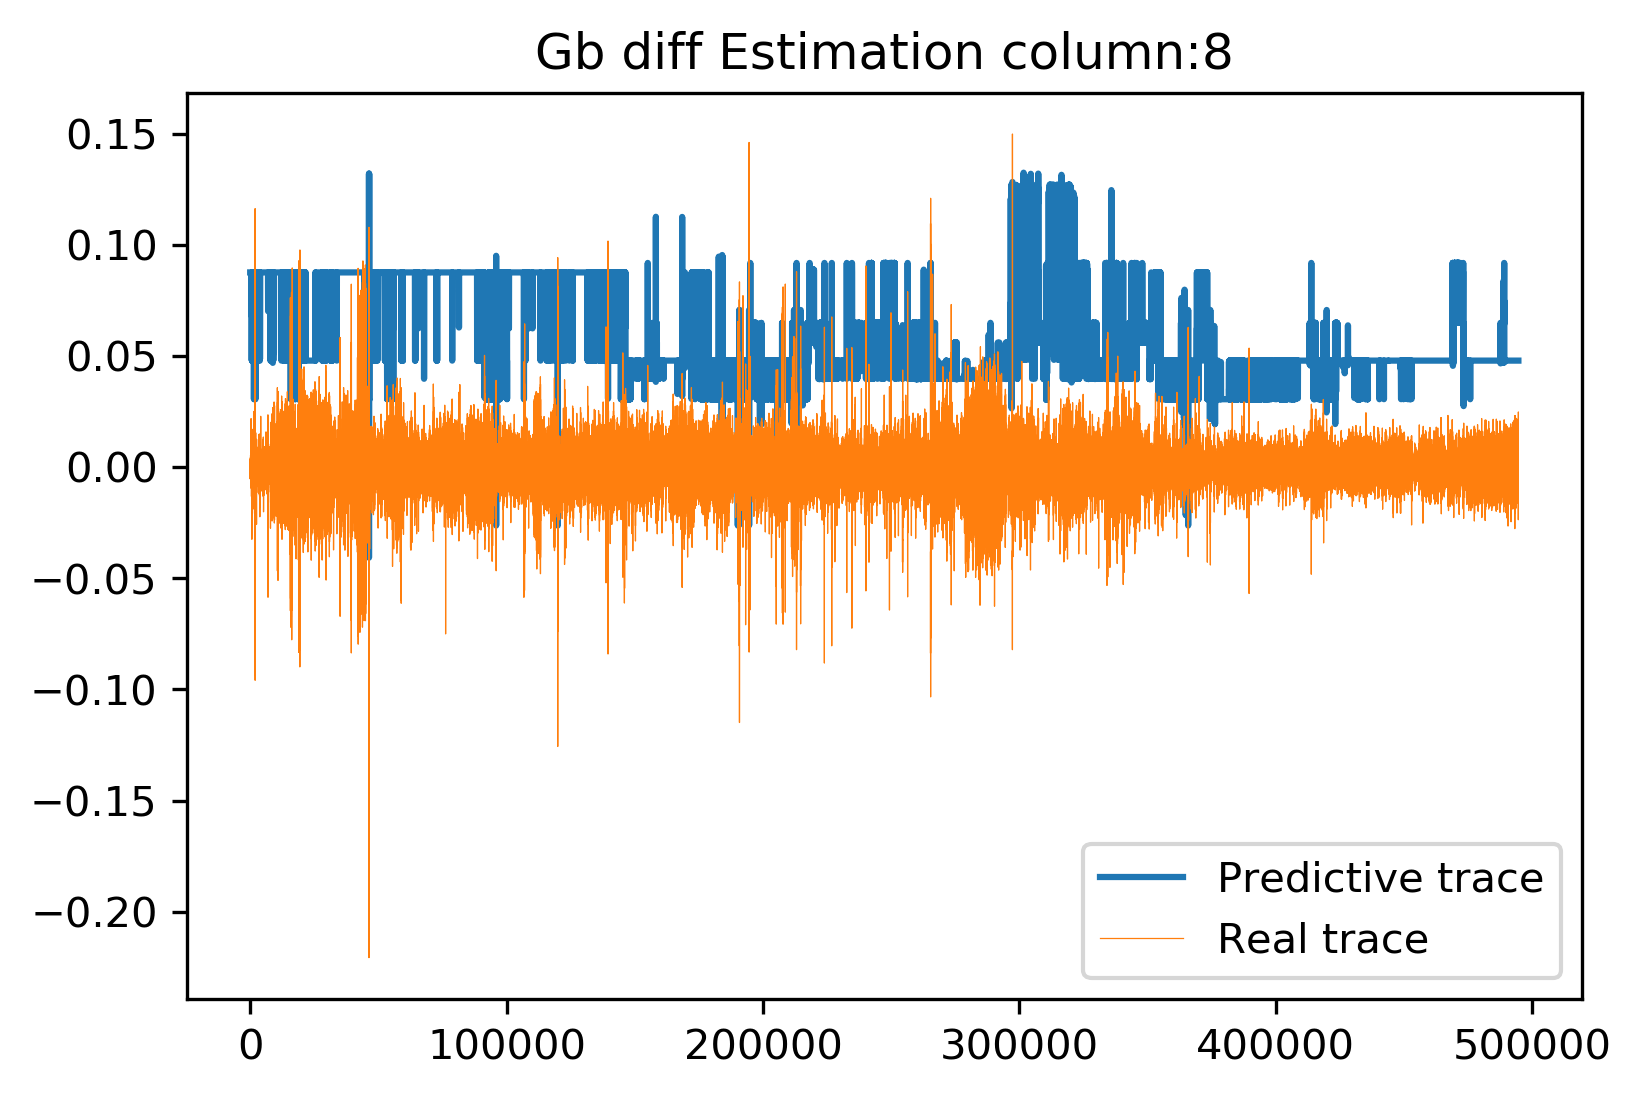

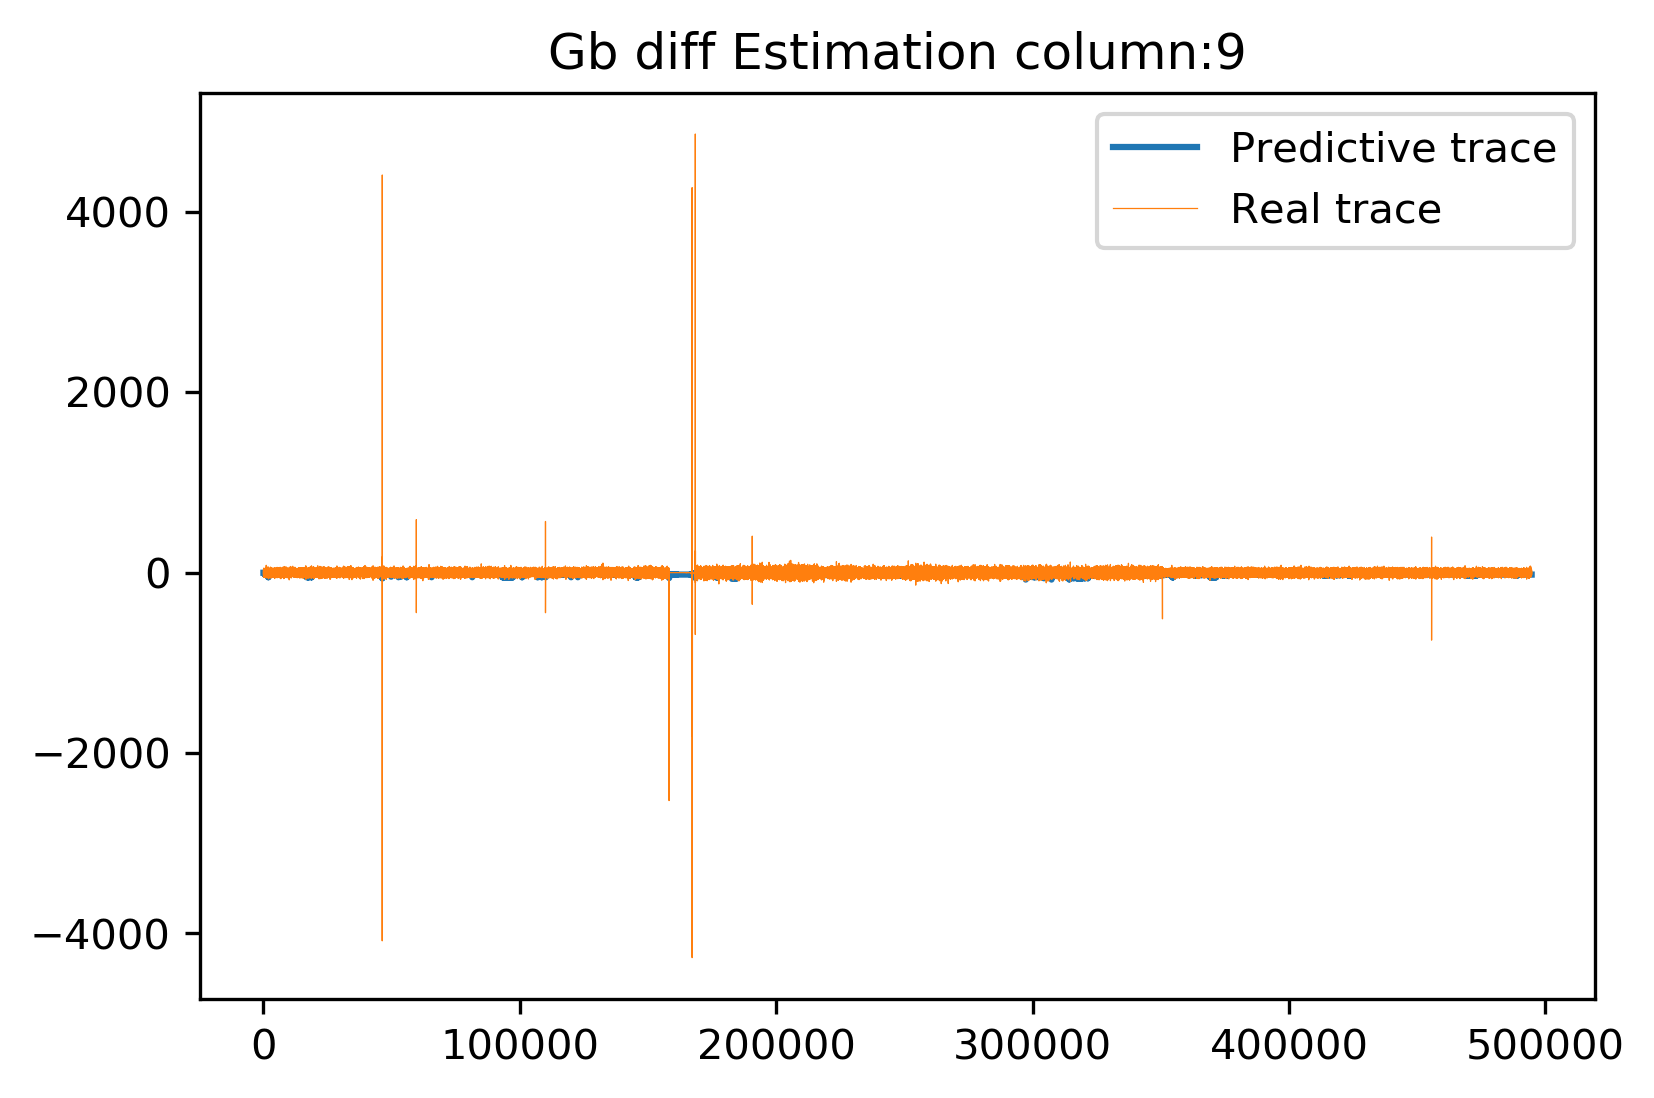

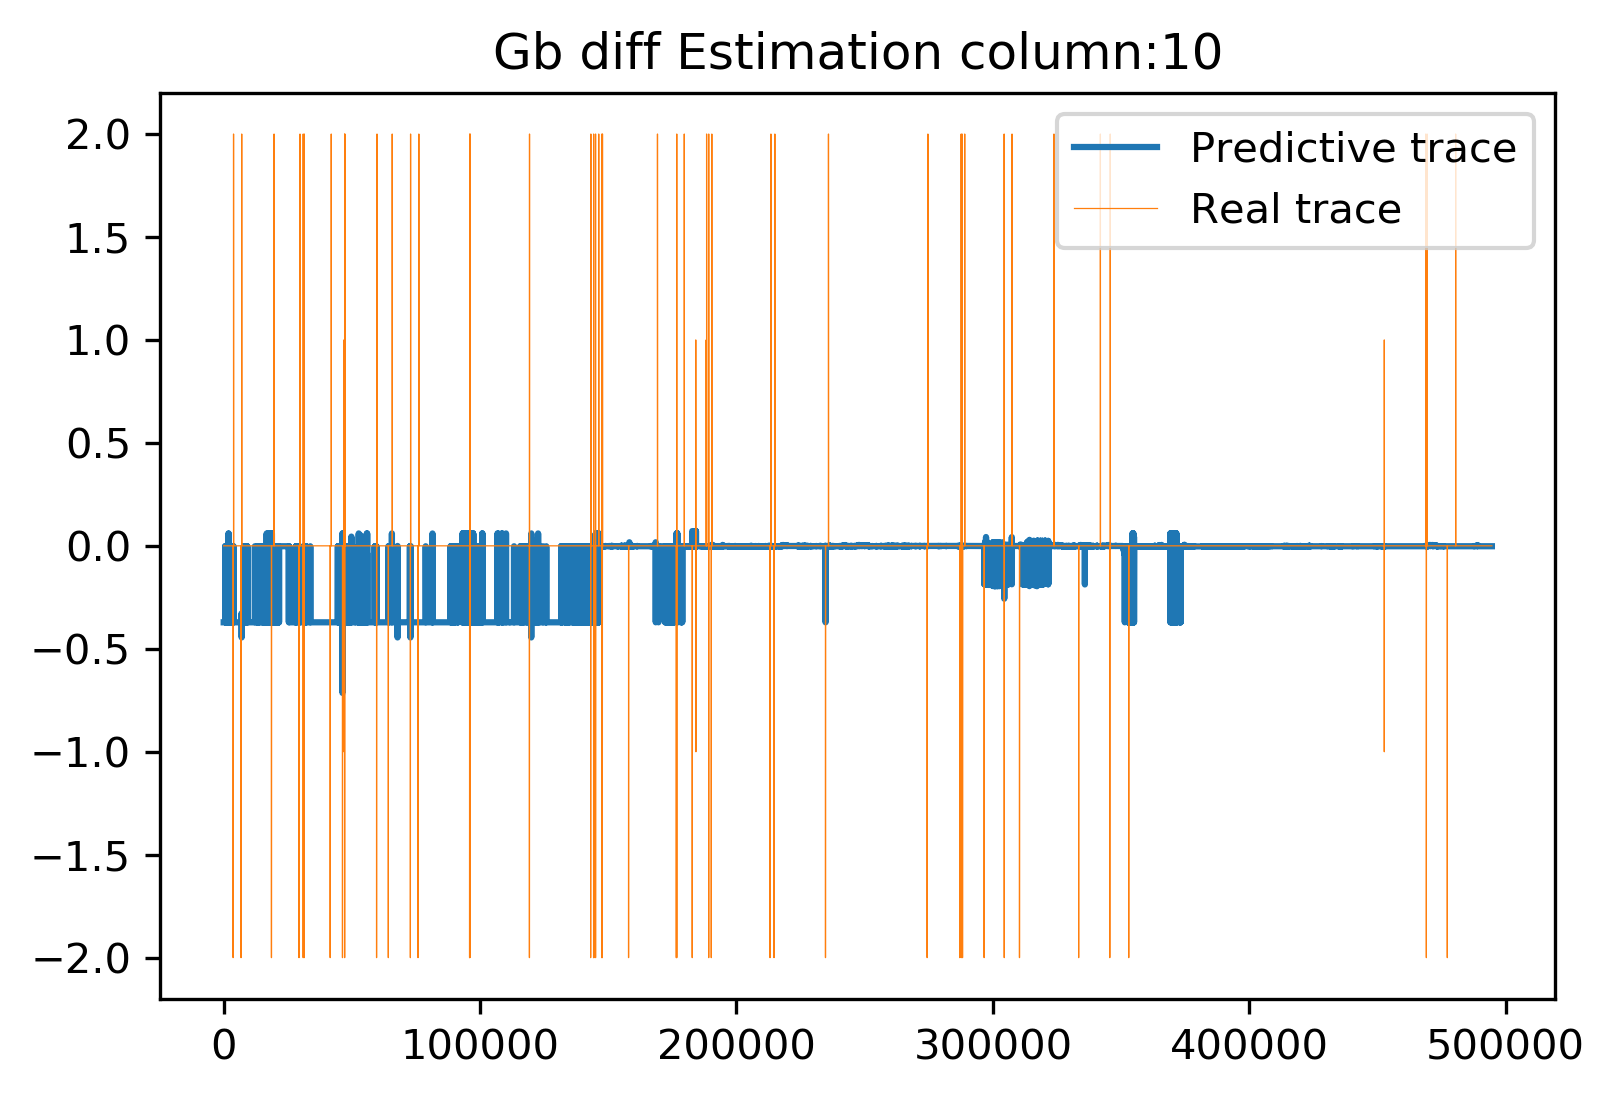

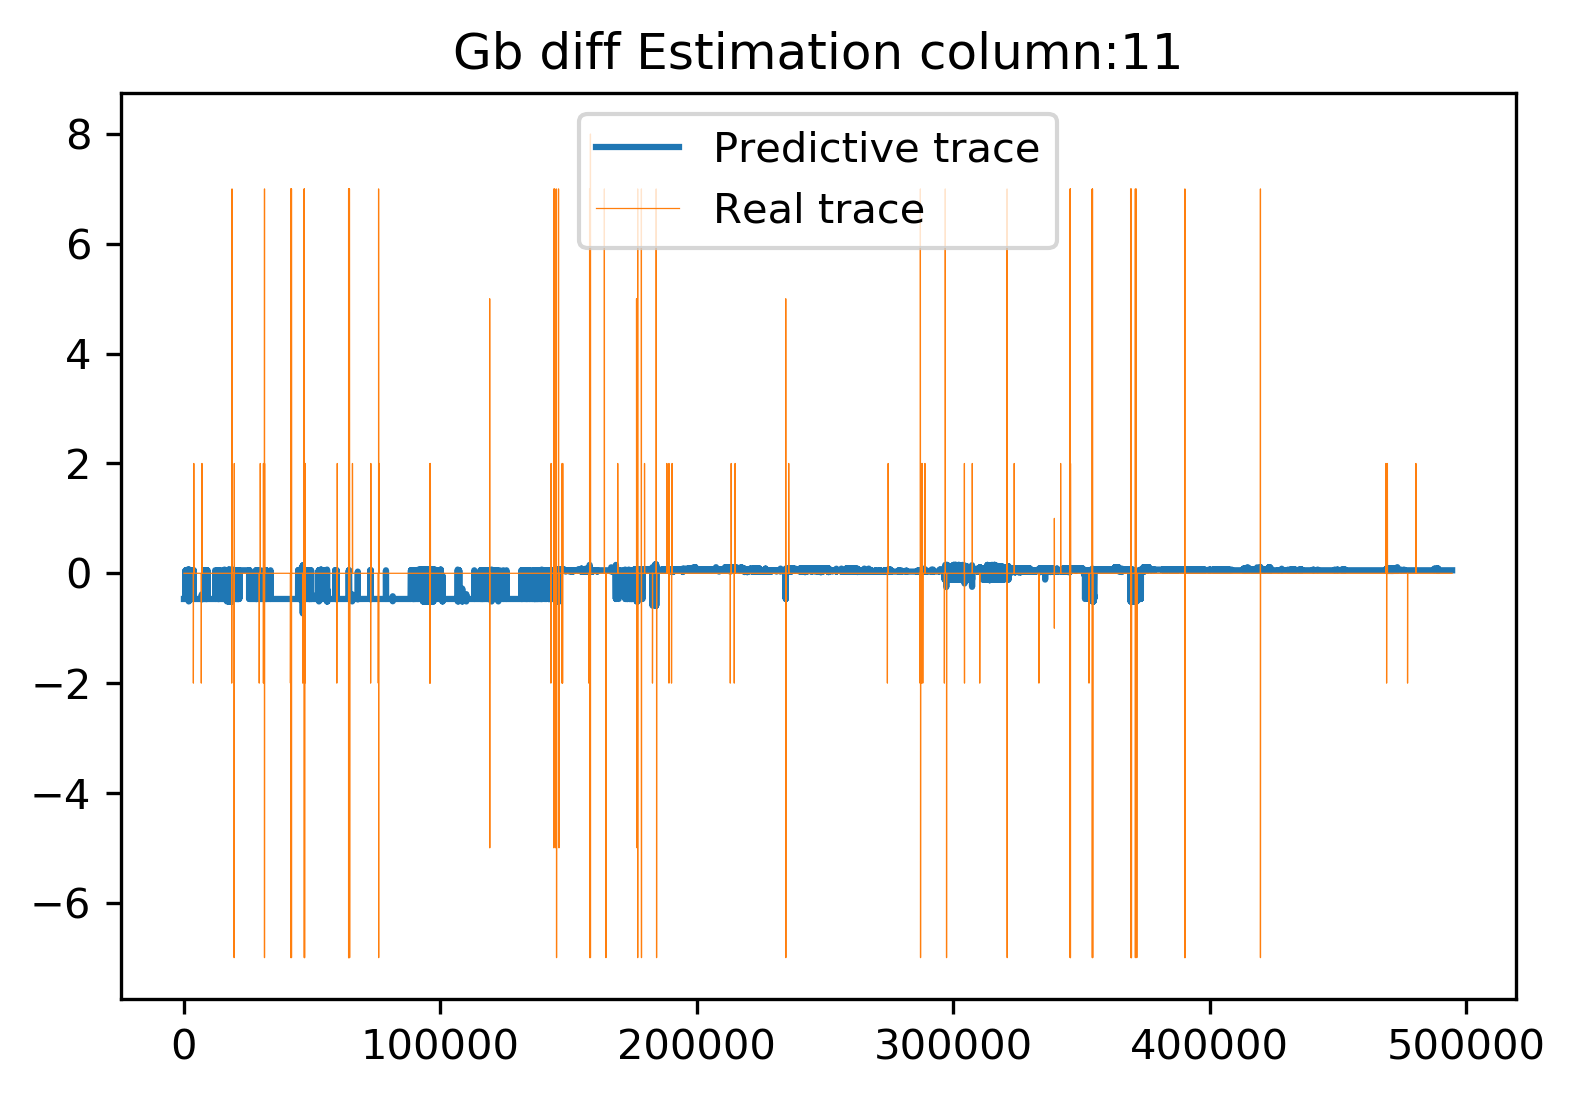

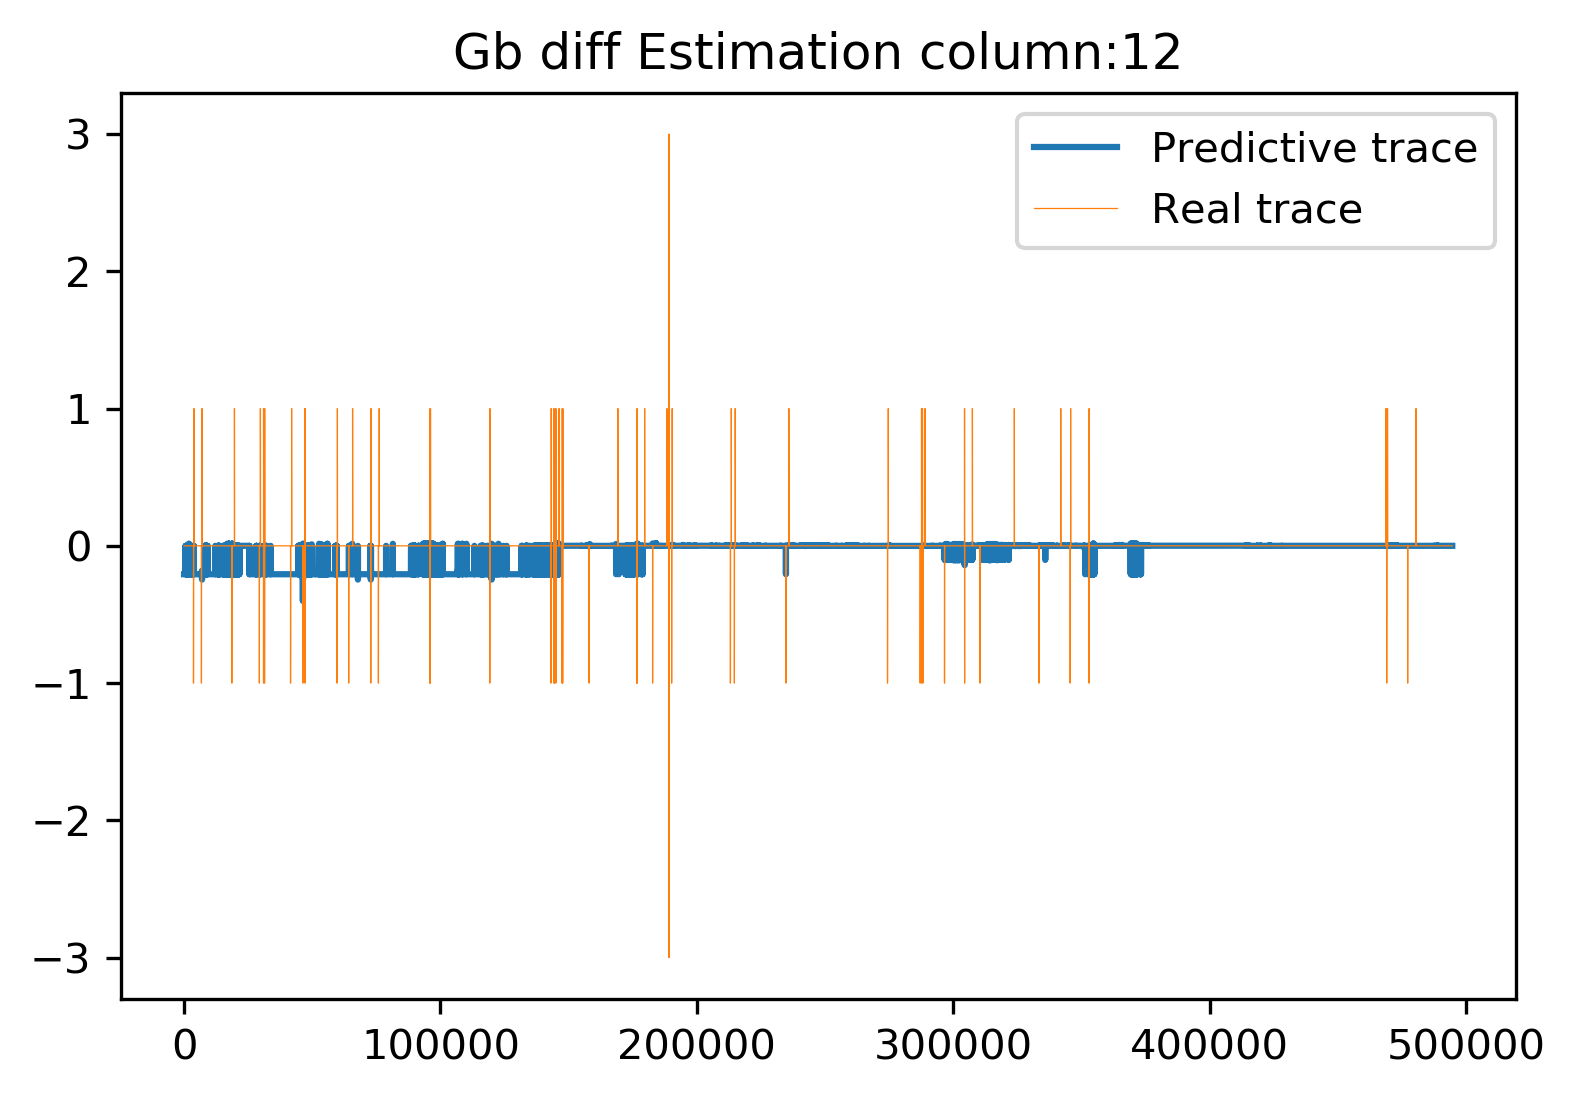

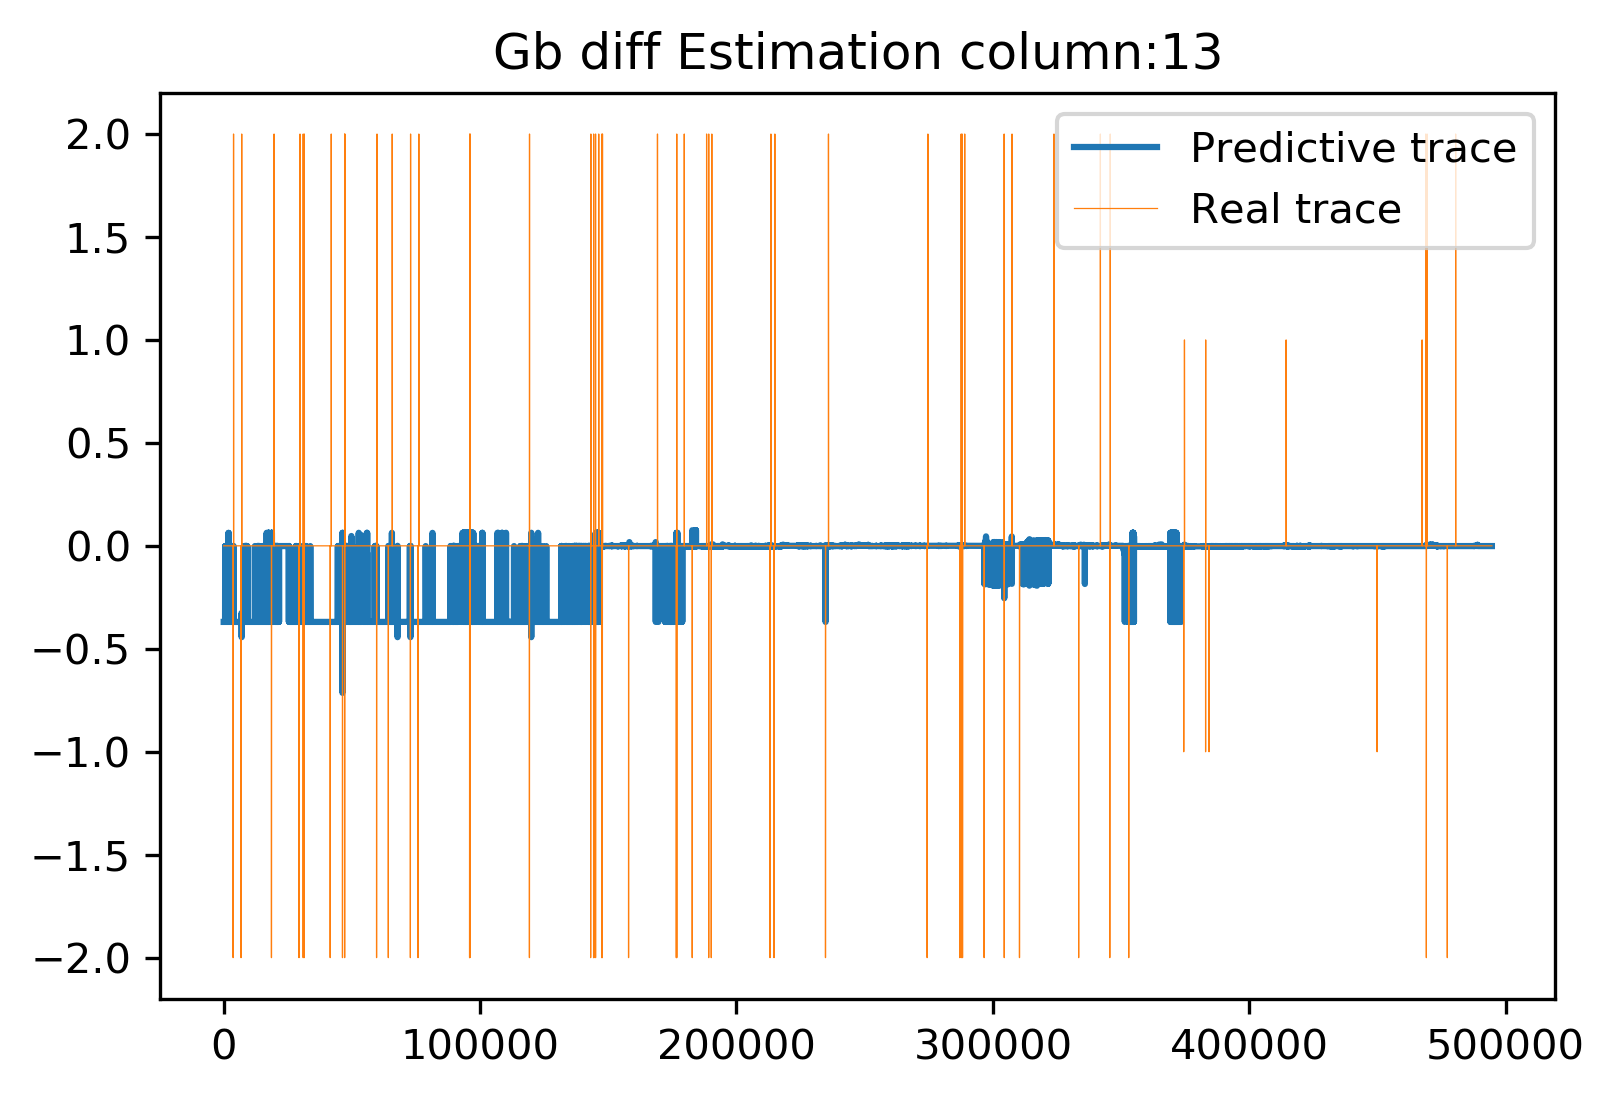

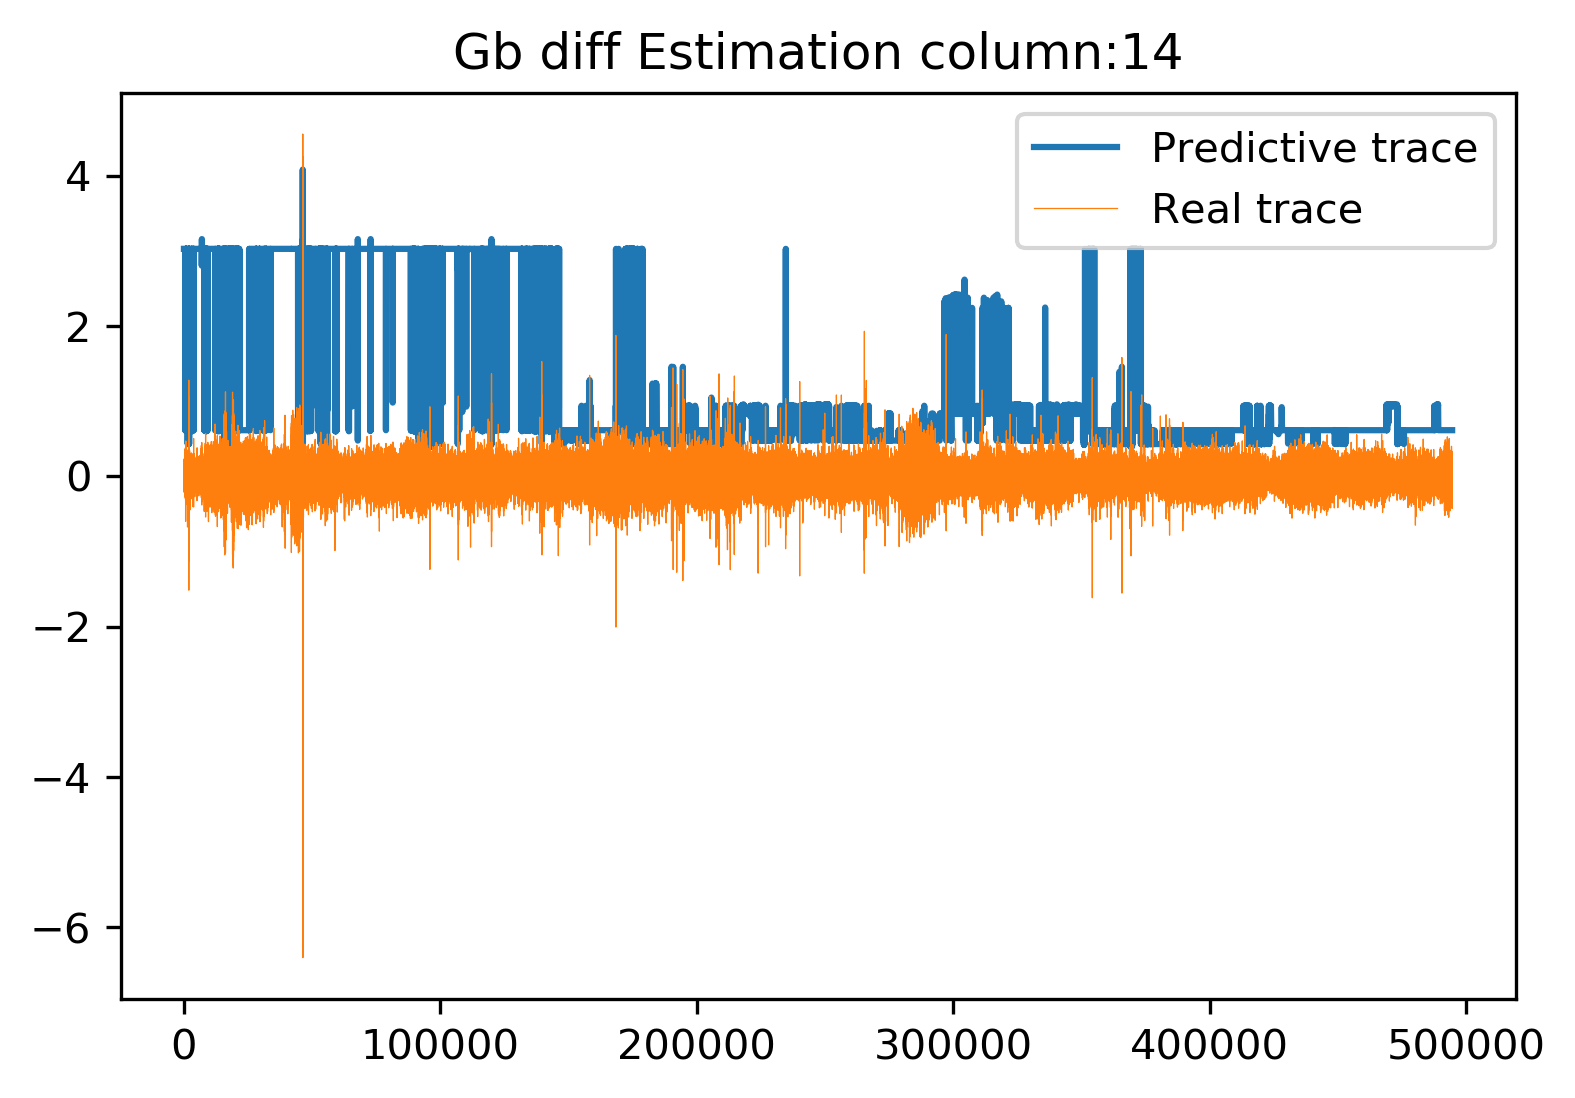

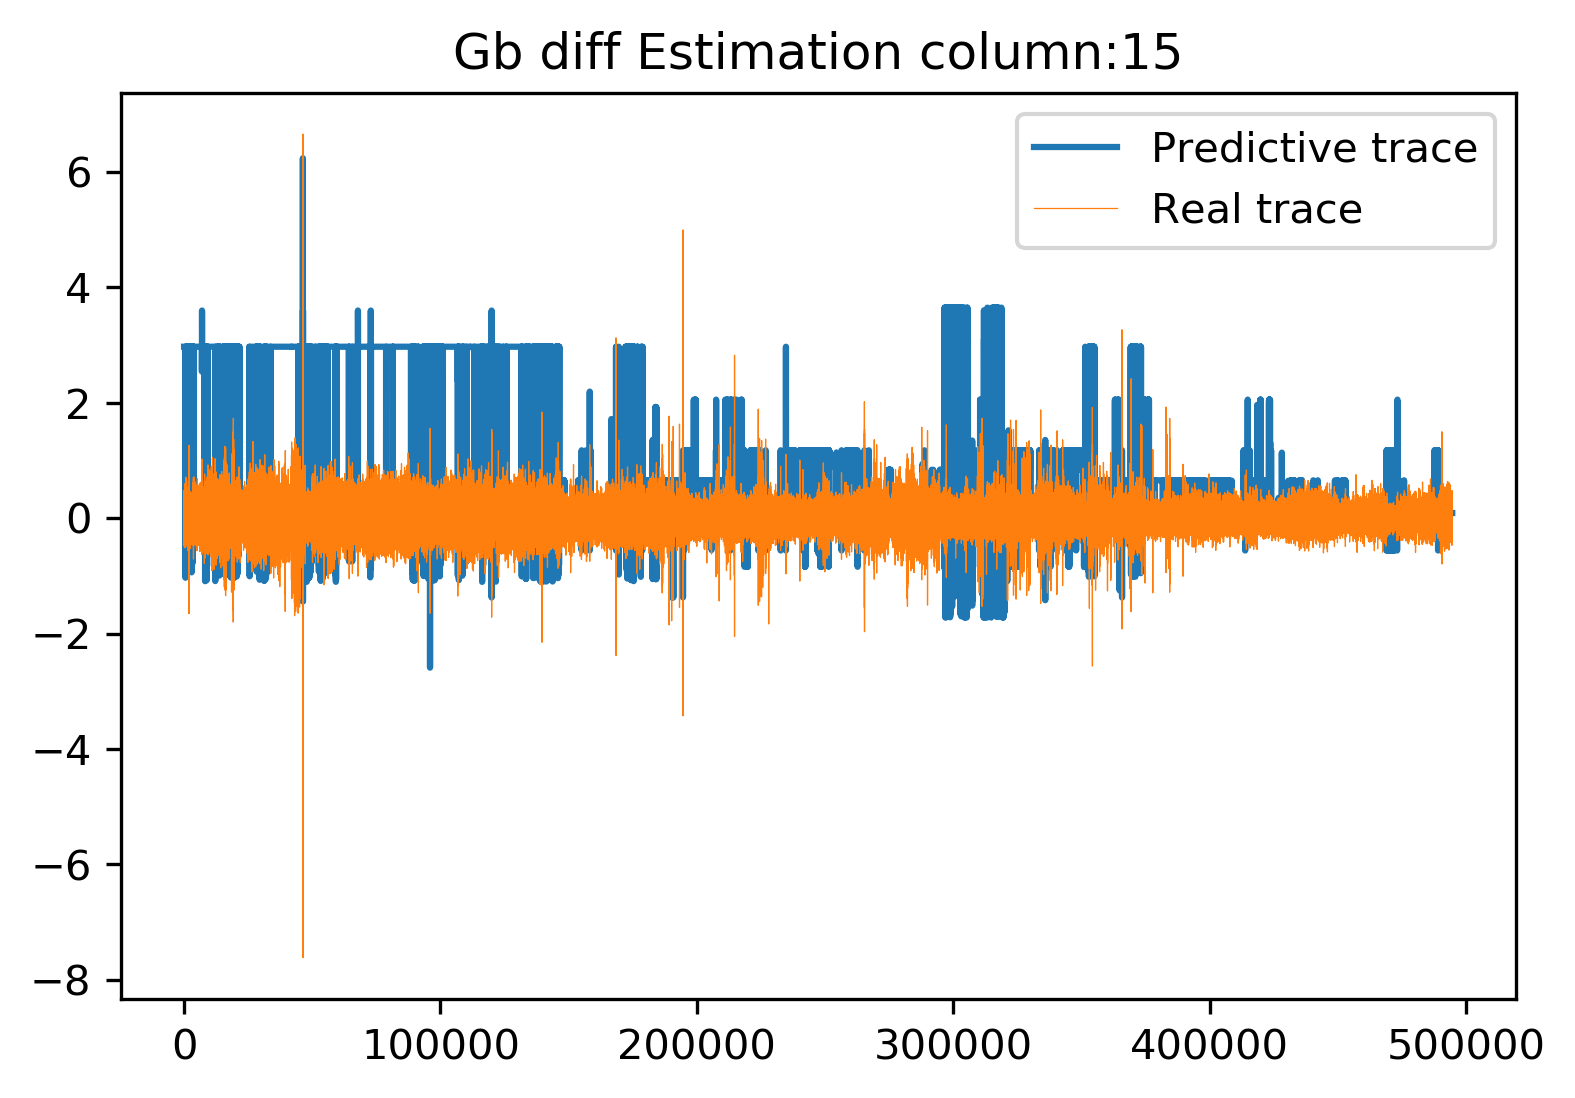

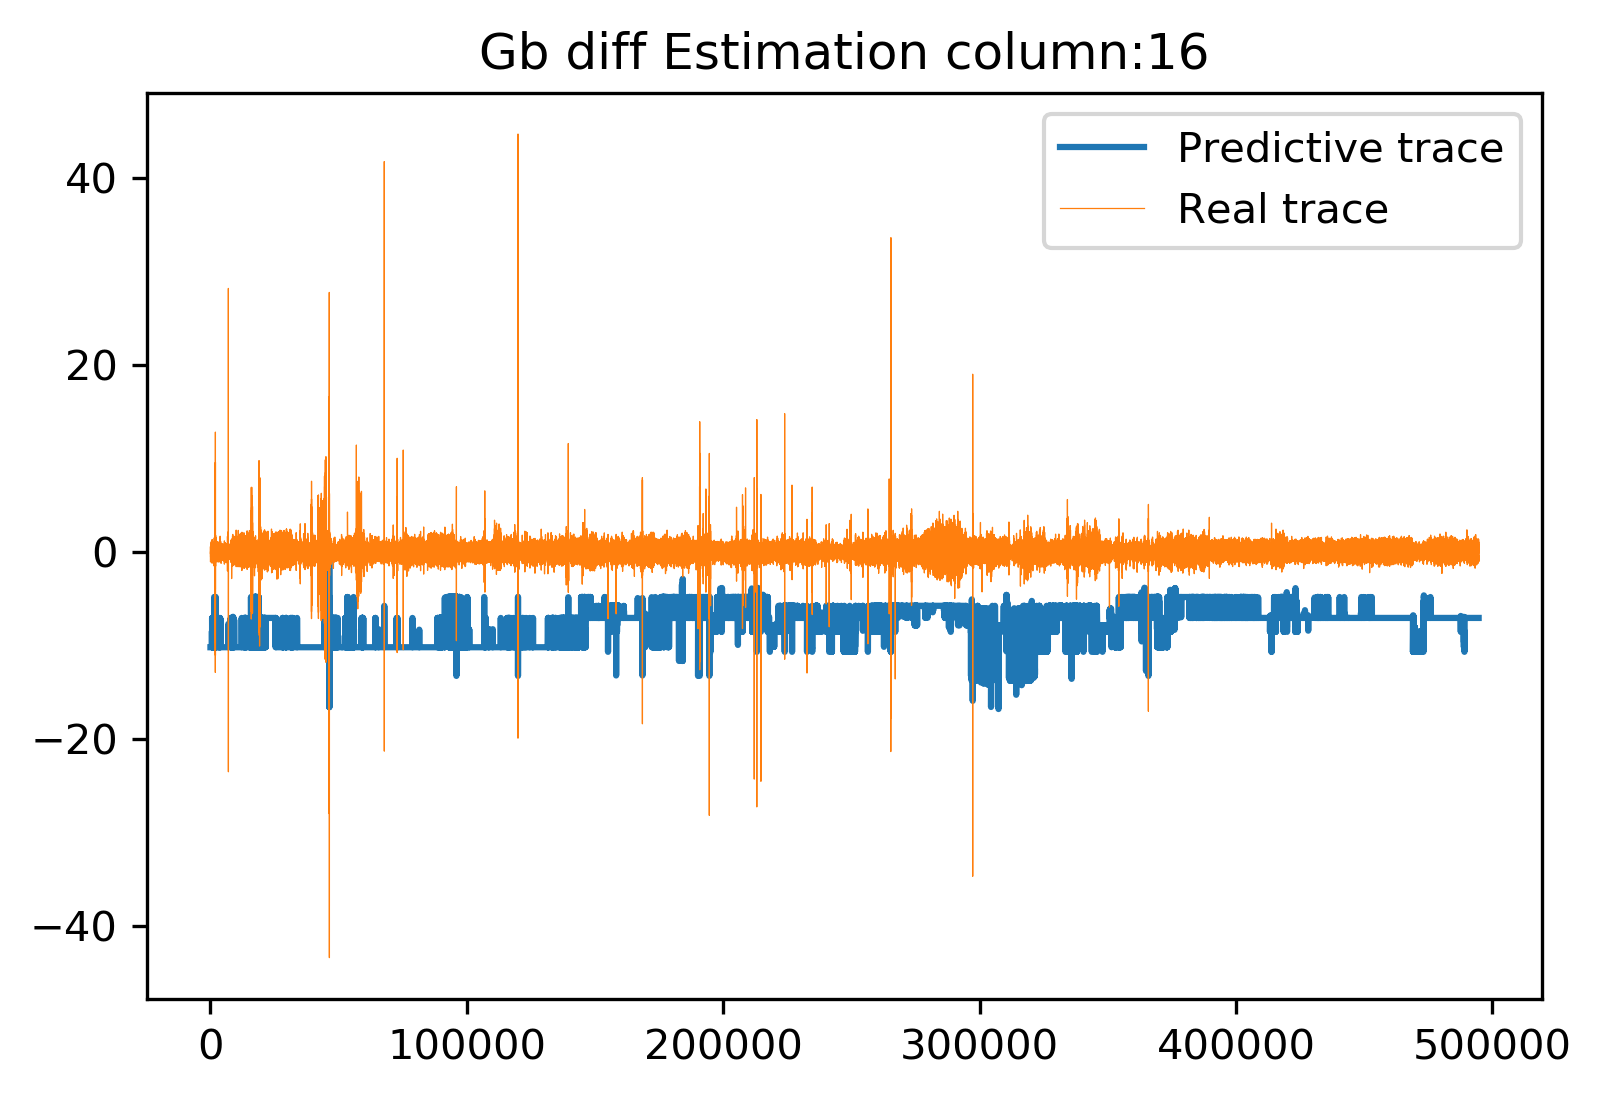

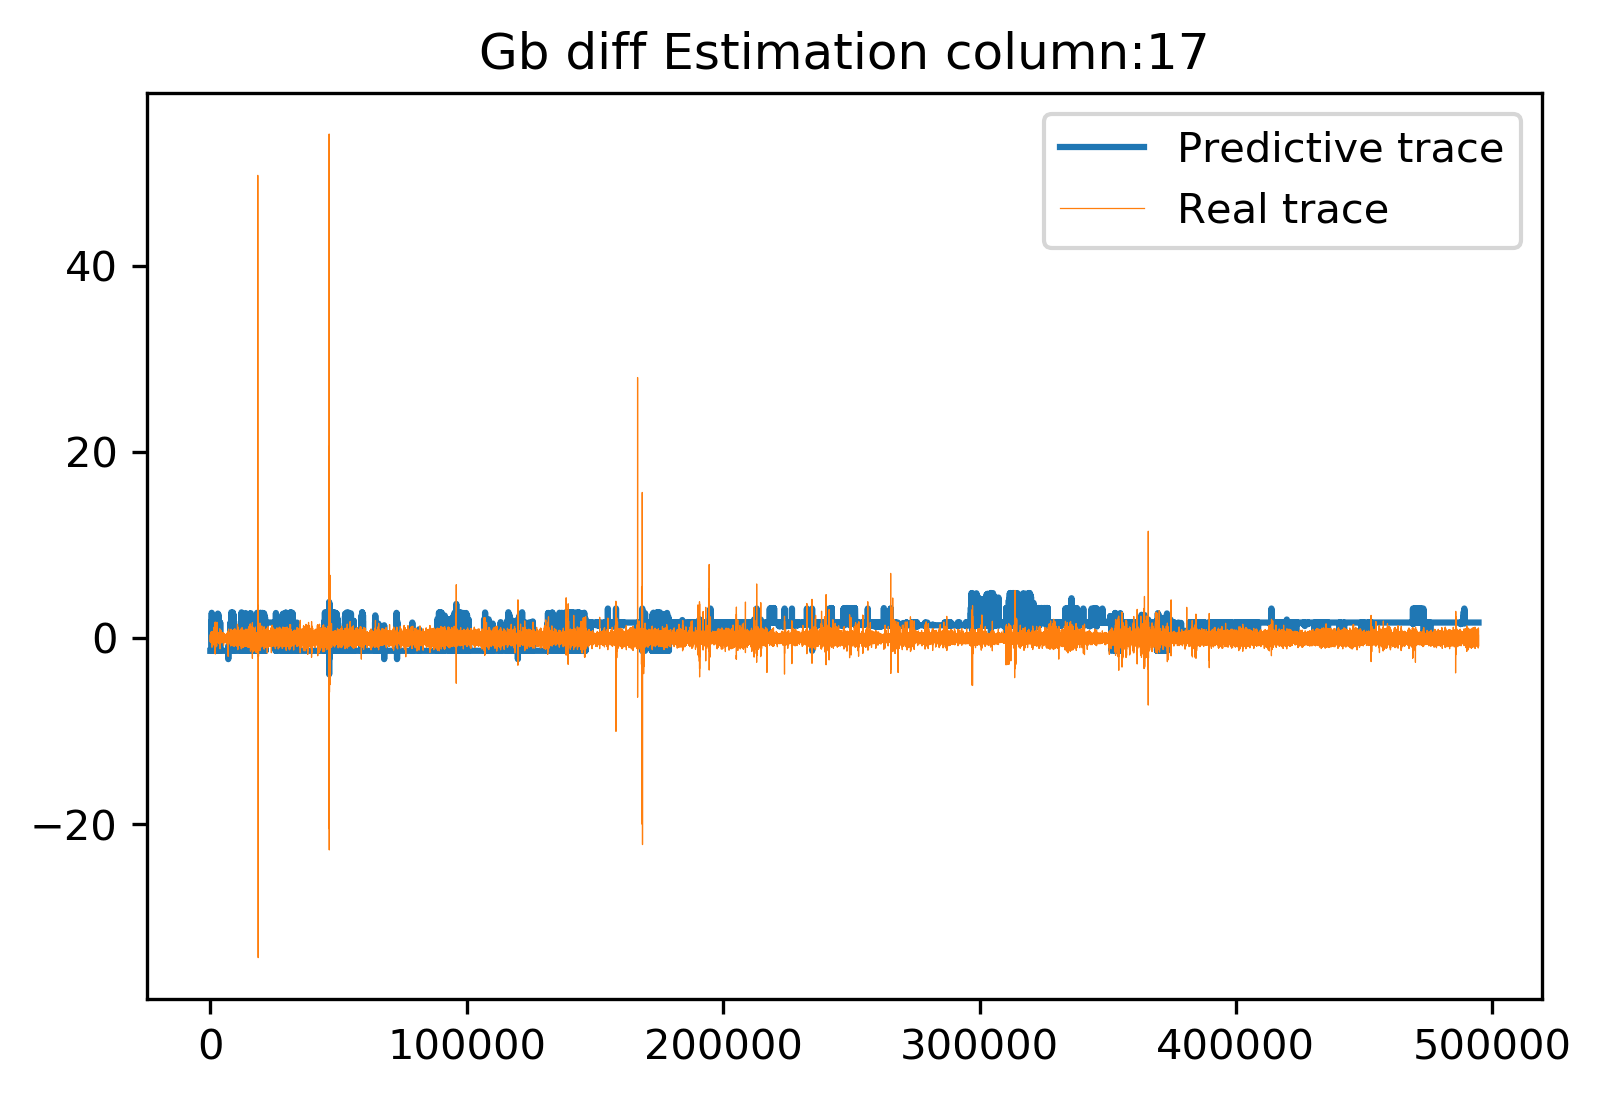

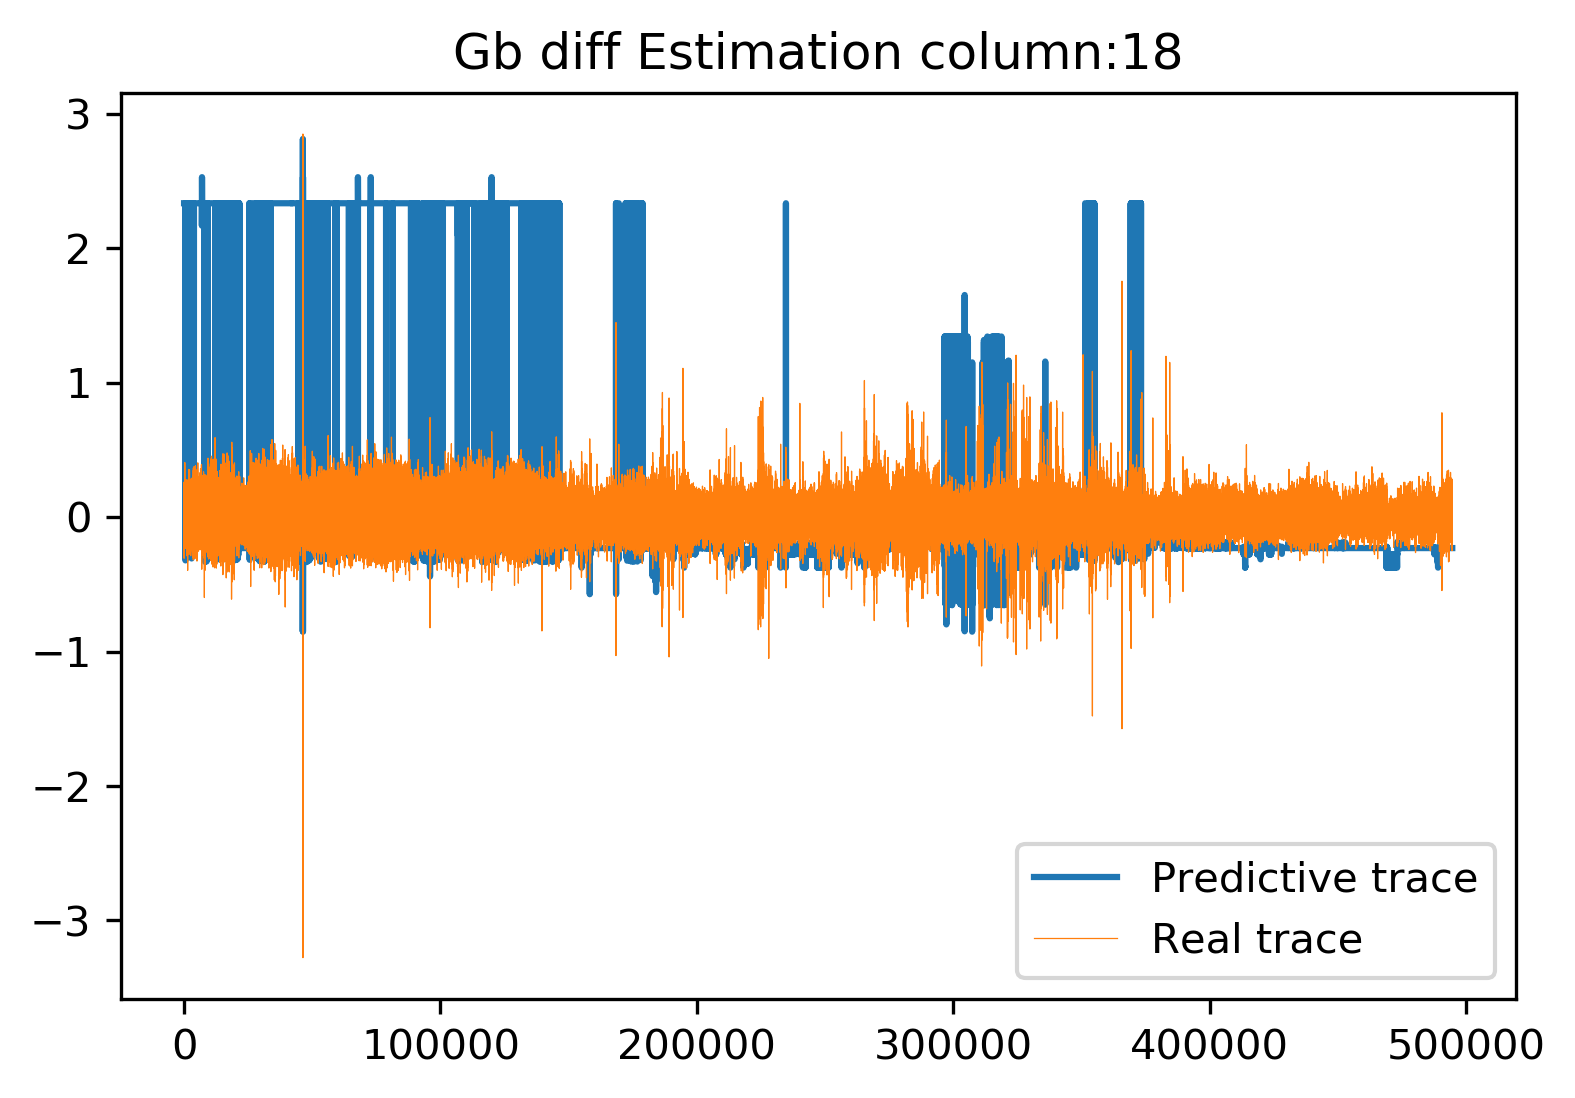

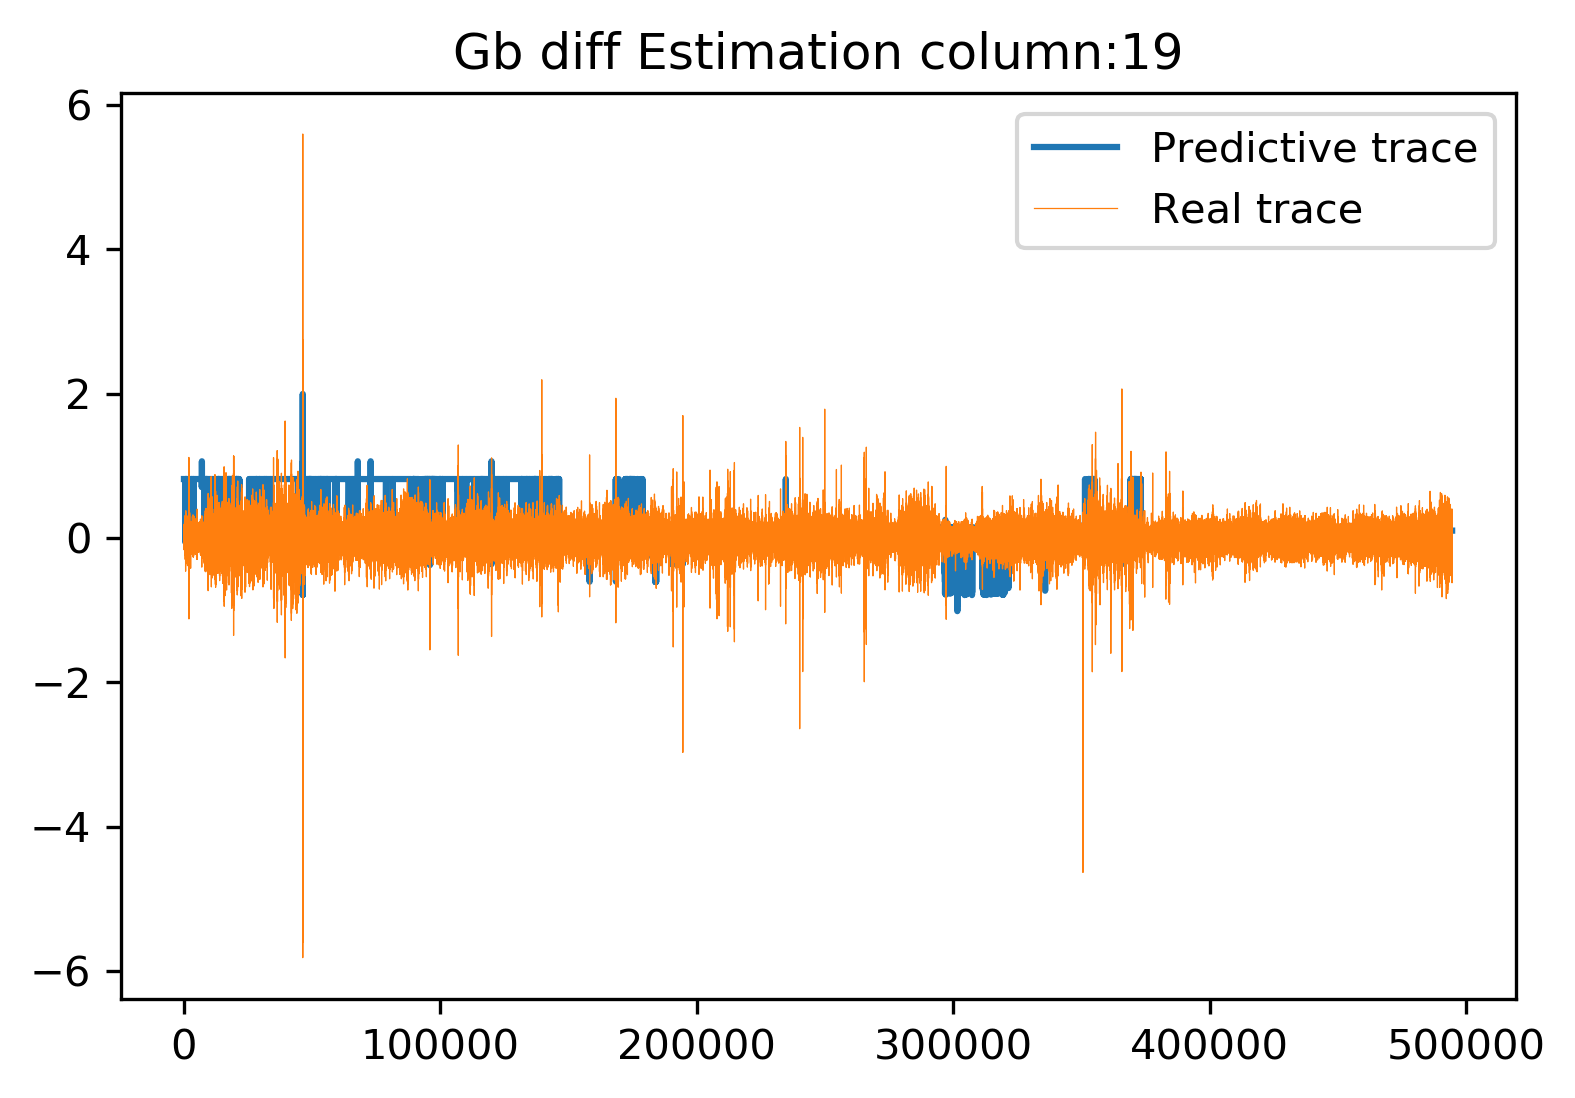

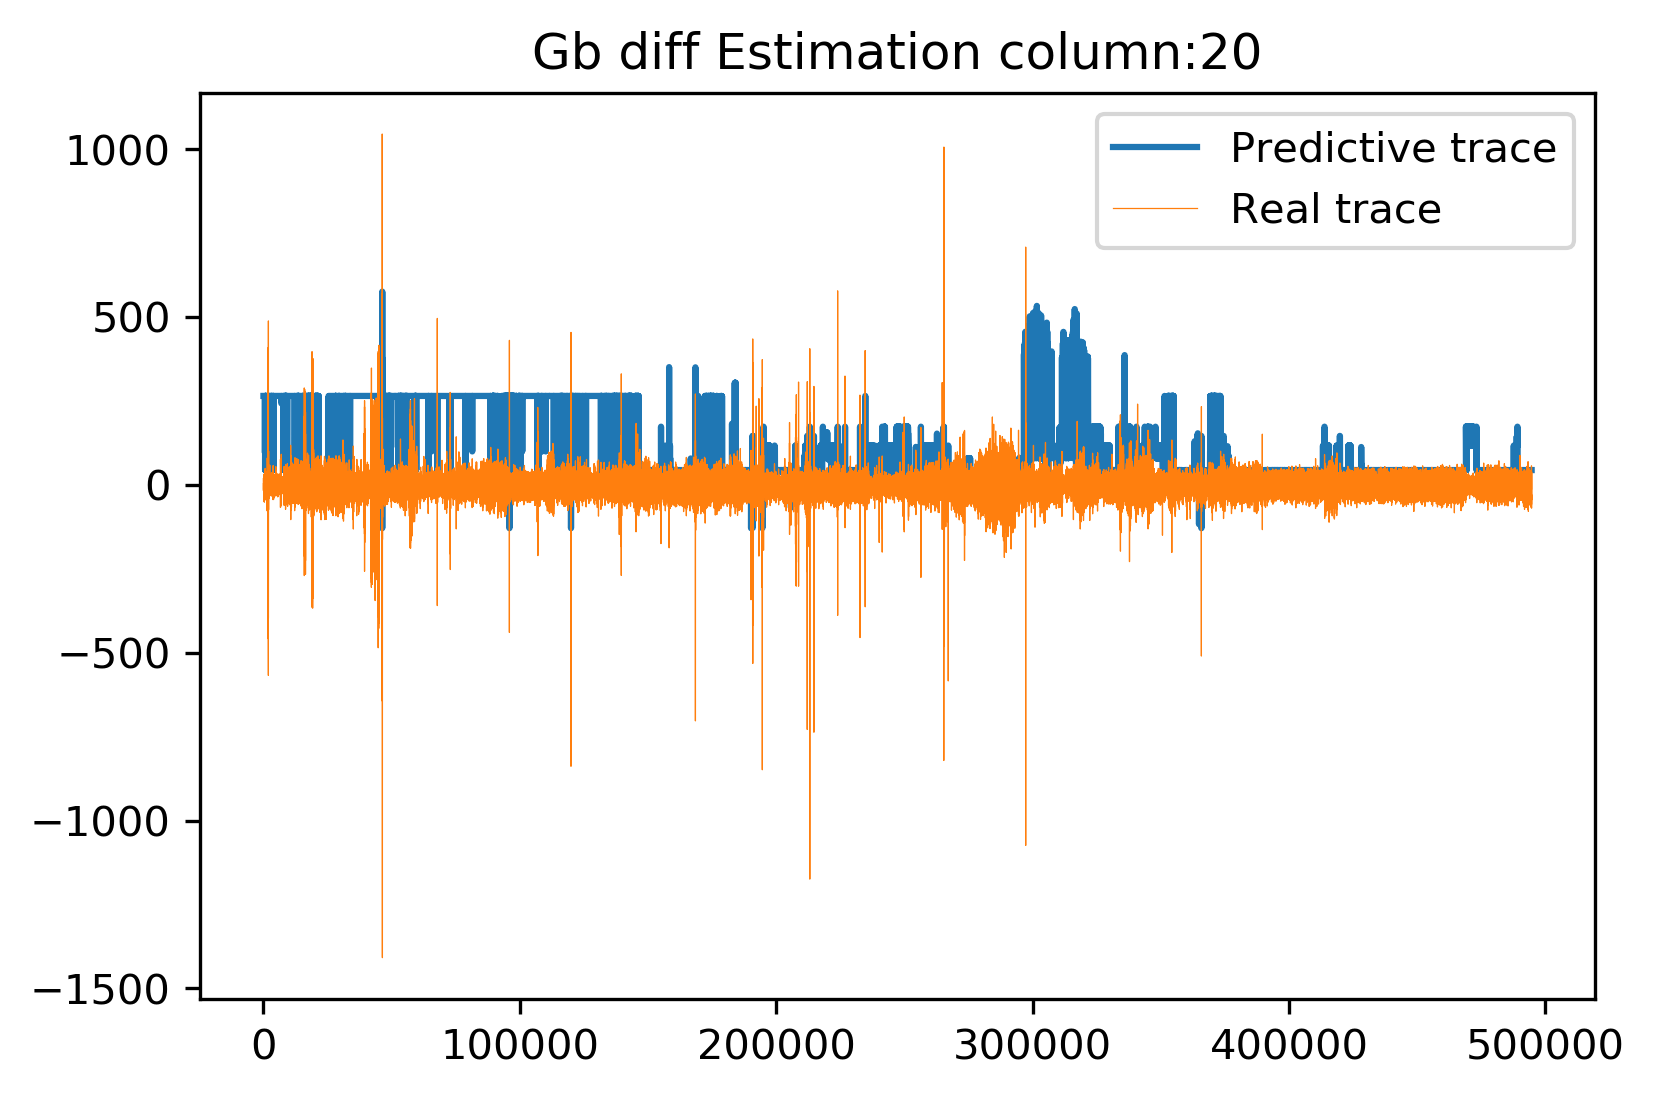

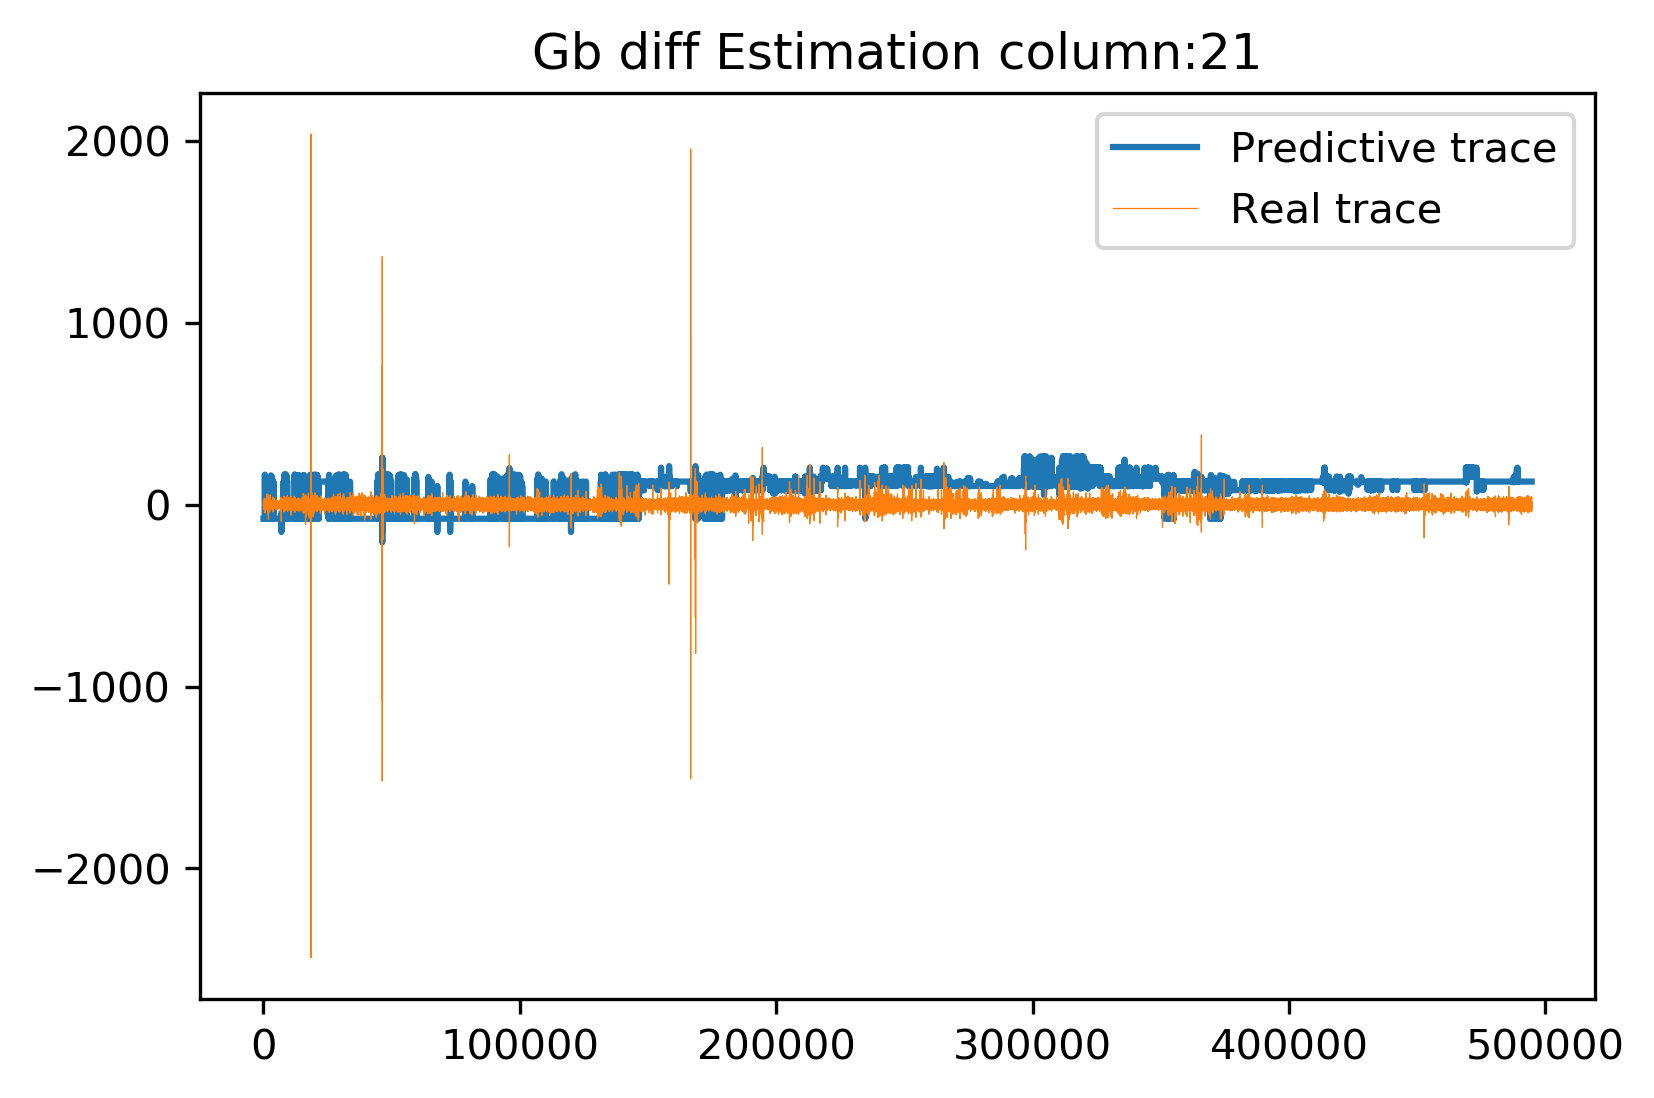

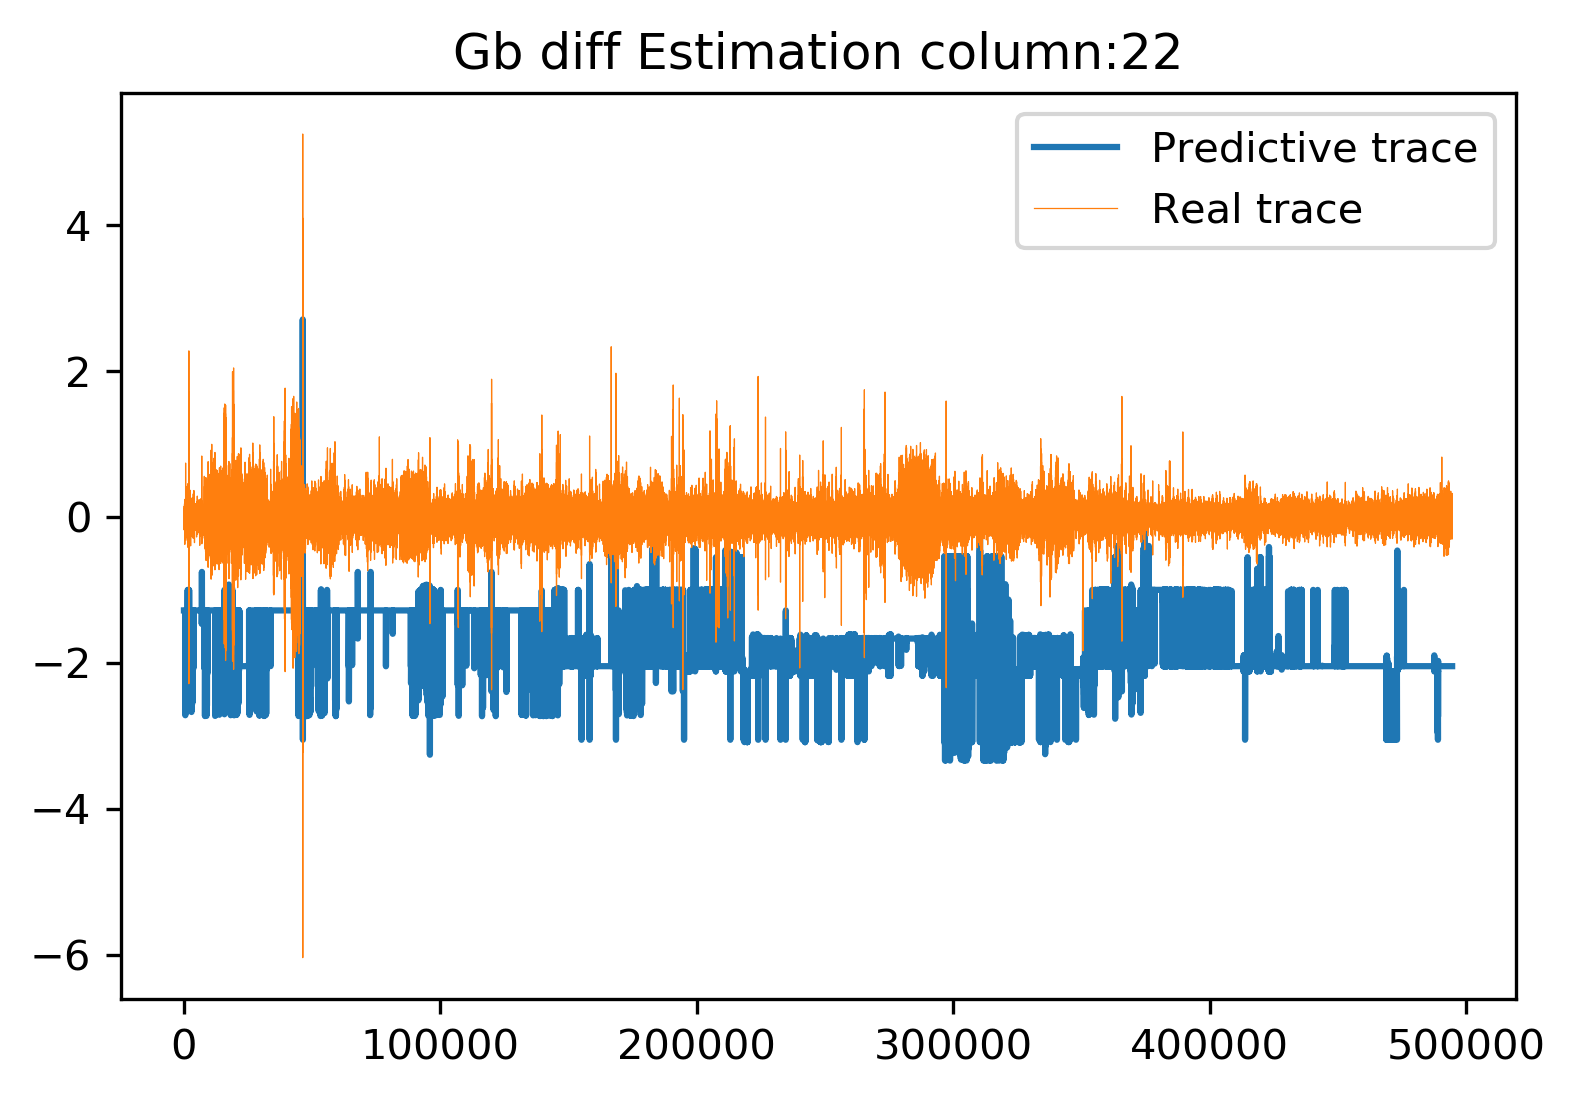

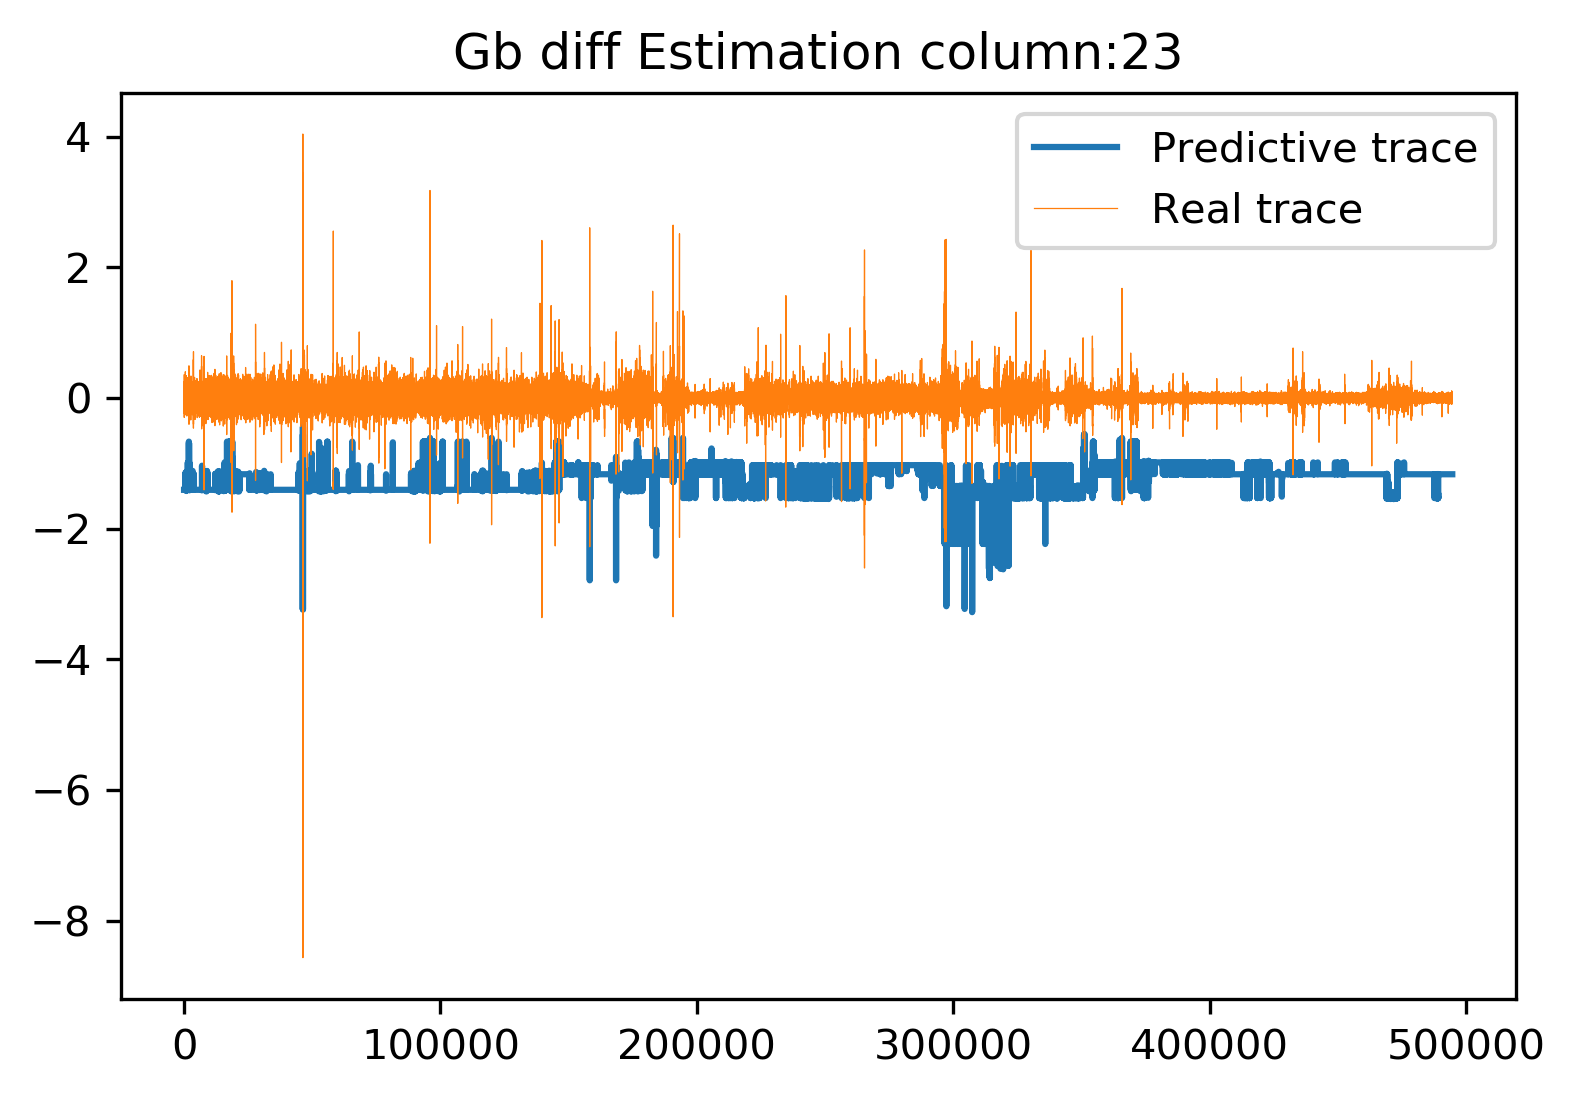

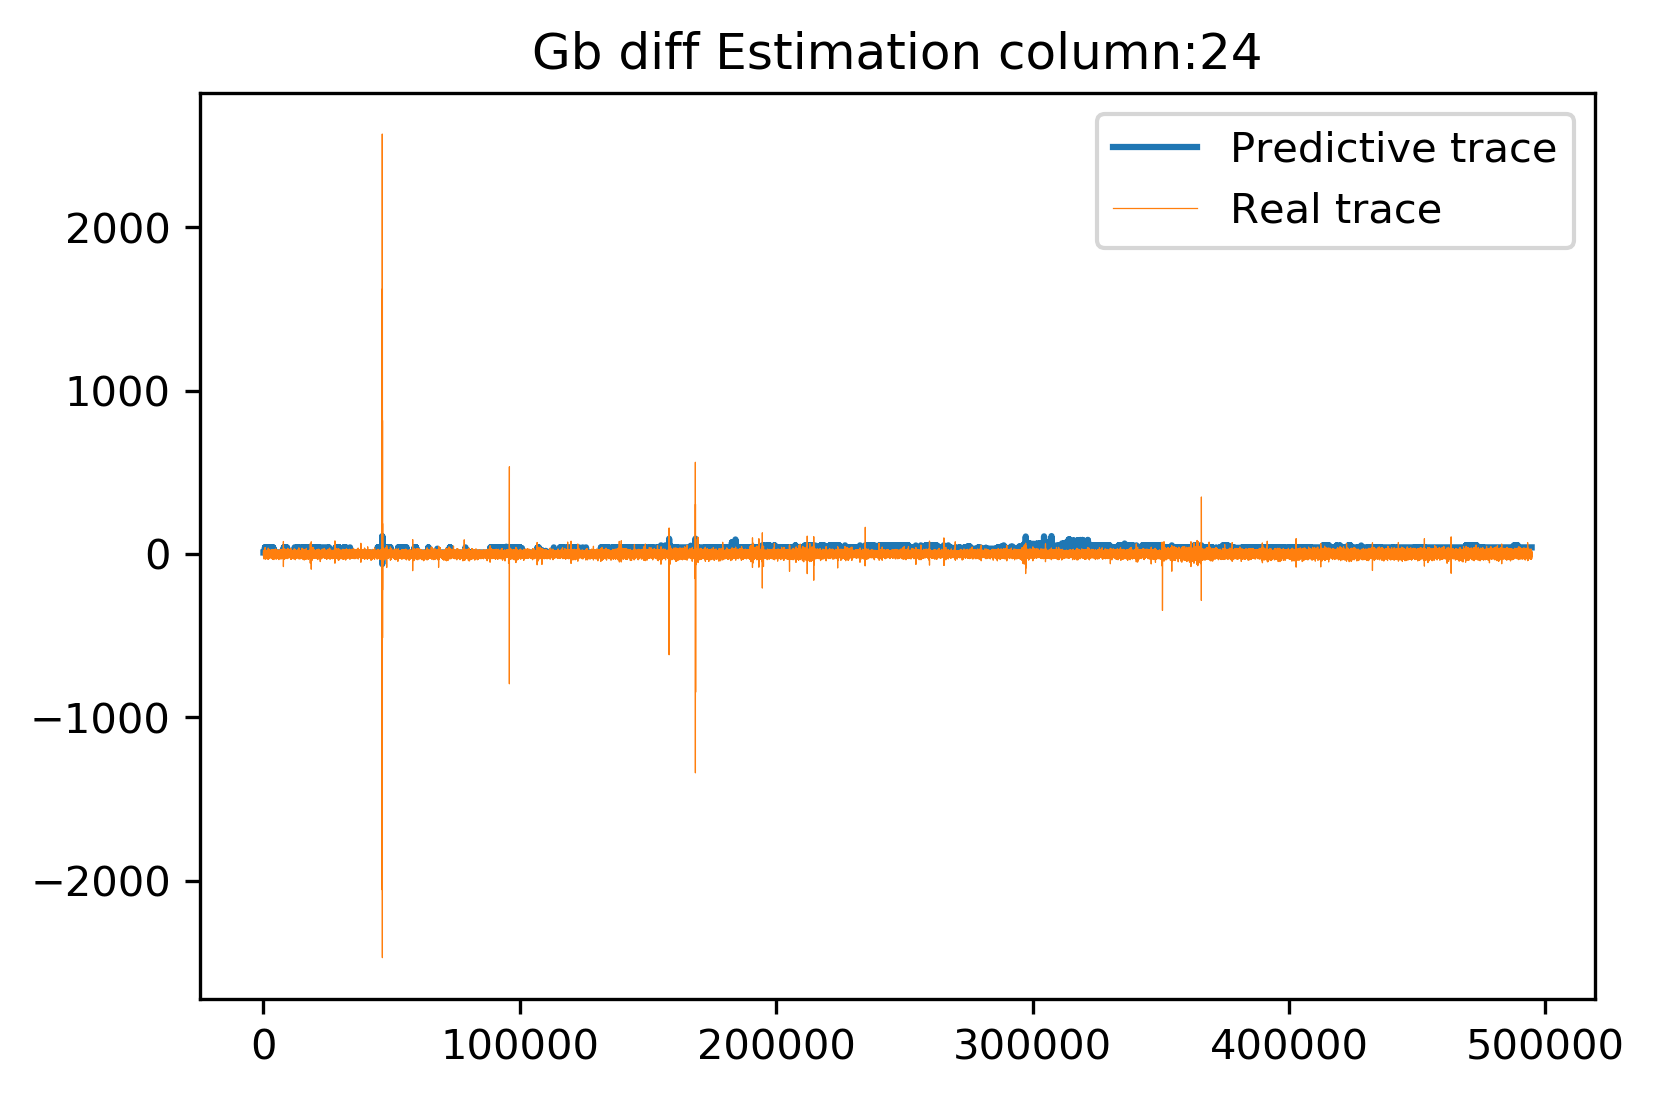

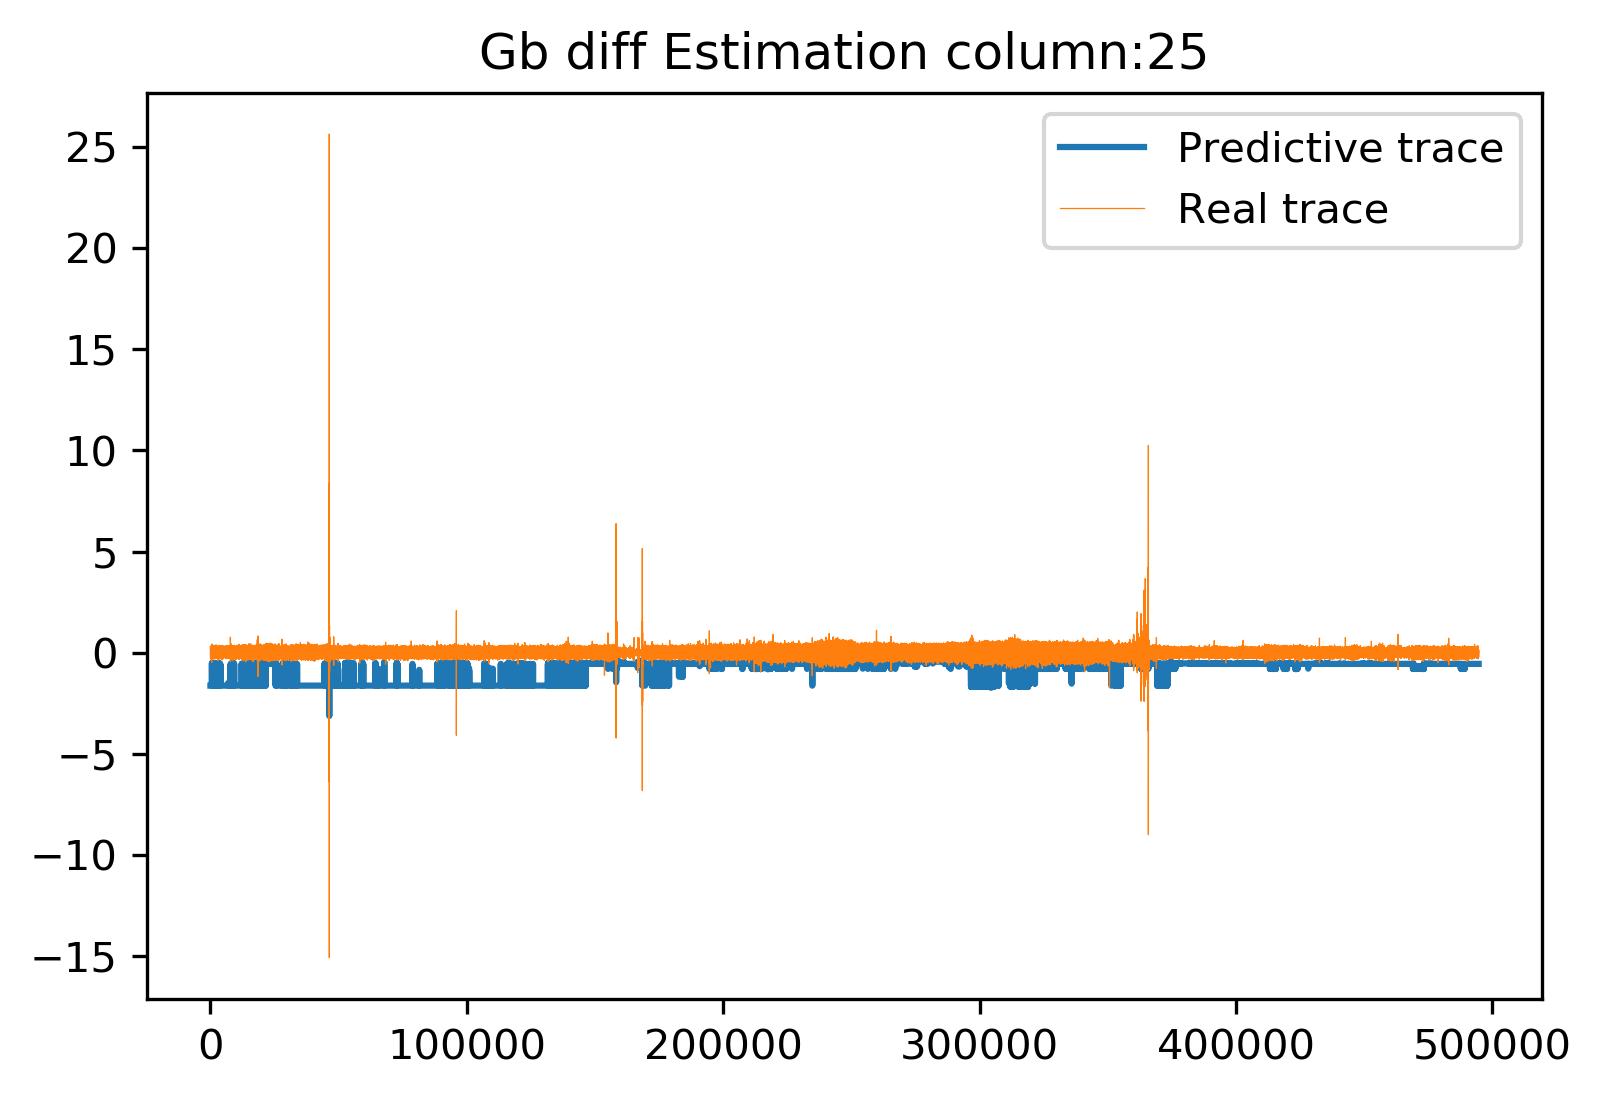

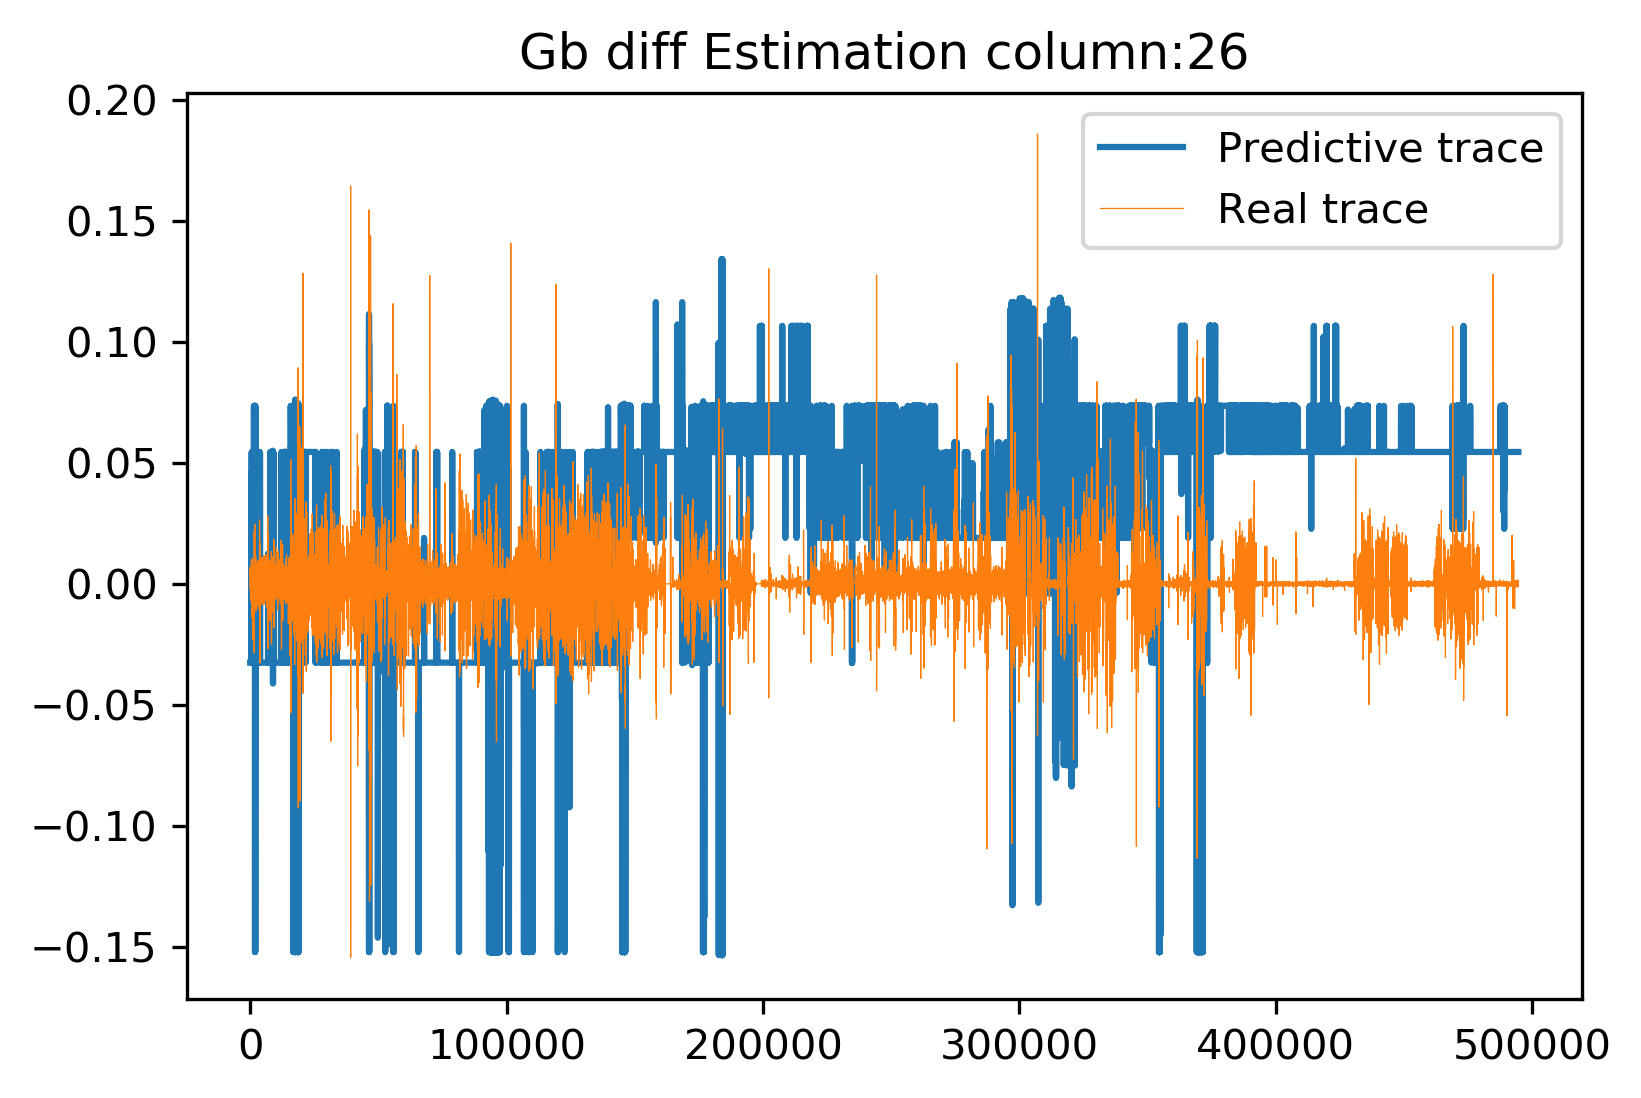

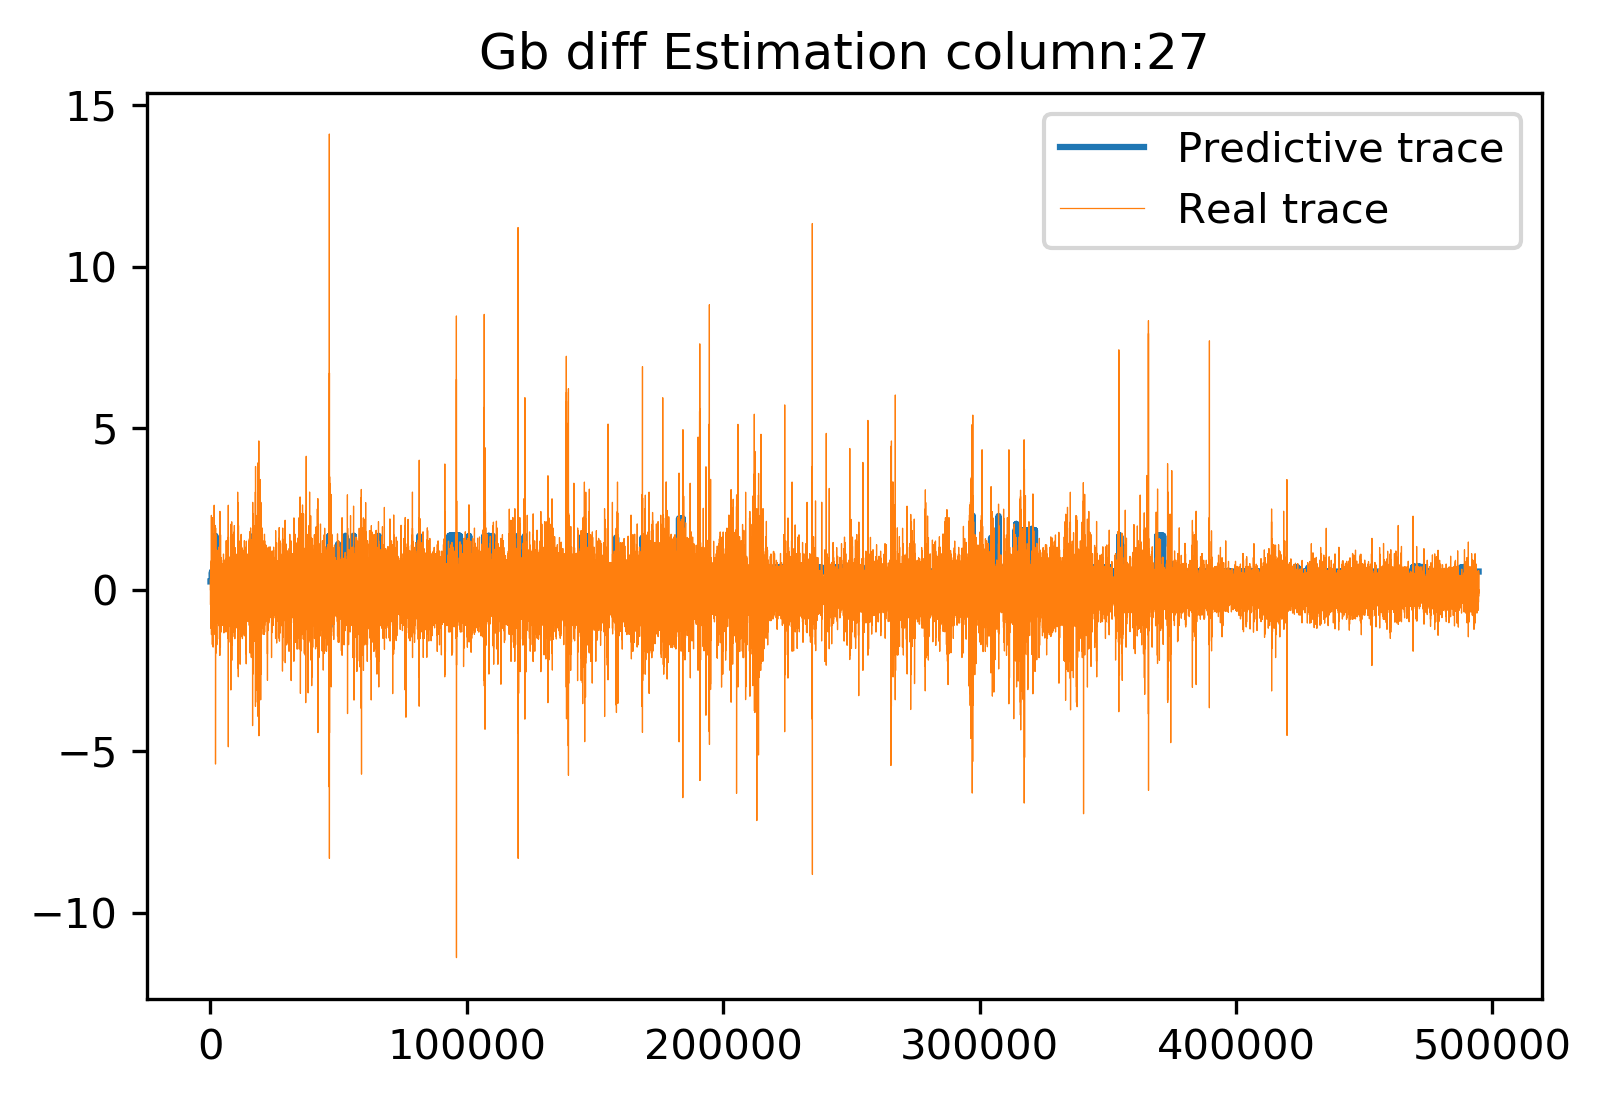

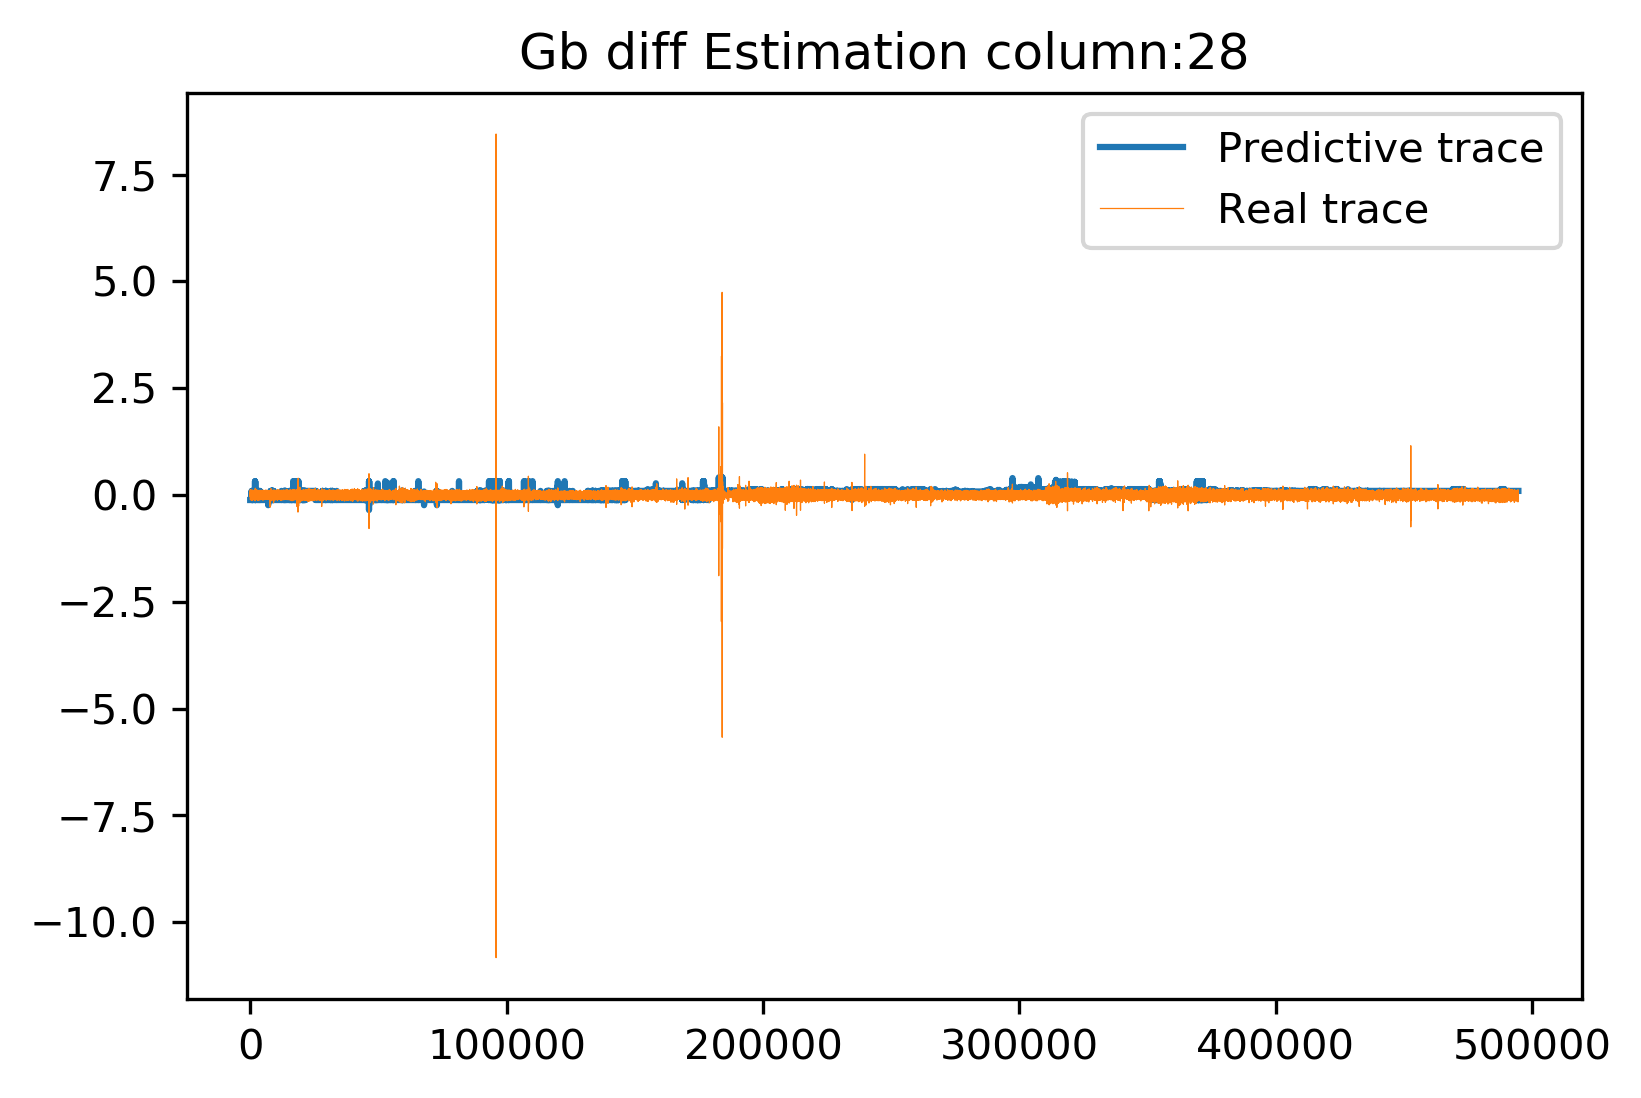

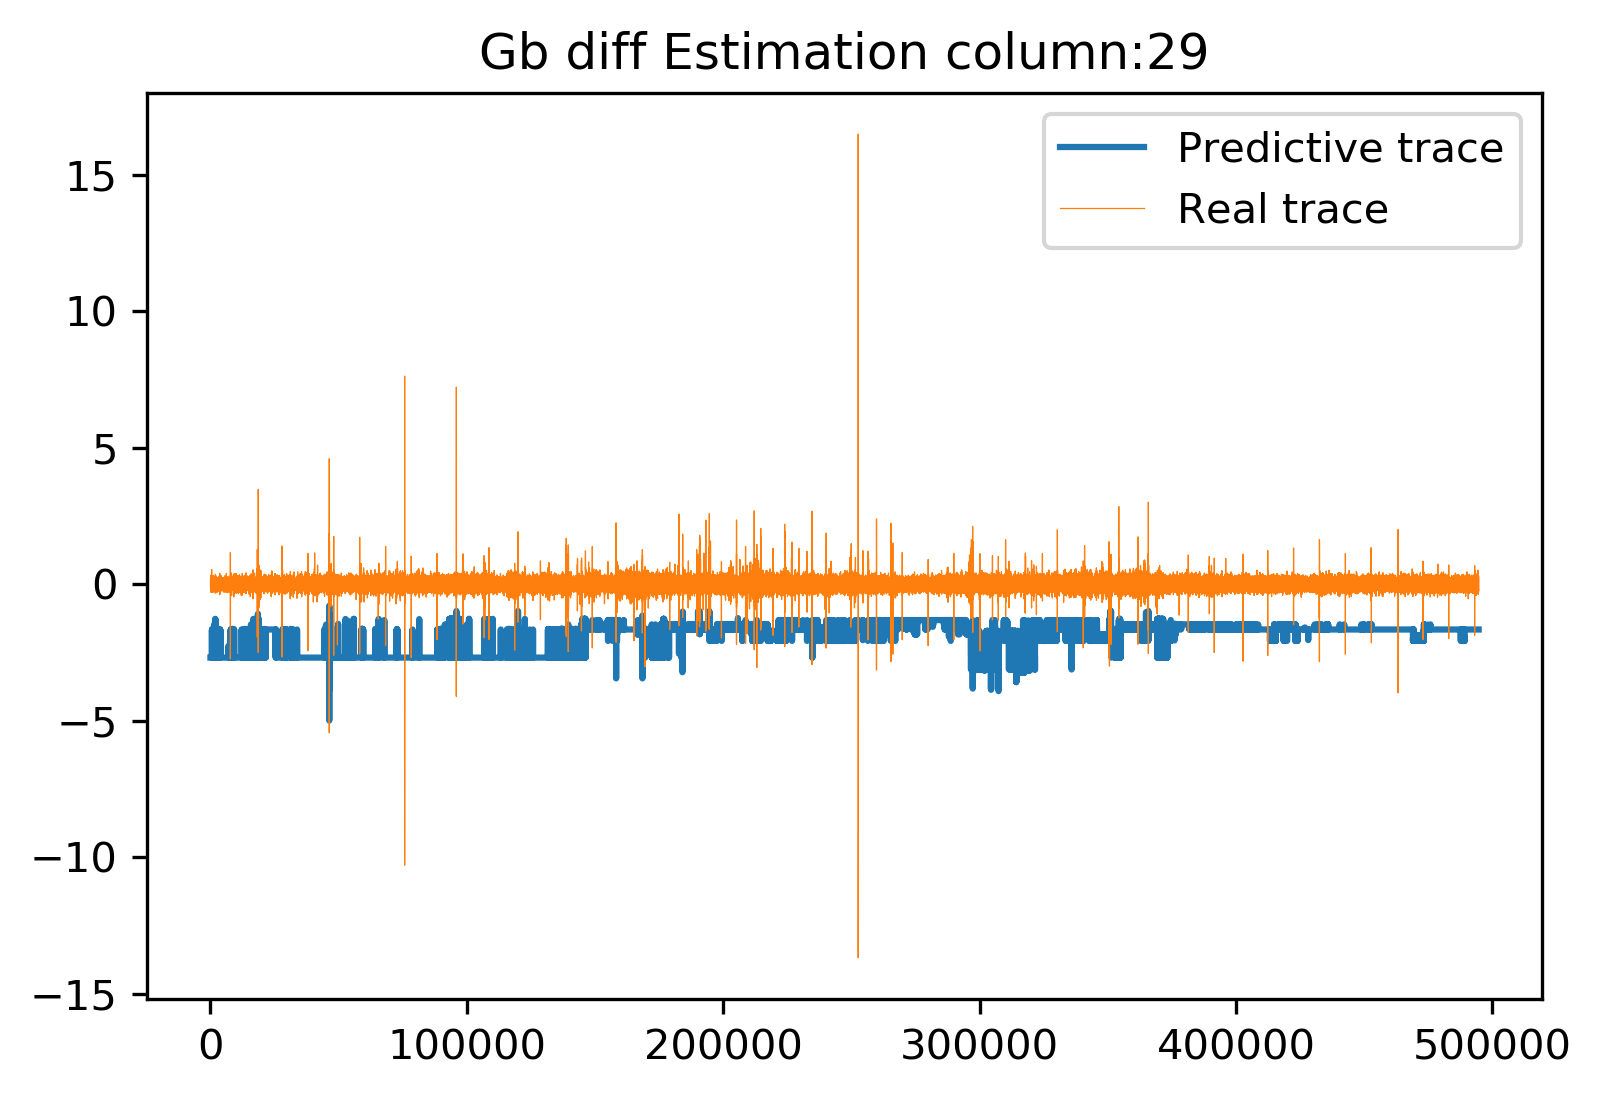

In [122]:
plot_all_traces(predictor_trace=diff_each_step_estimation_nn_trace,real_trace=state_diff,title="Gb diff Estimation")

# Estimation of Heavy Naphta

The Heavy Naphta production correspond 

- Tag: 14FRC501 | Heavy Naphtha from C1452 | High | Int | \\piserver\14FRC501.MEAS

In [125]:
#variable you want to check
variable_name='14FRC501.MEAS'

In [126]:
column=np.where(state_names==variable_name)[0][0]
print(column)

21


In [127]:
#Select parameters of the plot
ini_obs=100000
num_obs=80
all_range=True
if all_range:
    ini_obs=0
    num_obs=494624
state=state_names[column] #should be same of variable name above
print(state)

14FRC501.MEAS


## NN Heavy Naphta

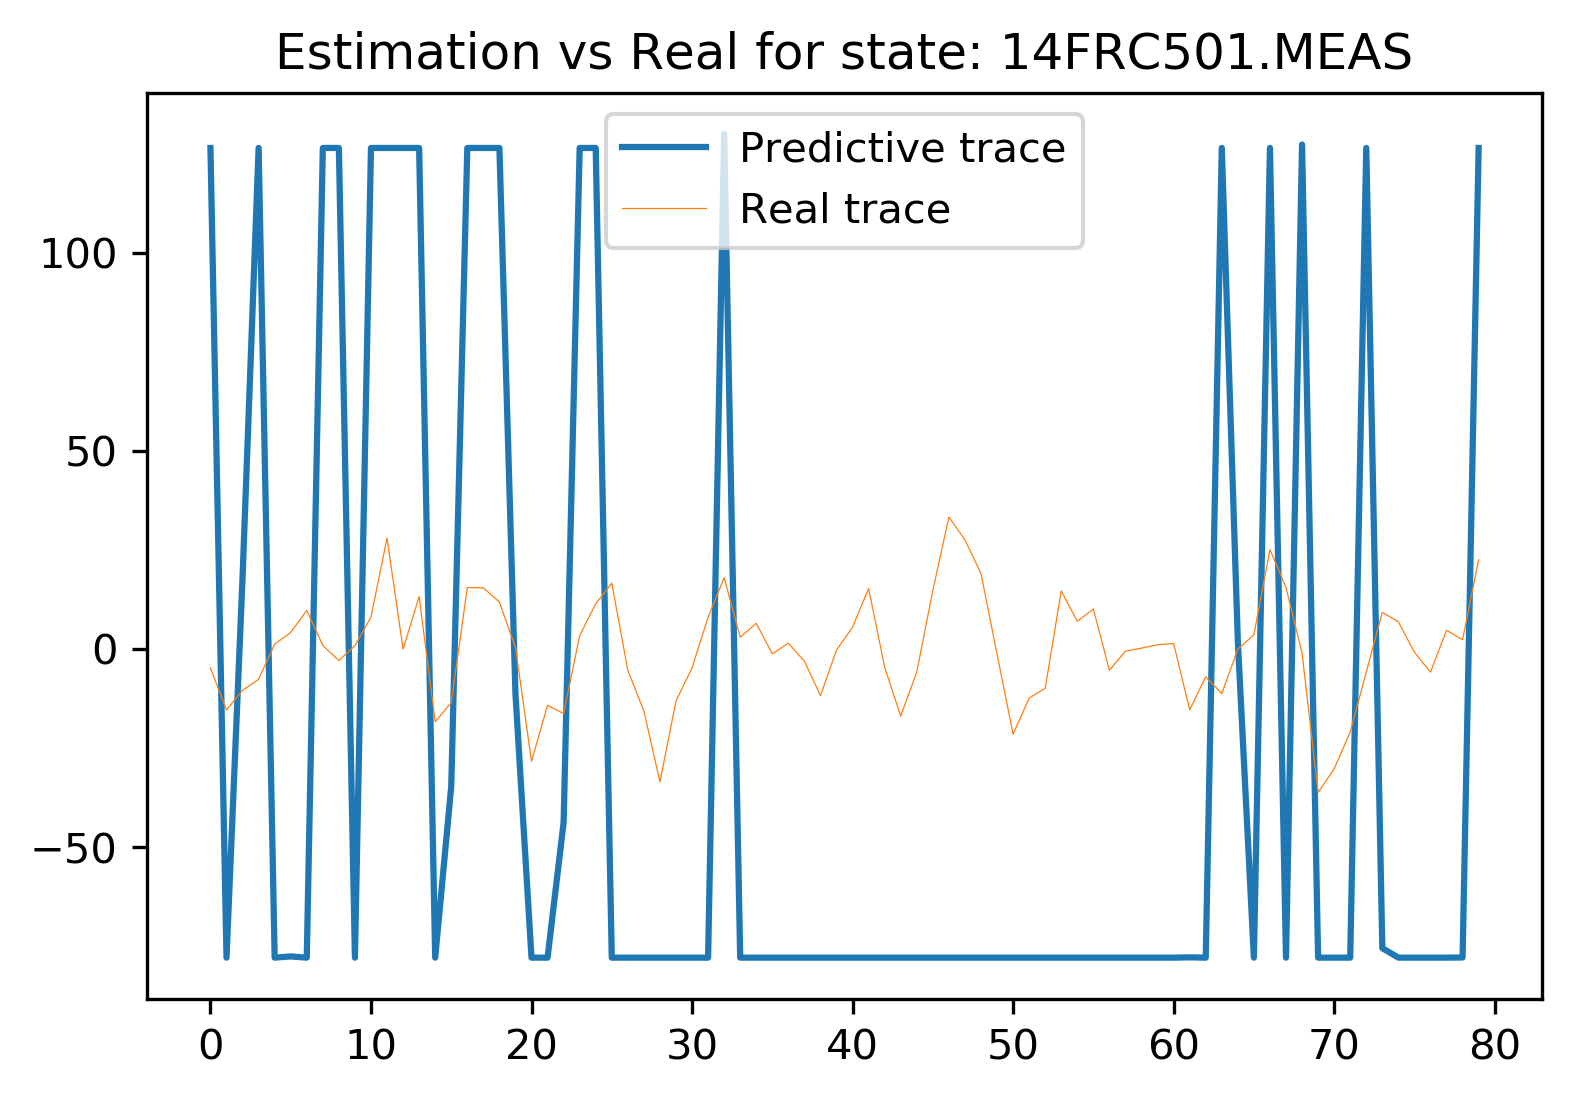

In [128]:
plot_title=('Estimation vs Real for state: %s'%state)
plot_results(estimate_trace=diff_each_step_estimation_nn_trace[ini_obs:ini_obs+num_obs,column],real_trace=state_diff[ini_obs:ini_obs+num_obs,column],title=plot_title)

## GB Heavy Naphta

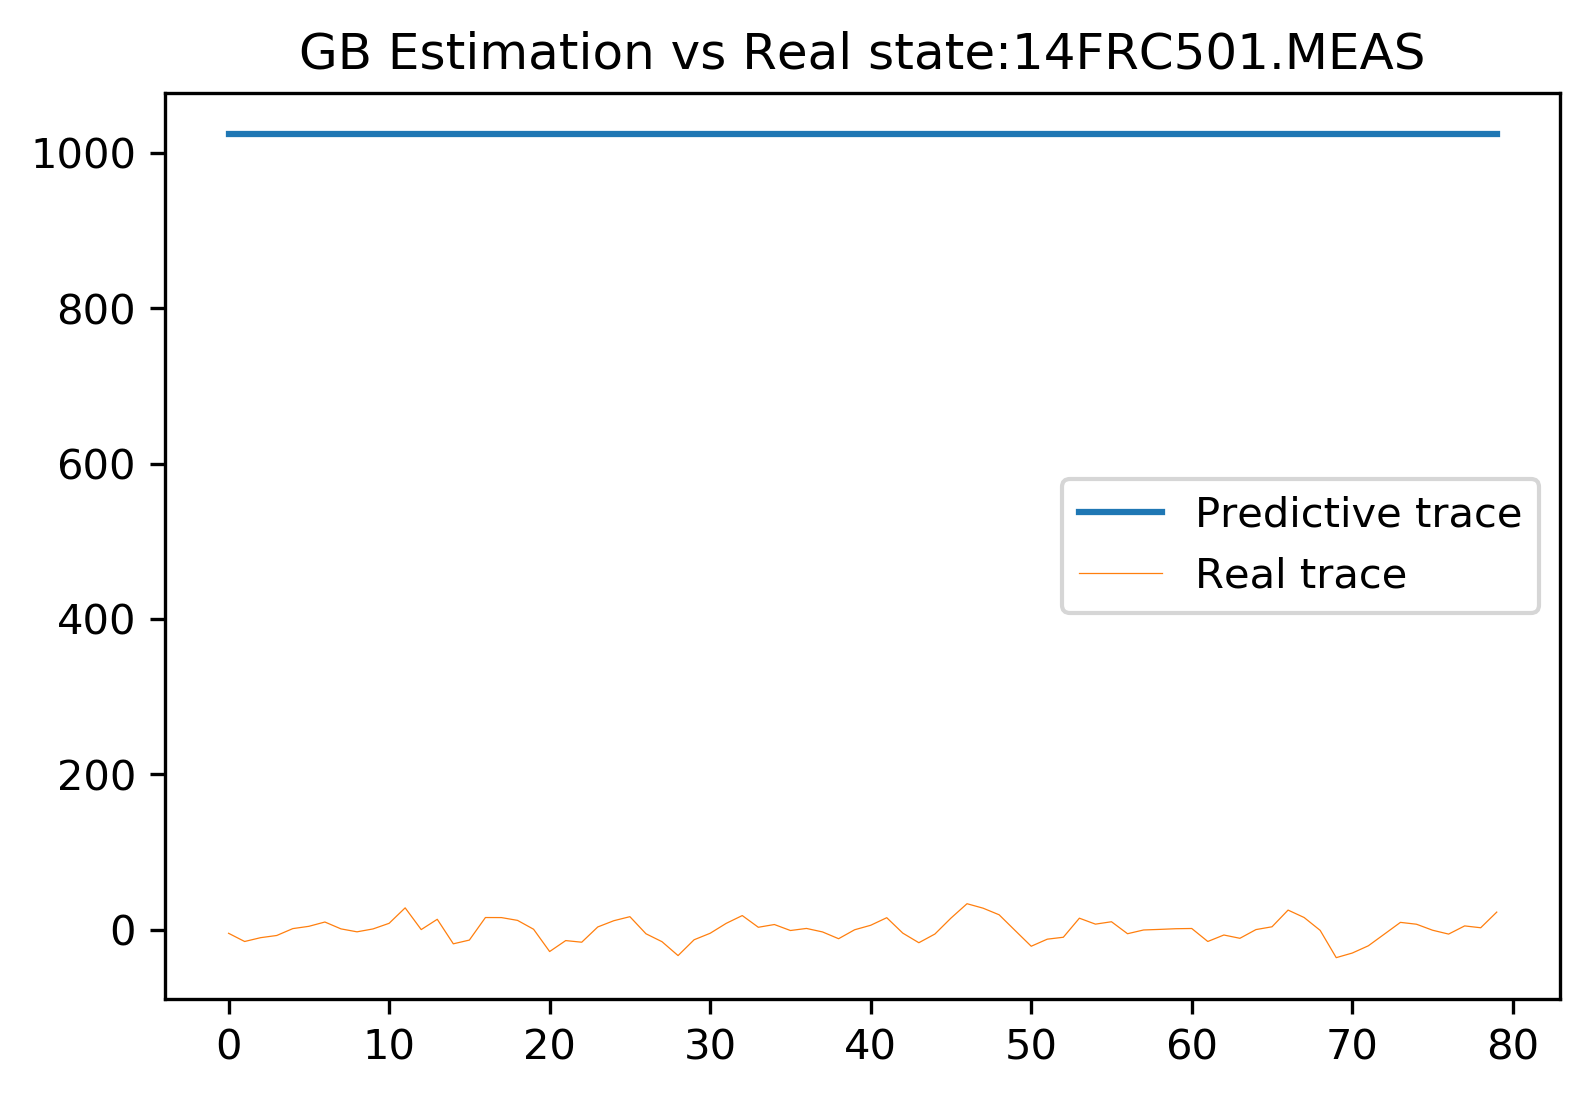

In [129]:
state=state_names[column]
plot_title=('GB Estimation vs Real state:%s'%state)
plot_results(estimate_trace=diff_each_step_estimation_gb_trace[ini_obs:ini_obs+num_obs,column],real_trace=state_diff[ini_obs:ini_obs+num_obs,column],title=plot_title)